In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenizer.add_tokens('pb')

F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1

# Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    max_n_mix:         Maximum number of componds in XRD mix
    substrate_list:    List of available substrates, can be an empty list
    
    [Output]
    Xs:                Array of 2theta in (n,X,1), n = batch_size
    Ys:                Array of intensity in (n,Y,1), n = batch_size
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    labels:            formula in binary array (n,m), n = batch_size, m = number_of_formula_class
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list = []
        self.sample_formula_list = []
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for sample in self.sample_list:
            print(self.dataset[sample]['formula'],self.dataset[sample]['element_list'])
            
        
    def load_data(self, batch_size=10, max_n_mix=3, substrate_list=['ITO','FTO'], twotheta=np.arange(5.00, 60.01, 0.01), 
                  peak_probability_range=(0.2, 1), crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  min_mixing_ratio=0.05, noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.randint(1, max_n_mix+1, batch_size)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Missing peak
                self.X = self.X * np.random.binomial(1, np.random.uniform(*peak_probability_range), self.X.shape[0])
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])

                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list

In [ ]:
del dataloader

In [3]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs4PbBr6 ['Cs', 'Pb', 'Br']
CsBr ['Cs', 'Br']
CsI ['Cs', 'I']
CsPb2Br5 ['Cs', 'Pb', 'Br']
CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
CsPb(I0.2Br0.8)3 ['Cs', 'Pb', 'I', 'Br']
CsPb(I0.4Br0.6)3 ['Cs', 'Pb',

['Pb', 'Cs', 'Br'] ['CsPb2Br5'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['Pb', 'Cs', 'MA', 'Br'] ['Cs0.6MA0.4PbBr3'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['Pb', 'Cl', 'MA'] ['Pnma-MAPbCl3'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


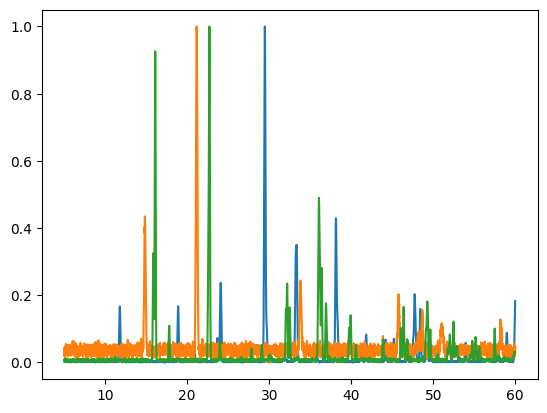

In [4]:
Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=3, max_n_mix=1)
for i in range(len(element_list)):
    plt.plot(np.arange(5.00, 60.01, 0.01), Xs[i])
    print(element_list[i], formula_list[i], Ys[i])

# Train

In [5]:
visual_embedding_dim = 20
configuration = VisualBertConfig(vocab_size=30523, visual_embedding_dim=visual_embedding_dim, hidden_size=int(Xs.shape[1]/visual_embedding_dim), 
                                 num_attention_heads=1, num_labels=Ys.shape[1])
print(configuration)
model = VisualBertForQuestionAnswering(configuration).to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-5)

VisualBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "bypass_transformer": false,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 275,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABEL_34",
    "35": "LABEL_35",
    "

In [6]:
train_losses,train_y_true,train_y_pred = [],[],[]

In [ ]:
num_of_epochs = 100000
batch_size = 20
max_n_mix = 1

model_folder = r'20240905 merged token'

model.train()

for i in range(num_of_epochs):
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=batch_size, max_n_mix=max_n_mix,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.1, 1), min_mixing_ratio=0.3)
    Xs = Xs[:,:-1,:].reshape((Xs.shape[0],int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    X_prompts = []
    for j in range(batch_size):
        random.shuffle(element_list[j])
        X_prompts.append(' '.join(element_list[j]))

    visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            
    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(Ys)).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), labels=labels.to('cuda'))
    logits = outputs.logits
    if max_n_mix > 1:
        weight = labels*10+1
        loss = torch.nn.BCELoss(weight=weight.to('cuda'))(logits, labels.to('cuda'))
    else:
        loss = outputs.loss
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    y_true = np.array(labels)
    train_y_true.append(y_true)
    y_pred = np.array(logits.detach().cpu())
    train_y_pred.append(y_pred)
    
    print('{}\t{:.5f}\t{}'.format(i+1, np.array(loss.detach().cpu()), y_true.argmax(-1)[:15]-y_pred.argmax(-1)[:15]))
#     break
    train_losses.append(np.array(loss.detach().cpu()))
    
    if (i+1)%5000 == 0:
        model.save_pretrained(os.path.join(folder, 'models', model_folder, '{}'.format(i+1)), from_pt=True) 
        np.savetxt(os.path.join(folder, 'models', model_folder, 'train_loss.csv'), train_losses, delimiter=',')

1	4.38007	[ 45  -6  19 -38 -17  -9 -12   5  28  -3 -26 -30  18  -8  20]
2	4.32000	[ 21 -52 -36 -35   6 -41 -26 -53   4  14   4 -55 -28  -7 -50]
3	4.25705	[-52 -22 -34   5   8  28  12  -6  19 -35 -58 -25  -3  -5 -38]
4	4.21449	[  5   7 -38 -16 -32  15  41  24 -17   1 -59  37 -19 -17 -63]
5	4.37196	[ 16 -20   2 -29 -36   9  -5 -29   8 -17  12 -29  -3   2  20]
6	4.40765	[-22  17  28  16  21 -35 -37 -62  -7 -53 -52  -7 -11  32  -7]
7	4.18661	[-61   0 -22  17   7 -16   9   6  34 -17  45   8   9  30  19]
8	4.16072	[ -2  47   2 -47 -35 -23  29 -14  11   3   2 -22  44  25 -43]
9	4.13710	[-18  44 -34  20  34 -50  44 -46 -36 -24  29  18  -8  30  28]
10	4.24911	[ 16 -52 -39 -24   7   3 -46   5  29  22  -4 -54   8   1  -2]
11	4.25085	[  2  25  28  15  11 -48 -45 -40 -49 -45   5  -3  -8  17  17]
12	4.25076	[-25  -6   4 -62 -36  -7 -44 -19  25 -17 -10  44  15  30  36]
13	4.15127	[-43 -21  15  28   2  23  -8 -30  19   4   7   0  -8 -29  16]
14	4.21847	[ -1  -1  31 -24  25 -17 -10  14 -38 -26   7  -4 

C:\Users\axvcb\AppData\Local\Temp\ipykernel_130288\415997285.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


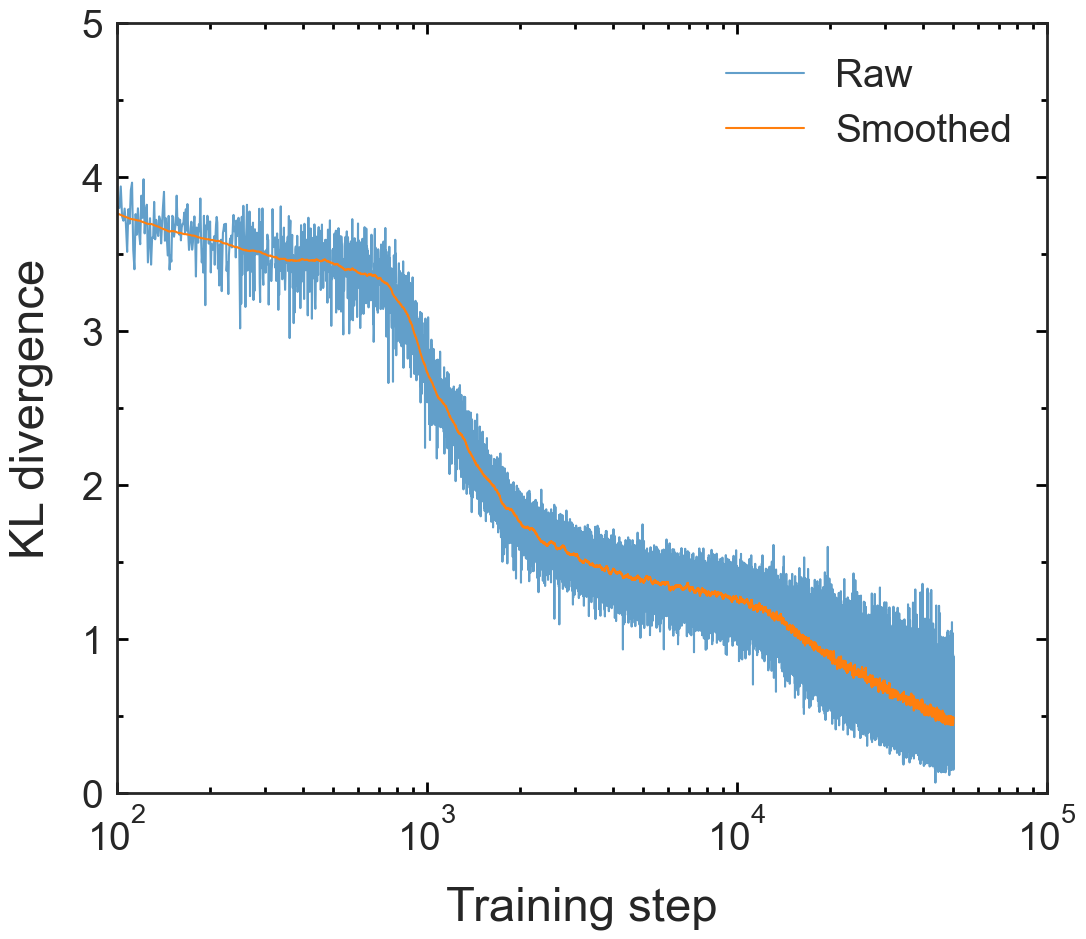

In [20]:
smoothed = savgol_filter(np.array(train_losses),window_length=201,polyorder=3)

load_plt_setting()

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(np.array(train_losses),zorder=-10, alpha=0.7, label='Raw')
ax.plot(smoothed, label='Smoothed')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.axes.set_xlim([100,100000])
ax.axes.set_ylim([0,5])
ax.set_xscale('log')

ax.set_xlabel(r'Training step', labelpad=20, fontsize=34)
ax.set_ylabel(r'KL divergence', labelpad=20, fontsize=34)
plt.legend(loc="upper right",fontsize=28)

plt.savefig(os.path.join(folder, 'models','20240905','train_loss.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')

In [138]:
del model
gc.collect()
torch.cuda.empty_cache() 

# Attention

In [139]:
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models','20240905','45000')).to('cuda')

In [140]:
try:
    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'rb') as handle:
        test_dataset = joblib.load(handle)
    
    Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    print('test dataset loaded.')

except:
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1000, max_n_mix=1,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.1, 1), min_mixing_ratio=0.3)
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')

test dataset loaded.


In [150]:
y_true, y_pred, y_formula = [], [], []

for i in range(len(element_list)):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    logits = outputs.logits
    y_true.append(np.array(labels).argmax(-1)[0])
    y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
    y_formula.append(formula_list[i])
    
    print(y_formula[-1],y_true[-1],y_pred[-1])

1000

In [183]:
y_true, y_pred, y_formula = [], [], []

for i in range(len(element_list)):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    logits = outputs.logits
    y_true.append(np.array(labels).argmax(-1)[0])
    y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
    y_formula.append(formula_list[i])
    
    print(y_formula[-1],y_true[-1],y_pred[-1])

['Cs0.2FA0.8PbBr3'] 0 0
['MAPb(Br0.4I0.6)3'] 41 41
['Cs0.8FA0.2PbBr3'] 12 12
['Cs0.8FA0.2PbBr3'] 12 12
['FAPb(Br0.2I0.8)3'] 28 28
['orthorhombic-CsPbBr3'] 50 50
['MA0.4FA0.6PbBr3'] 34 34
['MAPb(Br0.2I0.8)3'] 40 40
['FAPb(Br0.8I0.2)3'] 31 31
['CsPb(I0.8Br0.2)3'] 26 26
['tetragonal-MAPbI3'] 57 57
['beta-FAPbI3'] 53 53
['MA0.2FA0.8PbBr3'] 32 32
['Cs0.8FA0.2PbBr3'] 12 12
['CsPb(Cl0.6Br0.4)3'] 18 17
['Pnma-CsPbCl3'] 68 68
['CsPb(I0.4Cl0.6)3'] 23 23
['beta-FAPbI3'] 53 53
['FAPb(Br0.2I0.8)3'] 28 28
['Cs0.6FA0.4PbBr3'] 8 8
['Cs0.2FA0.8PbBr3'] 0 0
['Pnma-MAPbCl3'] 67 67
['Cs0.2FA0.8PbBr3'] 0 0
['FAPb(Br0.4I0.6)3'] 29 29
['CsPb(I0.4Br0.6)3'] 22 22
['CsPb(Cl0.6Br0.4)3'] 18 17
['Pnma-CsPbCl3'] 68 68
['gamma-CsPbI3'] 44 61
['tetragonal-MAPbI3'] 57 57
['FAPb(Br0.2I0.8)3'] 28 28
['FAPb(Br0.2I0.8)3'] 28 28
['Cs0.6MA0.4PbI3'] 11 15
['MA0.2FA0.8PbBr3'] 32 34
['alpha-MAPbI3'] 64 64
['FAPb(Br0.8I0.2)3'] 31 31
['MA0.4FA0.6PbBr3'] 34 34
['CsI'] 49 49
['FAPb(Br0.4I0.6)3'] 29 29
['Cs0.4FA0.6PbBr3'] 4 0
['CsPb

['MA0.6FA0.4PbBr3'] 36 36
['cubic-CsPbCl3'] 65 65
['CsPb(I0.2Cl0.8)3'] 21 21
['cubic-CsPbCl3'] 65 65
['CsBr'] 56 56
['Cs0.2MA0.8PbBr3'] 2 2
['Cs0.6MA0.4PbI3'] 11 15
['Cs4PbBr6'] 47 47
['MAPb(Br0.6I0.4)3'] 42 43
['Cs0.8MA0.2PbI3'] 15 11
['alpha-MAPbI3'] 64 57
['gamma-CsPbI3'] 44 45
['MA0.8FA0.2PbI3'] 39 35
['Cs0.2FA0.8PbI3'] 1 1
['Cs0.2MA0.8PbI3'] 3 3
['CsBr'] 56 56
['CsPb(Cl0.6Br0.4)3'] 18 17
['Cs0.8MA0.2PbI3'] 15 11
['delta-FAPbI3'] 52 60
['CsI'] 49 49
['CsPb(I0.2Cl0.8)3'] 21 23
['CsPb(I0.2Cl0.8)3'] 21 21
['cubic-FAPbBr3'] 55 55
['Cs0.6MA0.4PbI3'] 11 15
['cubic-MAPbBr3'] 54 54
['gamma-CsPbI3'] 61 61
['Pbnm-CsPbCl3'] 66 66
['Cs4PbBr6'] 47 47
['alpha-MAPbI3'] 64 64
['CsPb(I0.4Br0.6)3'] 22 22
['tetragonal-MAPbBr3'] 62 54
['Cs0.6FA0.4PbBr3'] 8 8
['delta-FAPbI3'] 52 52
['Cs0.8MA0.2PbI3'] 15 15
['MA0.8FA0.2PbBr3'] 38 38
['Cs0.6MA0.4PbI3'] 11 11
['cubic-FAPbBr3'] 55 55
['FAPb(Br0.8I0.2)3'] 31 31
['FAPb(Br0.8I0.2)3'] 31 31
['cubic-CsPbBr3'] 63 63
['Cs0.4FA0.6PbBr3'] 4 8
['MA0.4FA0.6PbI3'] 35 

['CsPb(Cl0.2Br0.8)3'] 16 18
['cubic-FAPbBr3'] 55 55
['cubic-FAPbBr3'] 55 55
['PbBr2'] 58 58
['FAPb(Br0.6I0.4)3'] 30 30
['alpha-MAPbI3'] 64 64
['Cs0.2FA0.8PbI3'] 1 1
['MA0.2FA0.8PbI3'] 33 33
['MA0.2FA0.8PbBr3'] 32 32
['Cs0.2FA0.8PbBr3'] 0 8
['CsPb(Cl0.8Br0.2)3'] 19 19
['Cs0.8FA0.2PbI3'] 13 13
['CsPb(Cl0.4Br0.6)3'] 17 16
['alpha-FAPbI3'] 59 59
['FAPb(Br0.6I0.4)3'] 30 30
['FAPb(Br0.8I0.2)3'] 31 29
['MA0.2FA0.8PbBr3'] 32 32
['Pbnm-CsPbCl3'] 66 66
['MA0.6FA0.4PbI3'] 37 37
['FAPb(Br0.8I0.2)3'] 31 31
['MA0.4FA0.6PbI3'] 35 39
['Cs0.8MA0.2PbBr3'] 14 14
['Pnma-CsPbCl3'] 68 68
['alpha-CsPbI3'] 51 51
['Cs0.8MA0.2PbBr3'] 14 14
['MAPb(Br0.4I0.6)3'] 41 41
['MA0.4FA0.6PbI3'] 35 39
['CsPb(Cl0.8Br0.2)3'] 19 19
['MA0.4FA0.6PbBr3'] 34 34
['tetragonal-MAPbI3'] 57 57
['CsPb(Cl0.6Br0.4)3'] 18 18
['CsPb(I0.4Cl0.6)3'] 23 23
['Cs0.2MA0.8PbI3'] 3 3
['alpha-MAPbI3'] 64 64
['PbI2'] 46 46
['Cs0.4FA0.6PbI3'] 5 5
['Cs0.8MA0.2PbI3'] 15 15
['cubic-CsPbCl3'] 65 65
['Pbnm-CsPbCl3'] 66 66
['FAPb(Br0.6I0.4)3'] 30 30
['MA0.

In [179]:
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        print(str(y_true[i])+'\t'+dataloader.dataset[dataloader.sample_list[y_true[i]]]['formula']+'\t\t'+str(y_pred[i])+'\t'+
             dataloader.dataset[dataloader.sample_list[y_pred[i]]]['formula'])

18	CsPb(Cl0.6Br0.4)3		17	CsPb(Cl0.4Br0.6)3
18	CsPb(Cl0.6Br0.4)3		17	CsPb(Cl0.4Br0.6)3
44	gamma-CsPbI3		61	gamma-CsPbI3
11	Cs0.6MA0.4PbI3		15	Cs0.8MA0.2PbI3
32	MA0.2FA0.8PbBr3		34	MA0.4FA0.6PbBr3
4	Cs0.4FA0.6PbBr3		0	Cs0.2FA0.8PbBr3
27	CsPb(I0.8Cl0.2)3		23	CsPb(I0.4Cl0.6)3
38	MA0.8FA0.2PbBr3		32	MA0.2FA0.8PbBr3
9	Cs0.6FA0.4PbI3		5	Cs0.4FA0.6PbI3
23	CsPb(I0.4Cl0.6)3		21	CsPb(I0.2Cl0.8)3
44	gamma-CsPbI3		45	delta-CsPbI3
64	alpha-MAPbI3		57	tetragonal-MAPbI3
21	CsPb(I0.2Cl0.8)3		27	CsPb(I0.8Cl0.2)3
38	MA0.8FA0.2PbBr3		36	MA0.6FA0.4PbBr3
35	MA0.4FA0.6PbI3		37	MA0.6FA0.4PbI3
14	Cs0.8MA0.2PbBr3		10	Cs0.6MA0.4PbBr3
4	Cs0.4FA0.6PbBr3		12	Cs0.8FA0.2PbBr3
47	Cs4PbBr6		48	CsPb2Br5
41	MAPb(Br0.4I0.6)3		40	MAPb(Br0.2I0.8)3
16	CsPb(Cl0.2Br0.8)3		18	CsPb(Cl0.6Br0.4)3
10	Cs0.6MA0.4PbBr3		6	Cs0.4MA0.6PbBr3
16	CsPb(Cl0.2Br0.8)3		18	CsPb(Cl0.6Br0.4)3
26	CsPb(I0.8Br0.2)3		20	CsPb(I0.2Br0.8)3
32	MA0.2FA0.8PbBr3		34	MA0.4FA0.6PbBr3
44	gamma-CsPbI3		61	gamma-CsPbI3
7	Cs0.4MA0.6PbI3		3	Cs0.2MA0.8PbI3
35	MA0.4F

C:\Users\axvcb\AppData\Local\Temp\ipykernel_130288\1895622639.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Text(0, 0.5, 'True class')

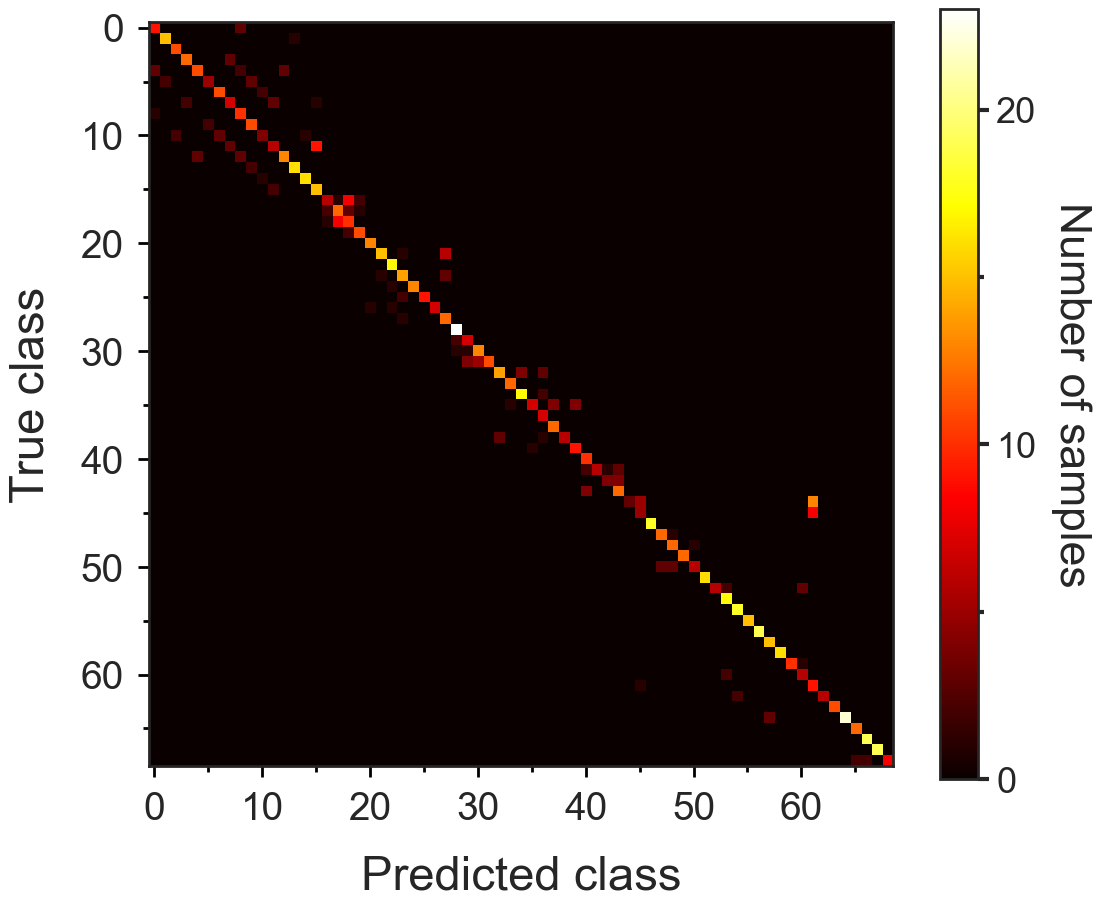

In [163]:
load_plt_setting()

matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

In [167]:
classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)

{'Cs0.2FA0.8PbBr': {'precision': 0.6923076923076923,
  'recall': 0.75,
  'f1-score': 0.7199999999999999,
  'support': 12.0},
 'Cs0.2FA0.8PbI': {'precision': 0.8823529411764706,
  'recall': 0.9375,
  'f1-score': 0.9090909090909091,
  'support': 16.0},
 'Cs0.2MA0.8PbBr': {'precision': 0.8461538461538461,
  'recall': 1.0,
  'f1-score': 0.9166666666666666,
  'support': 11.0},
 'Cs0.2MA0.8PbI': {'precision': 0.8571428571428571,
  'recall': 0.8,
  'f1-score': 0.8275862068965518,
  'support': 15.0},
 'Cs0.4FA0.6PbBr': {'precision': 0.7857142857142857,
  'recall': 0.5789473684210527,
  'f1-score': 0.6666666666666667,
  'support': 19.0},
 'Cs0.4FA0.6PbI': {'precision': 0.7142857142857143,
  'recall': 0.5,
  'f1-score': 0.588235294117647,
  'support': 10.0},
 'Cs0.4MA0.6PbBr': {'precision': 0.7857142857142857,
  'recall': 0.8461538461538461,
  'f1-score': 0.8148148148148148,
  'support': 13.0},
 'Cs0.4MA0.6PbI': {'precision': 0.5384615384615384,
  'recall': 0.5384615384615384,
  'f1-score': 0.53

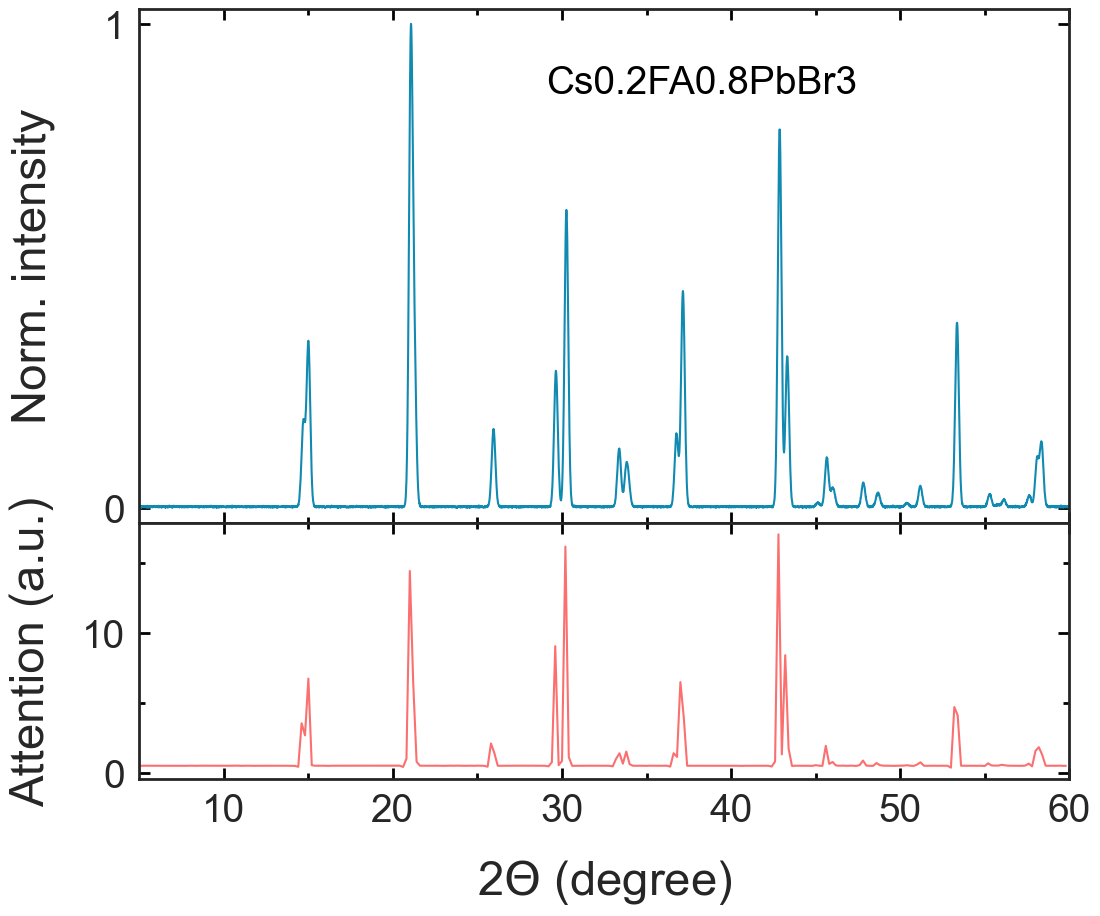

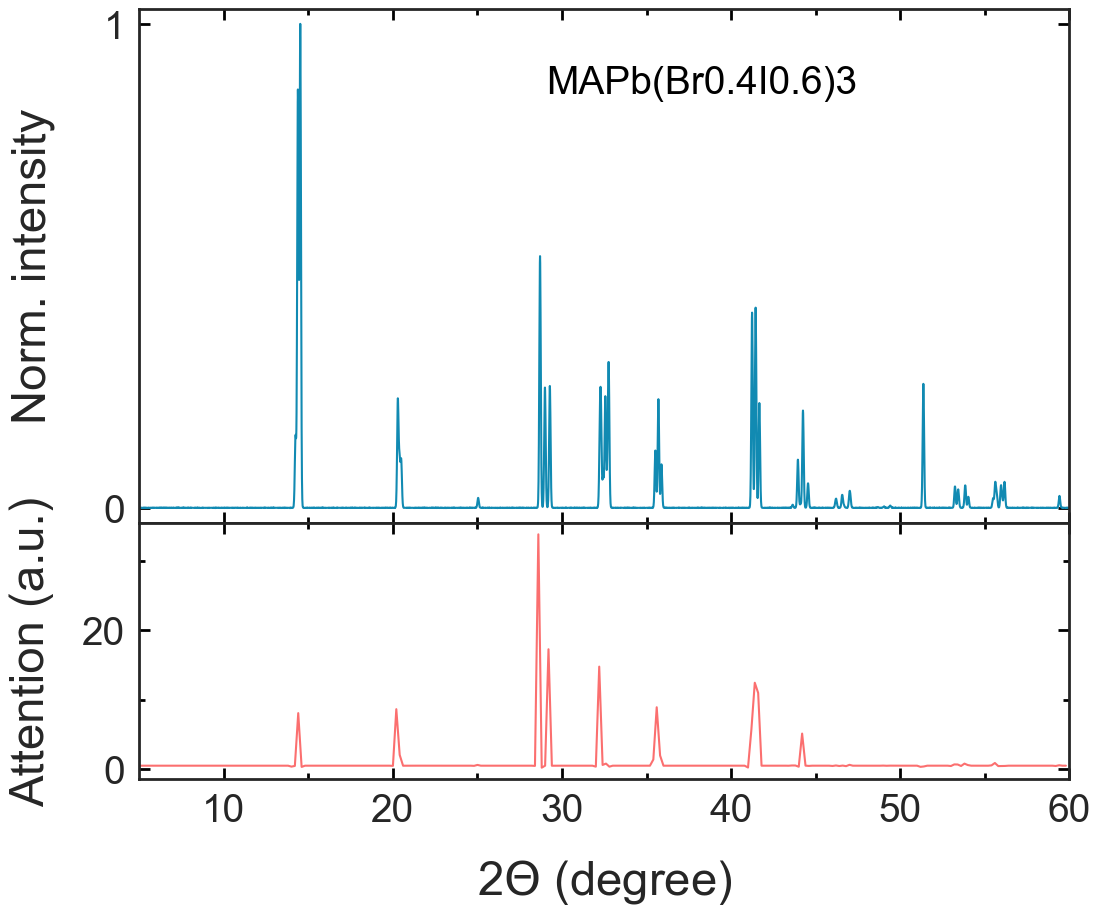

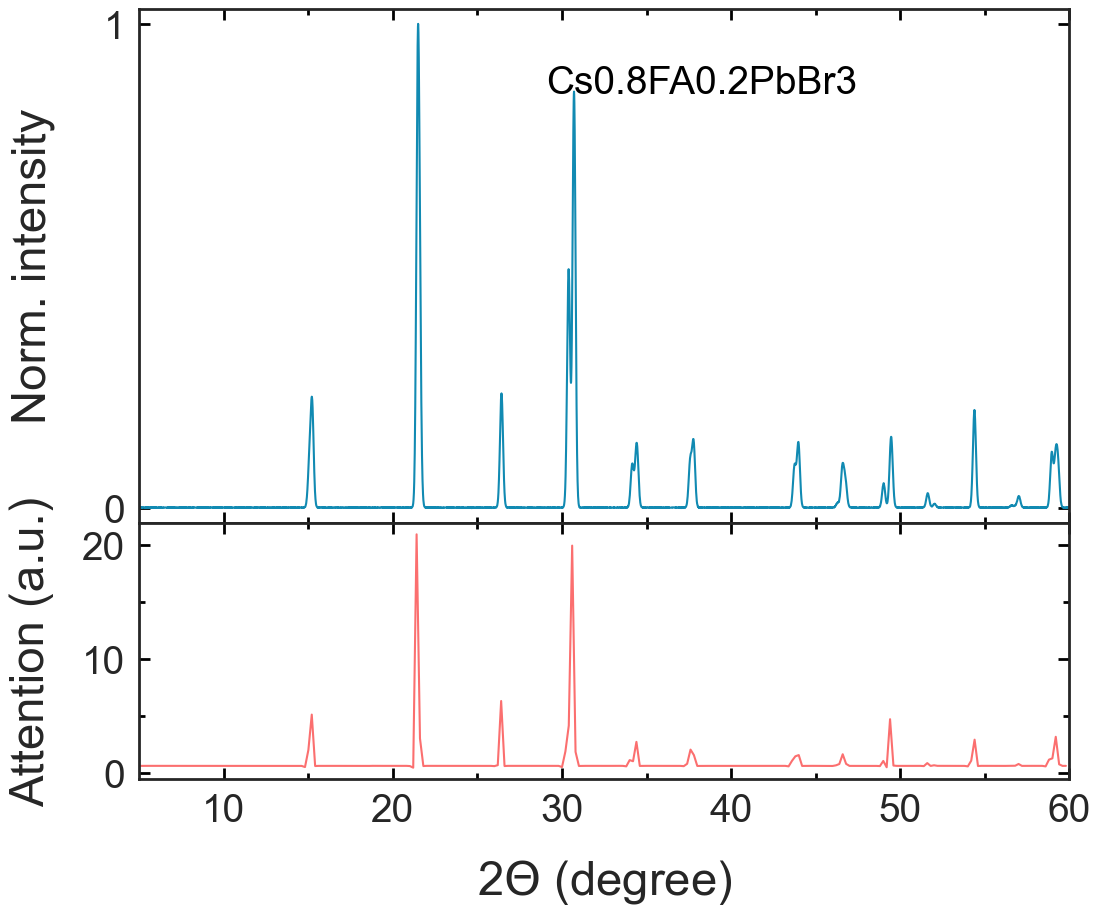

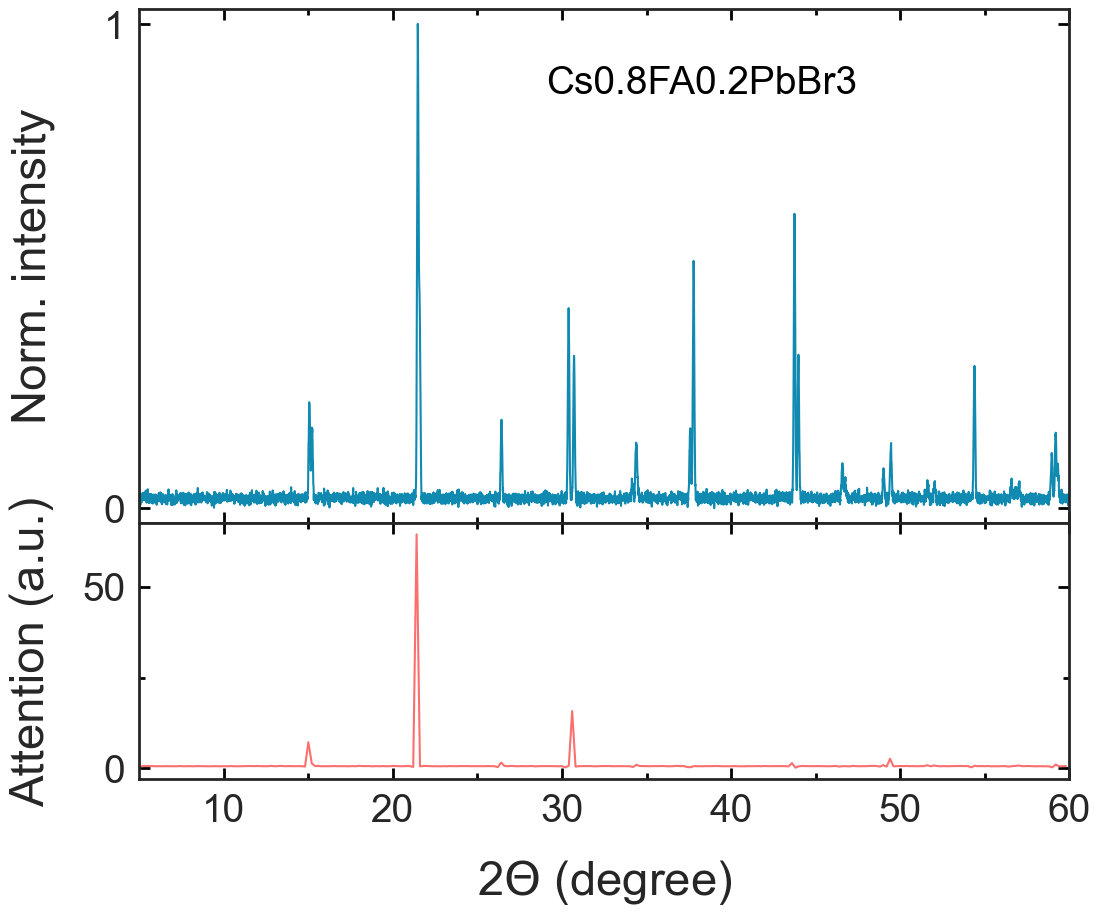

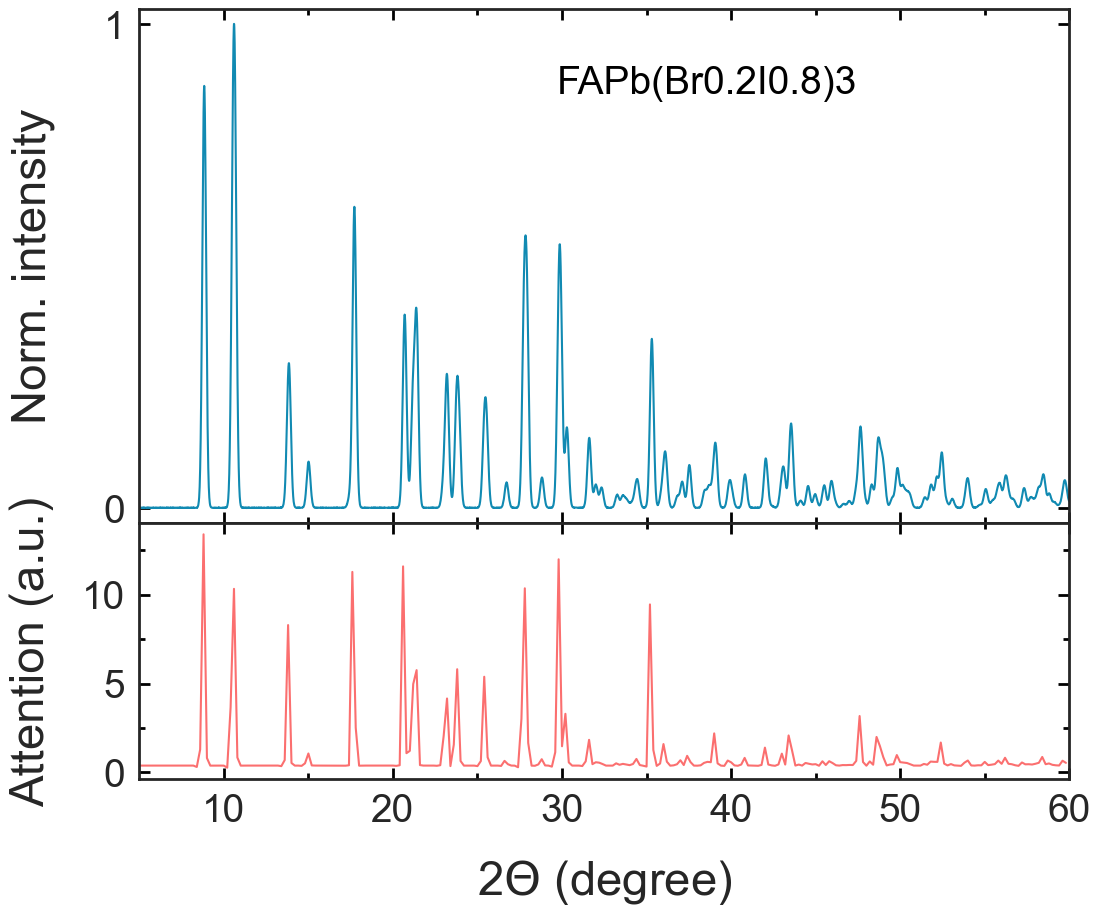

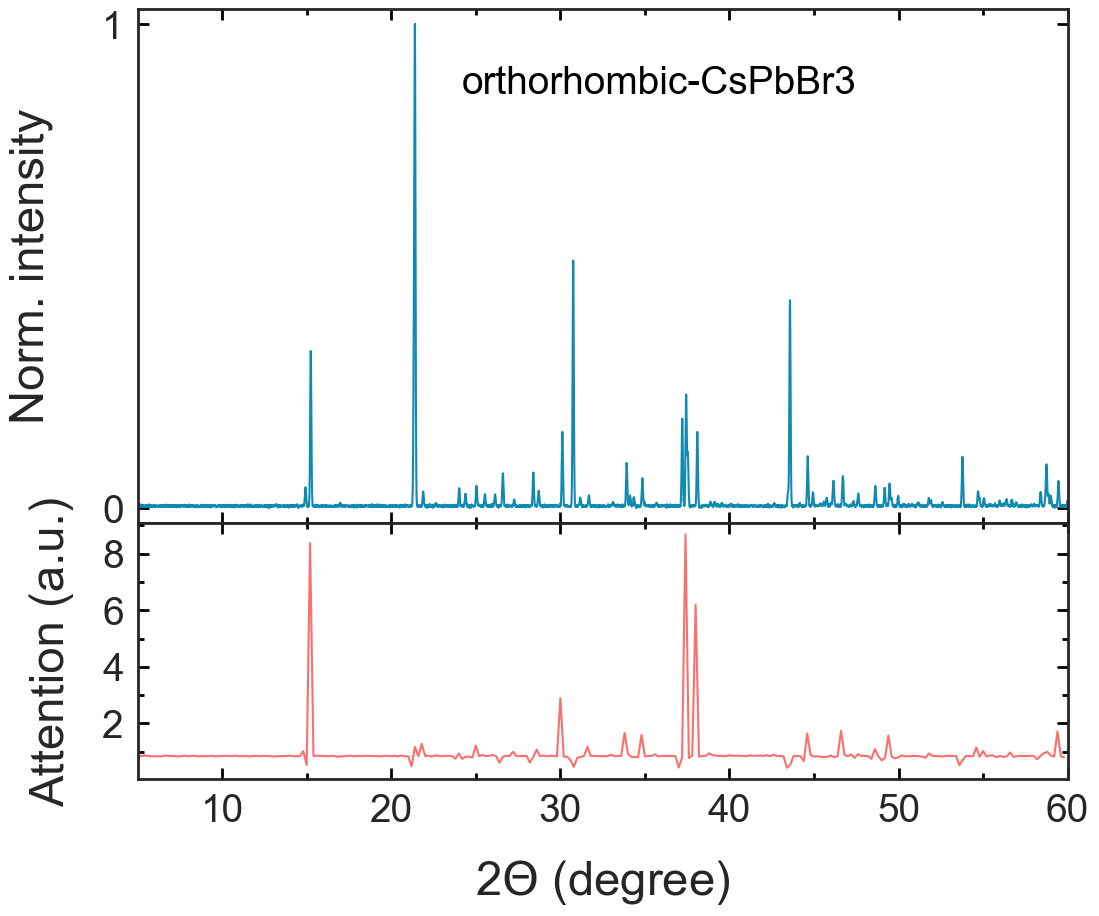

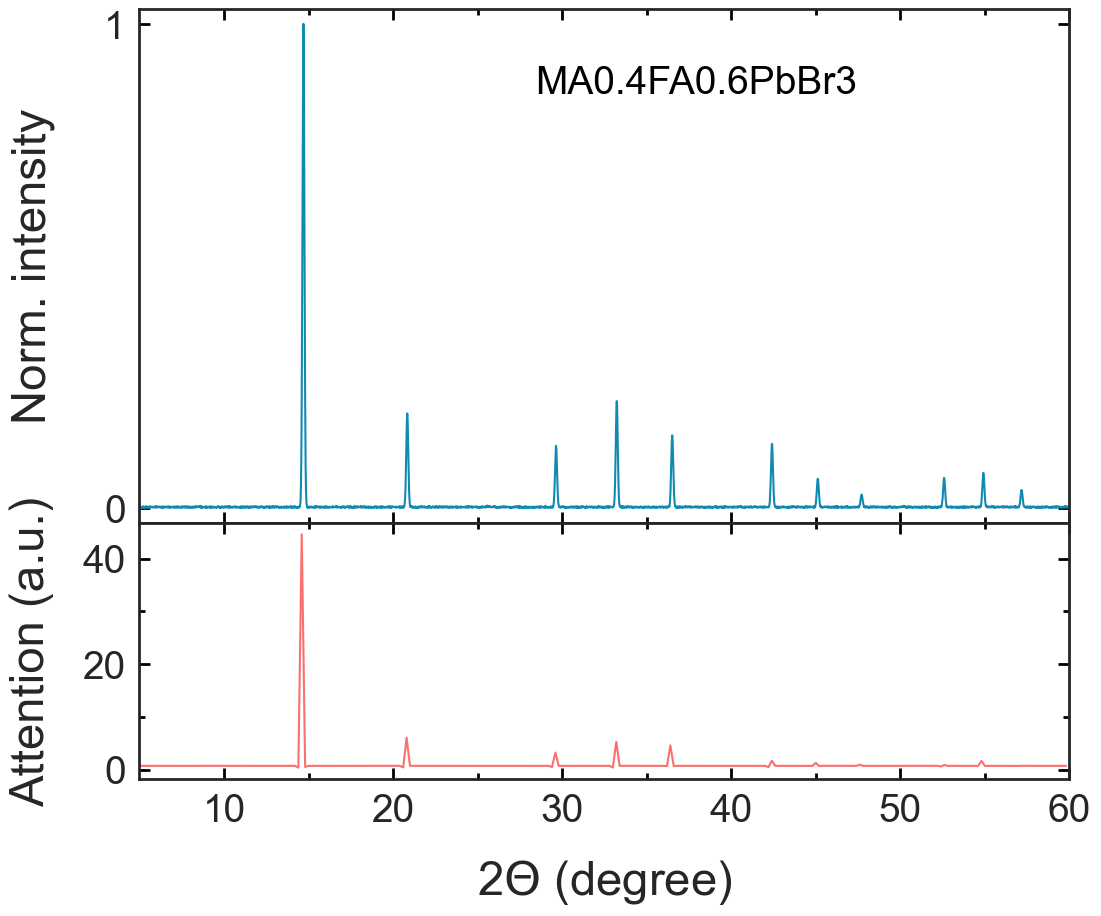

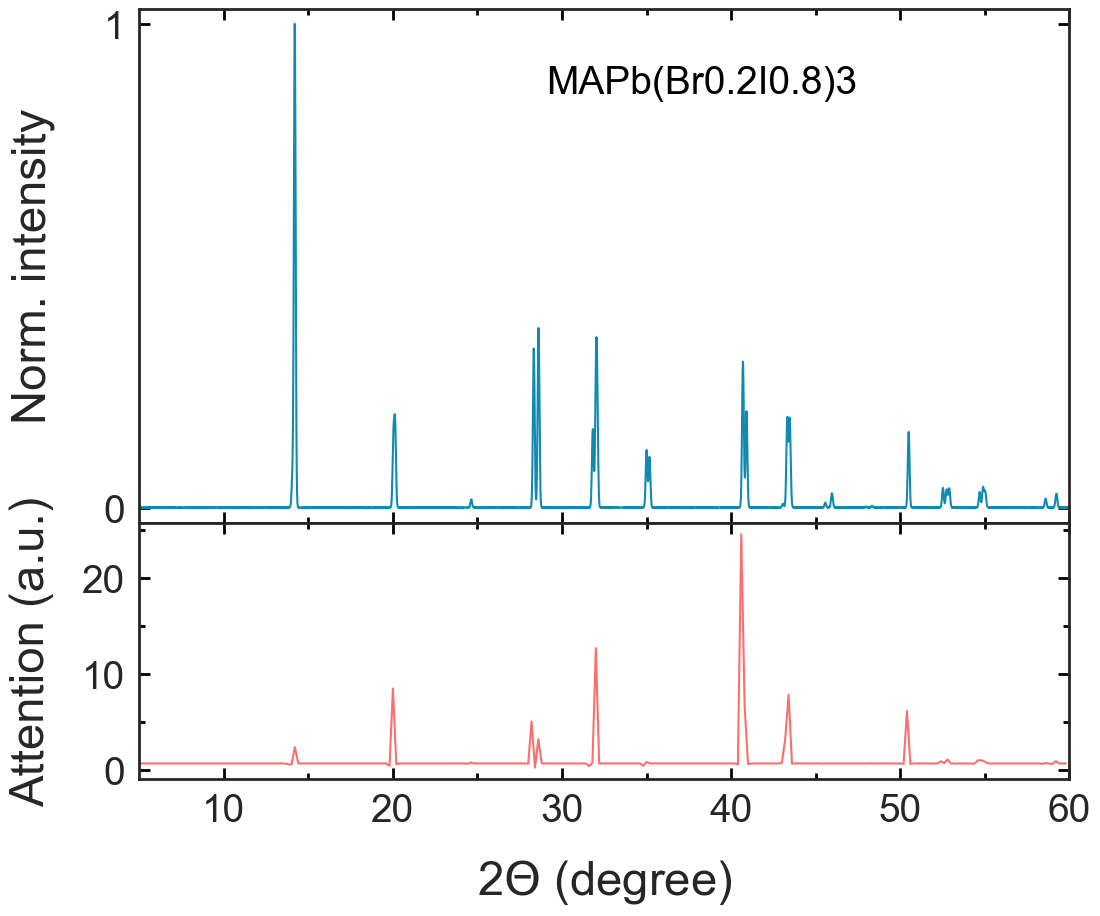

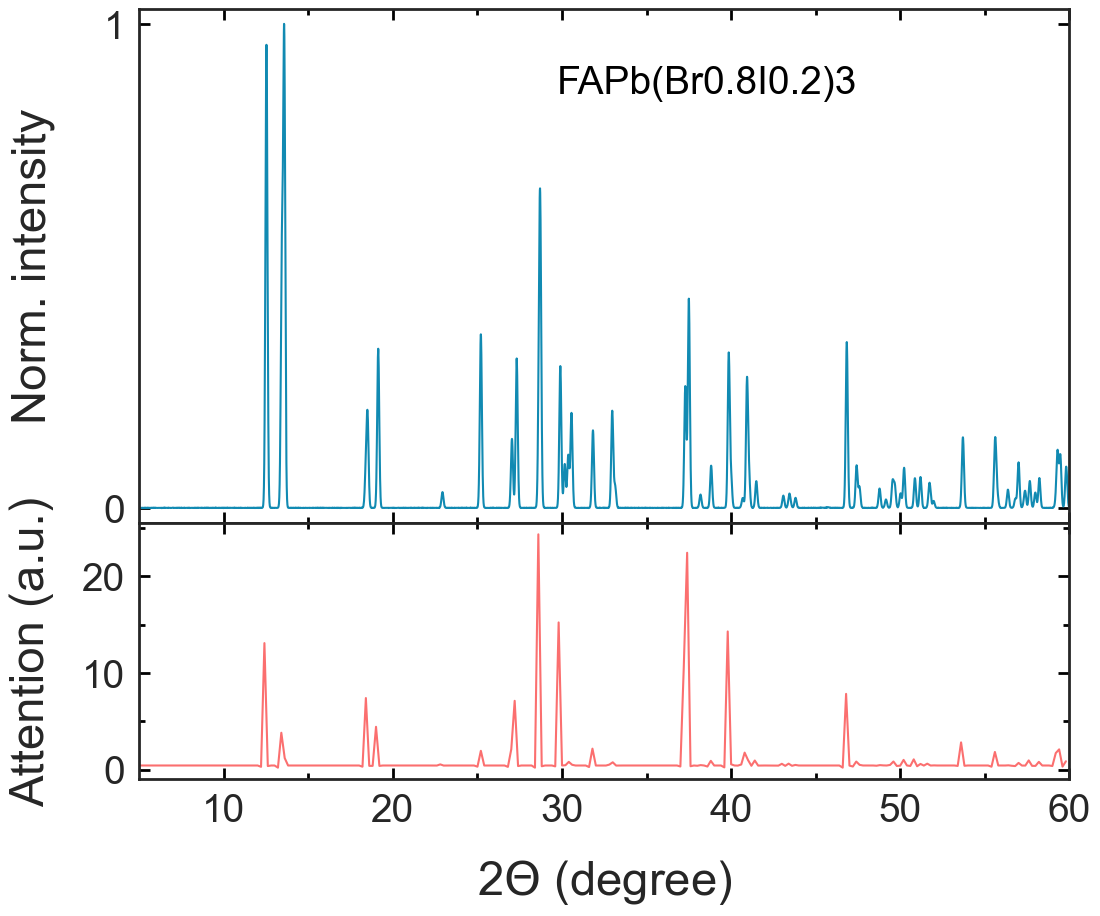

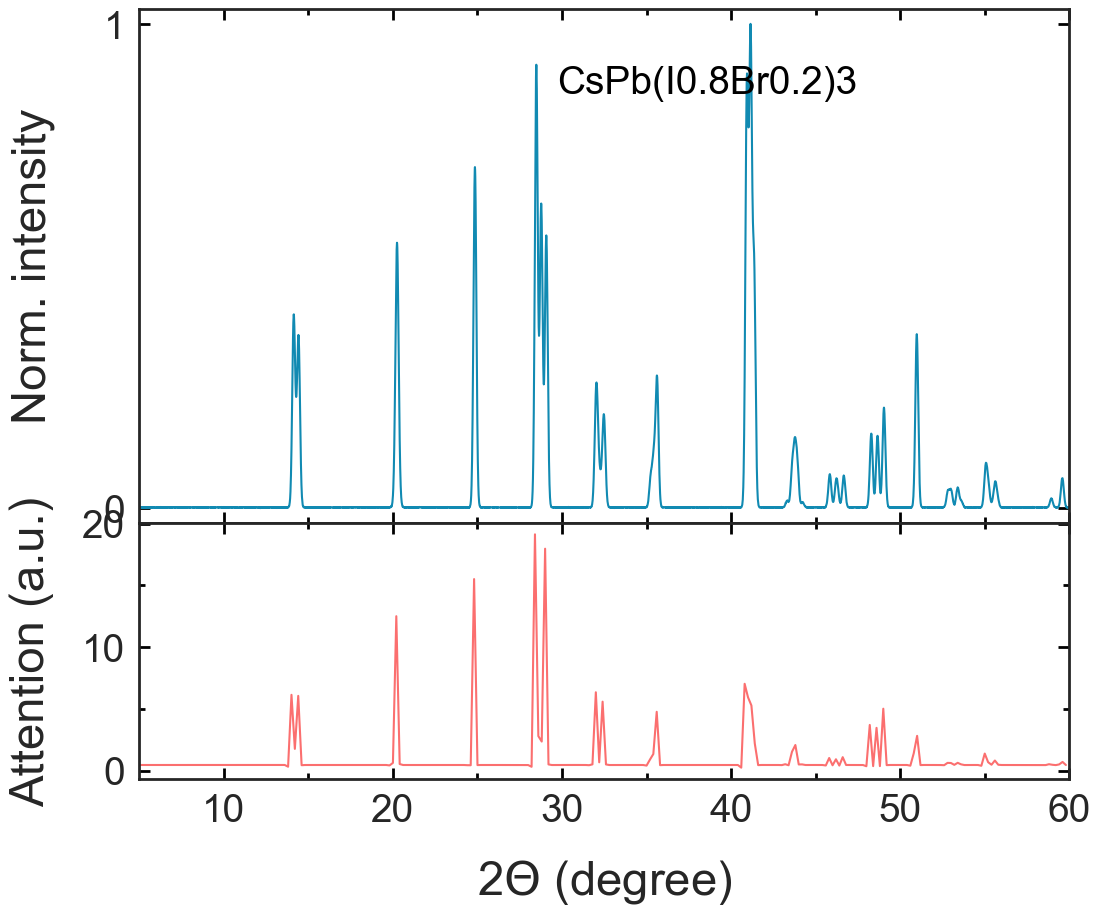

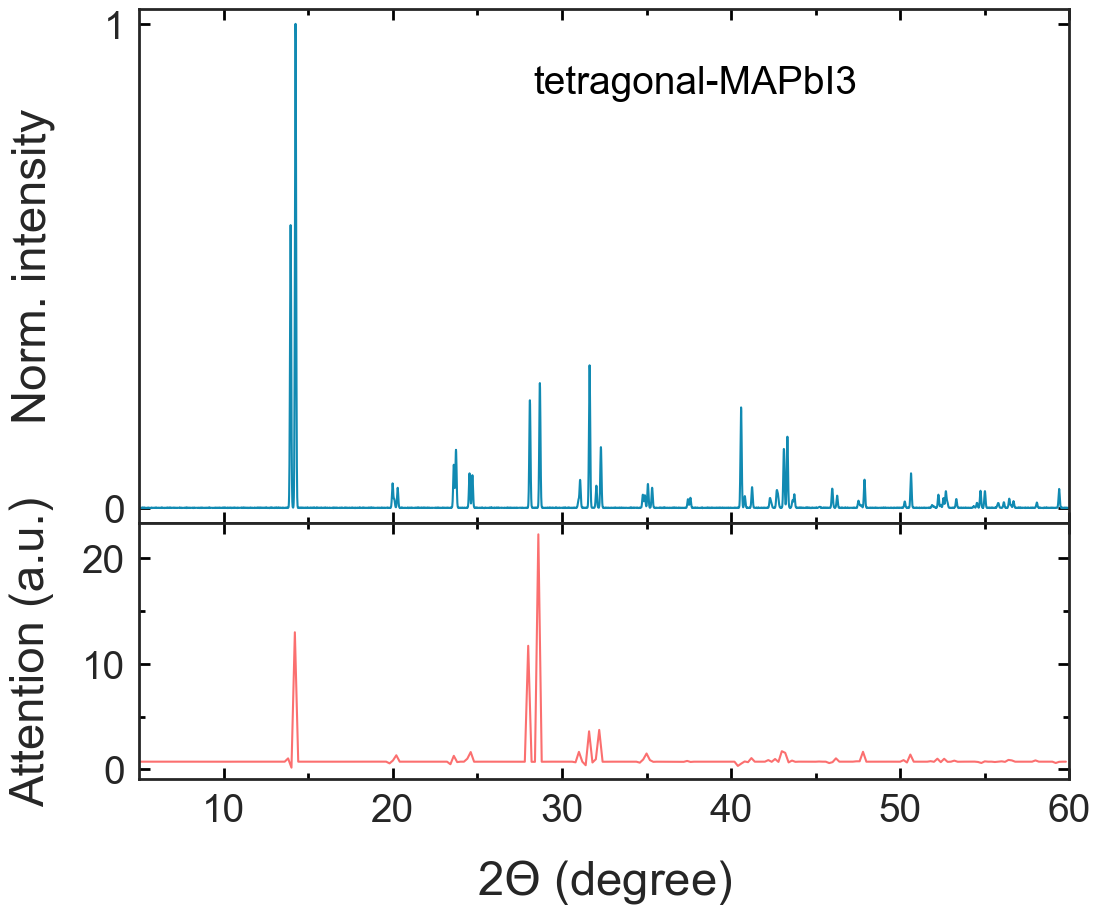

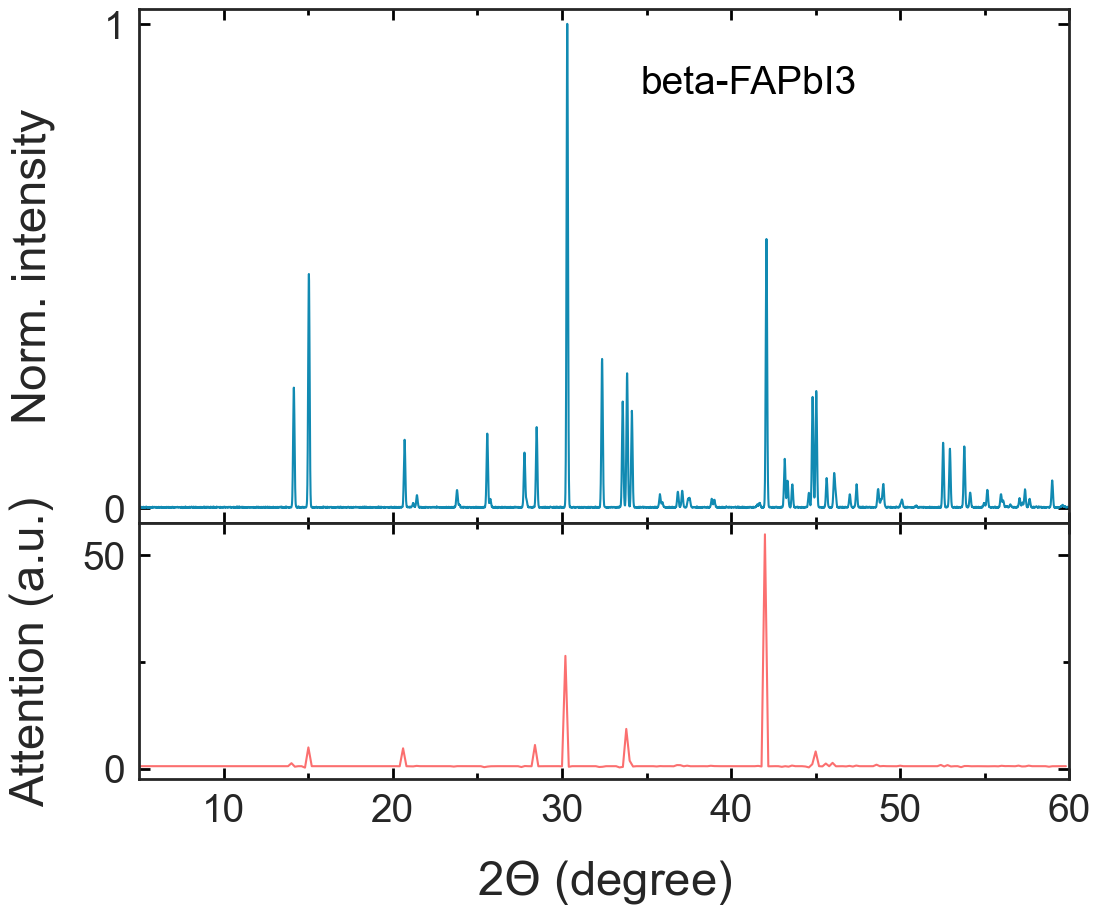

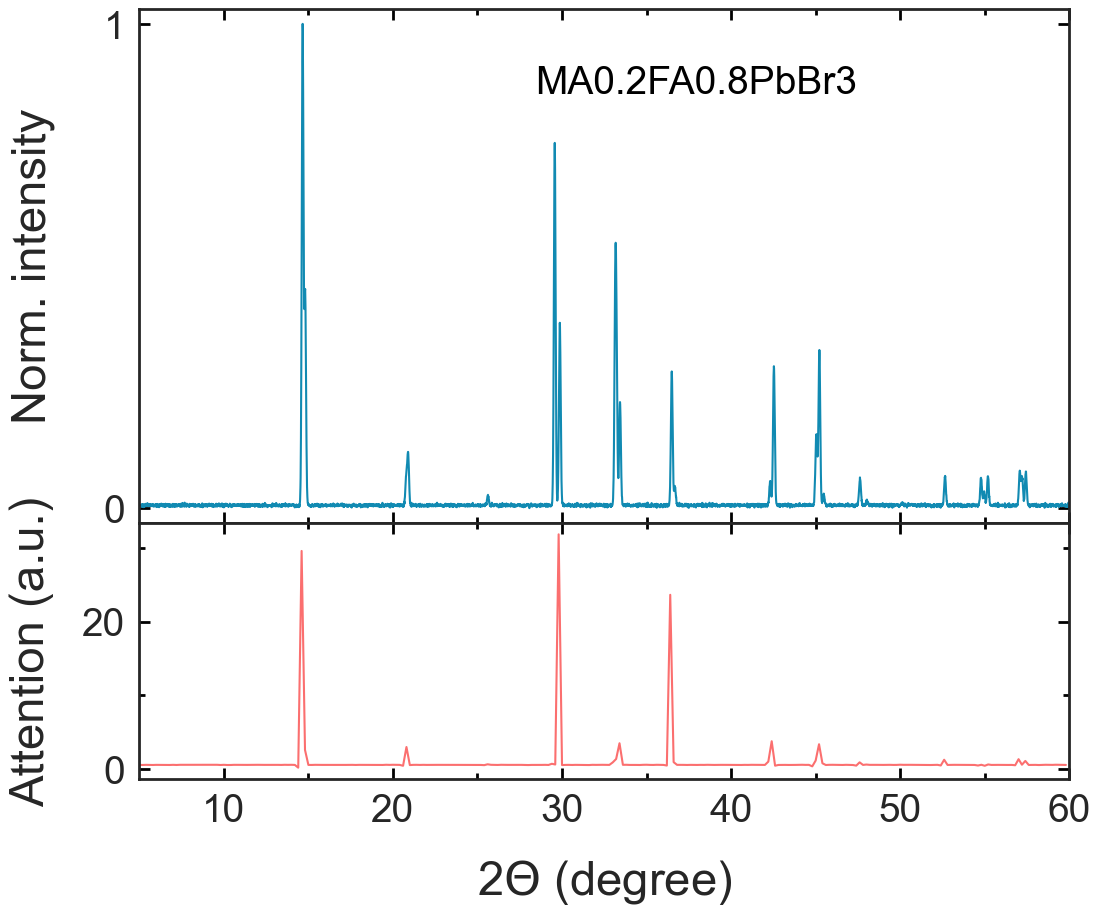

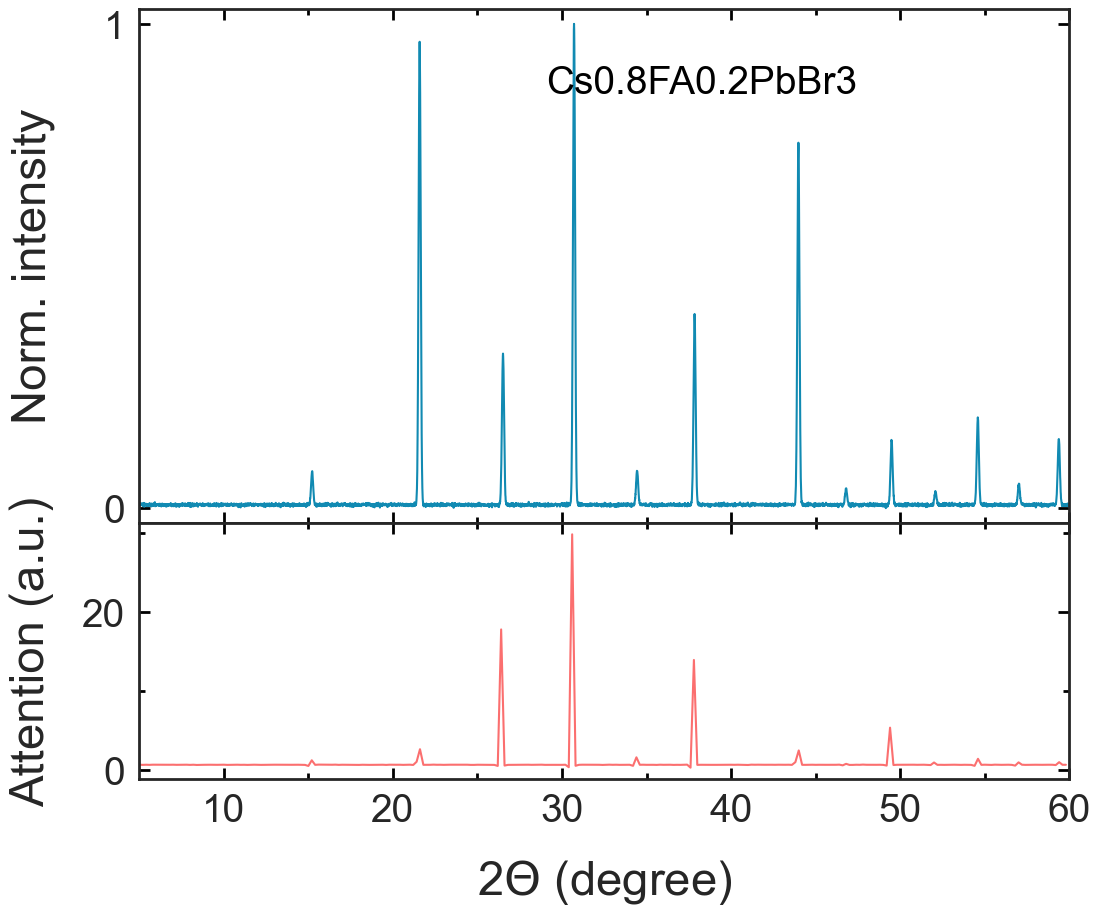

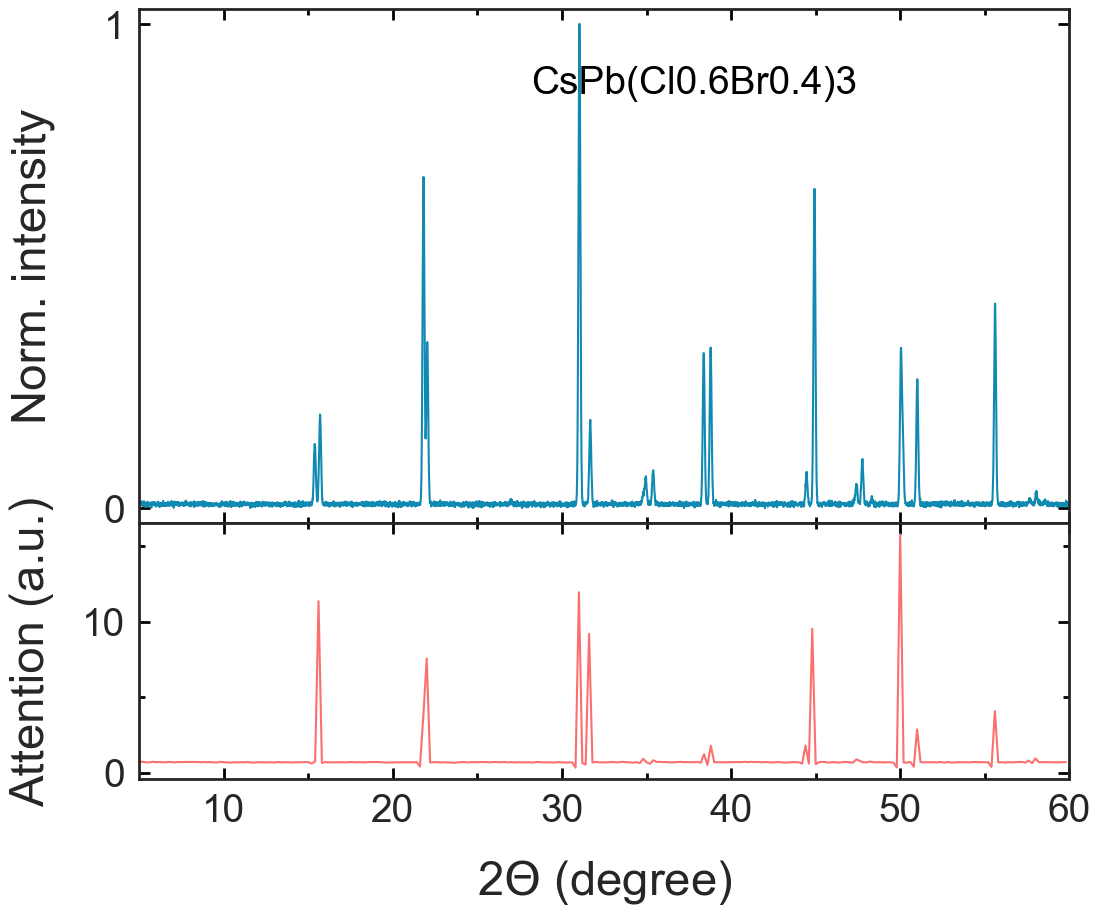

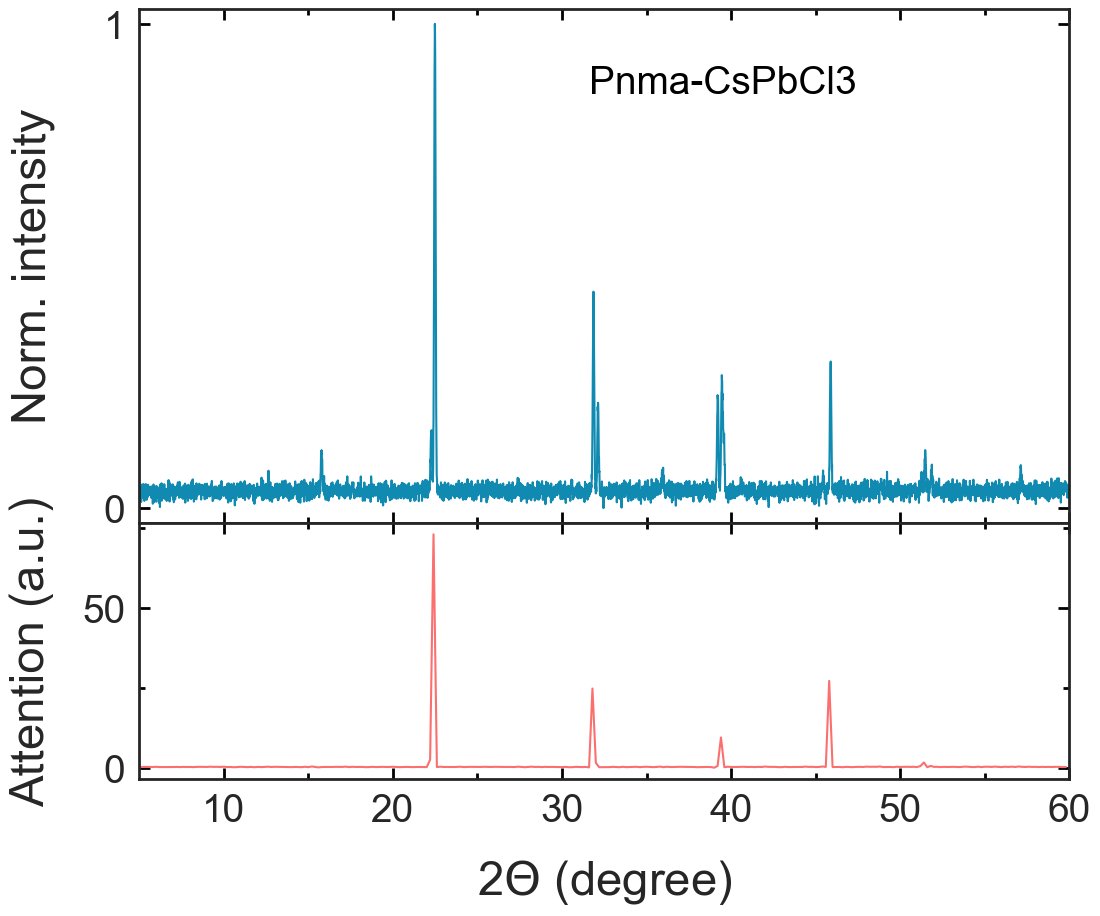

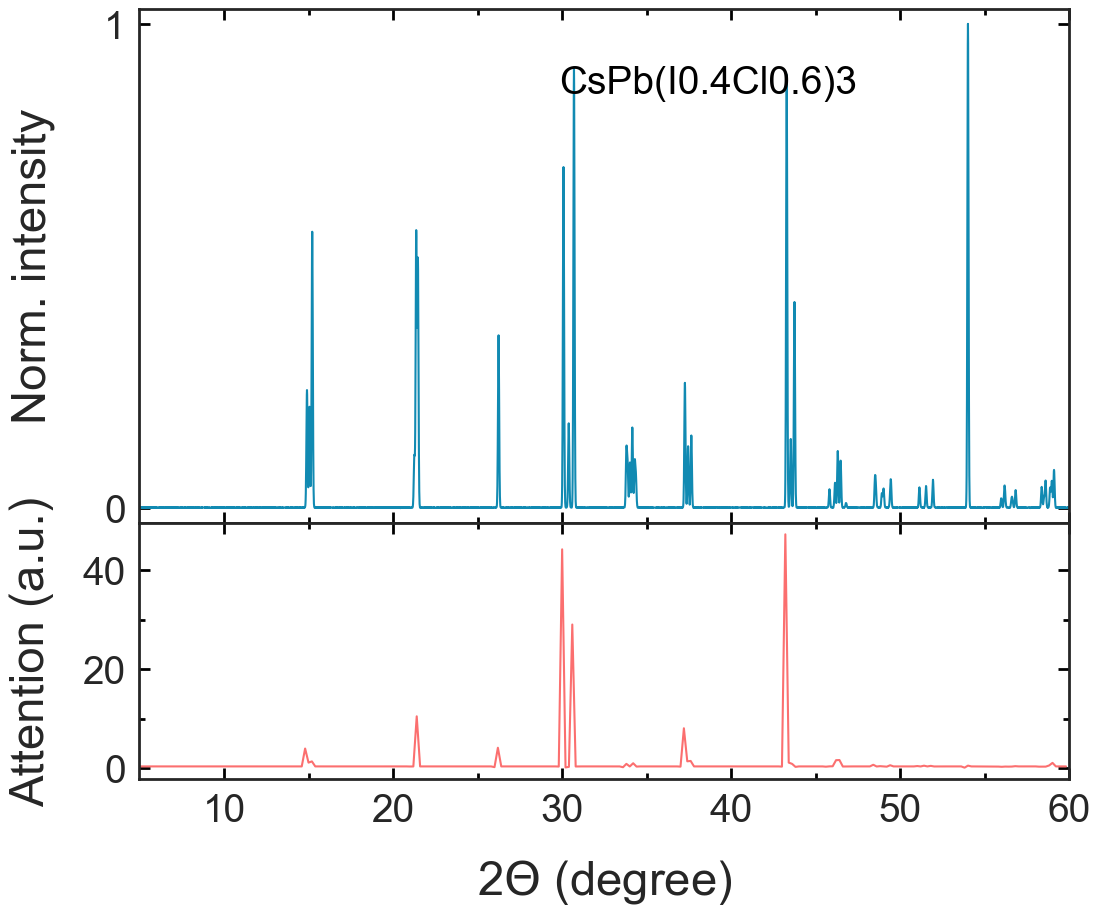

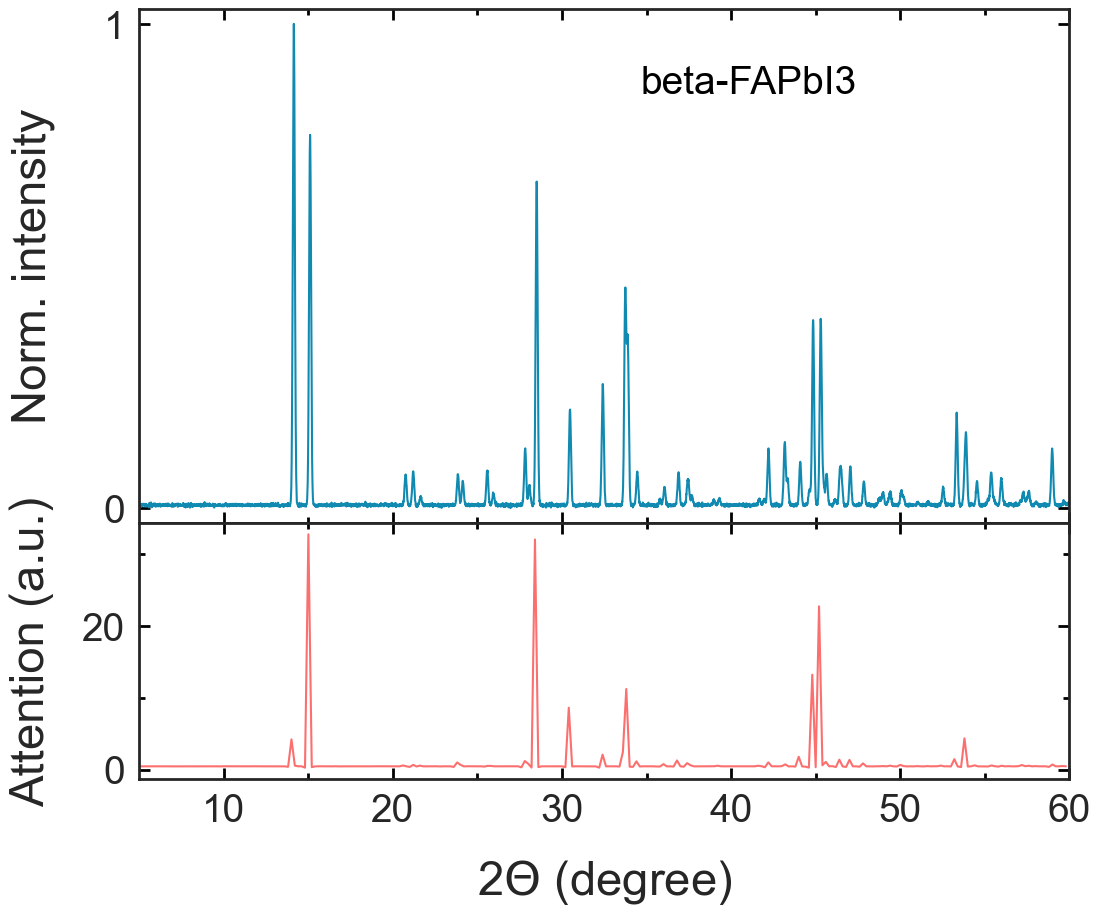

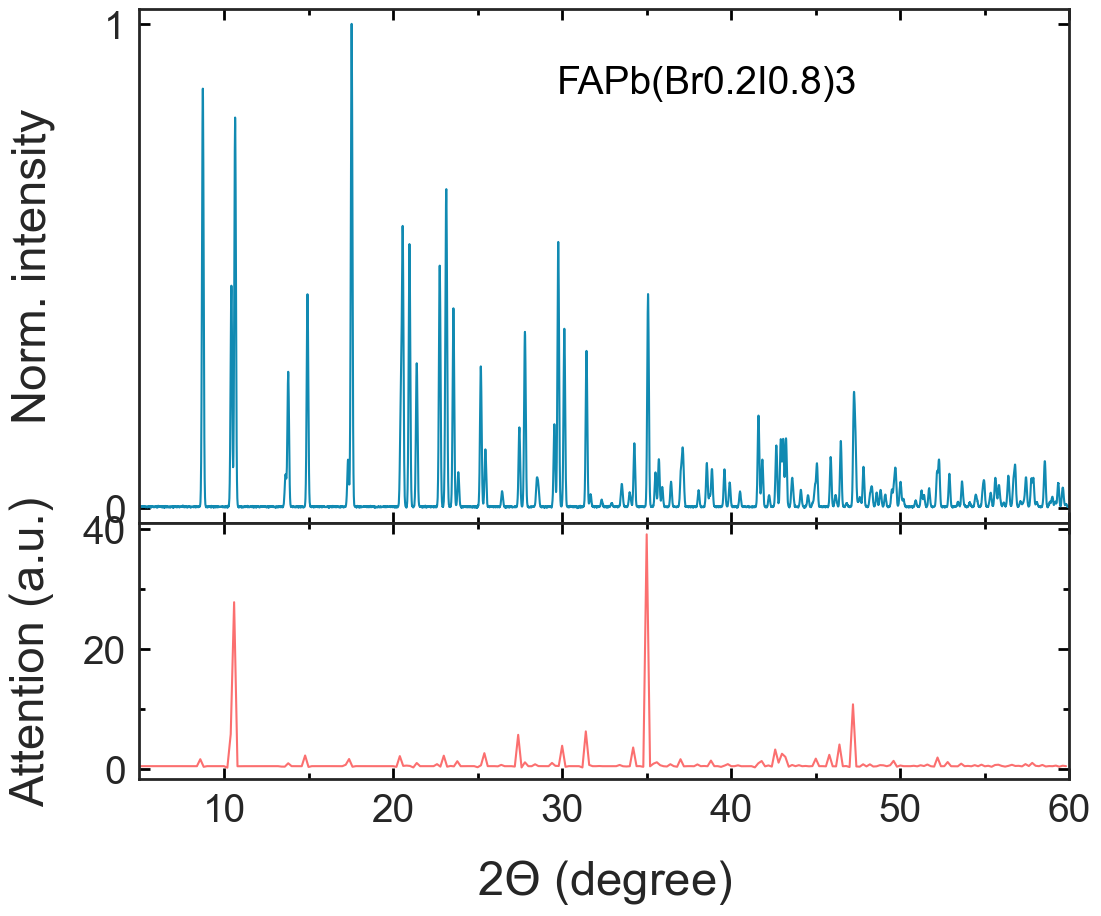

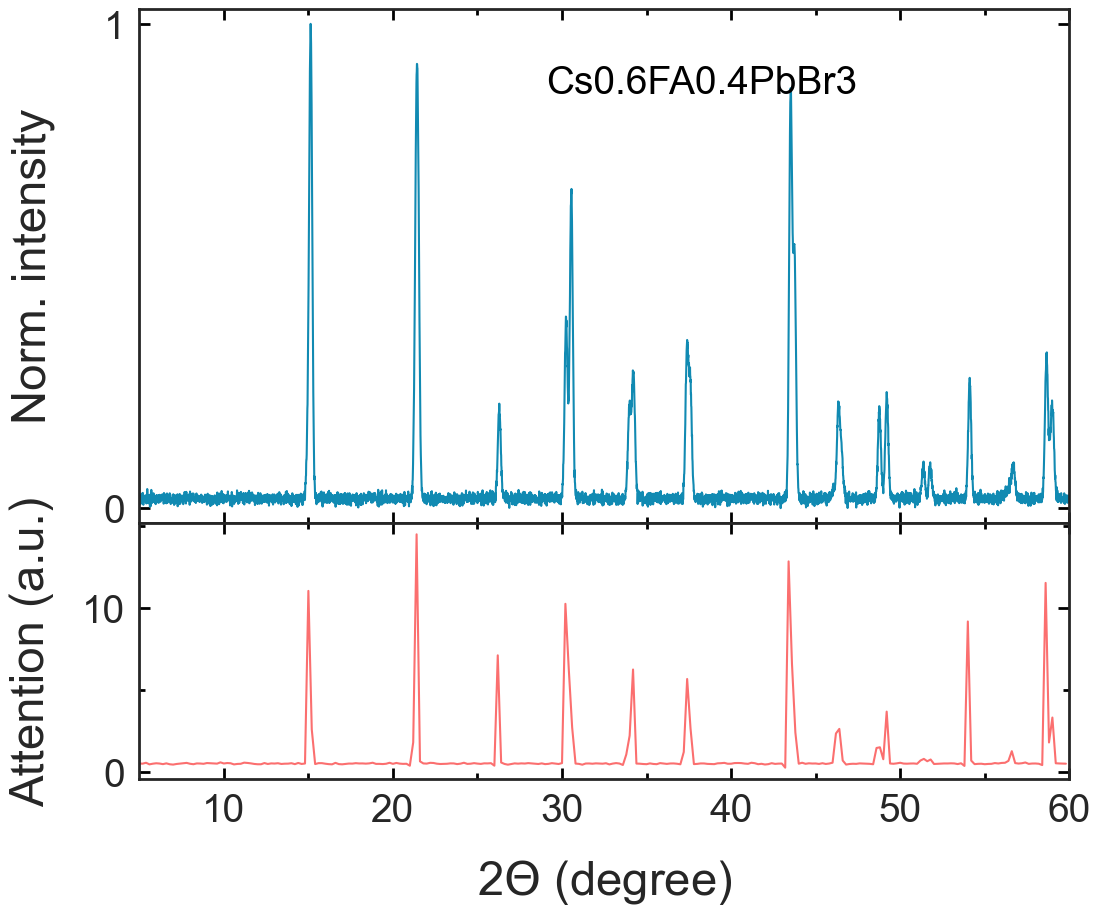

In [291]:
for i in range(20):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))

    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,len(inputs['input_ids'][0]):,len(inputs['input_ids'][0]):]

    load_plt_setting()

    fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[2, 1]),figsize=(12, 10))

    ax0.plot(np.arange(5.00, 60.01, 0.01)[:-1], Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=1, steps=[1, 2, 5, 10]))
#     ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.03,1.03])
    ax0.set_ylabel(r'Norm. intensity', labelpad=35, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.sum(Y, axis=0), color=colors.to_rgba('#fb6f6f'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.axes.set_xlim([5,60])
#     ax1.axes.set_ylim([0,25])

    ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax1.set_ylabel(r'Attention (a.u.)', labelpad=20, fontsize=34)
    plt.text(0.95, 0.94, formula_list[i][0], fontsize=28, transform=ax.transAxes, color='#000000', horizontalalignment='right')
    
    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models','20240905','{}.svg'.format(formula_list[i][0])), format='svg', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


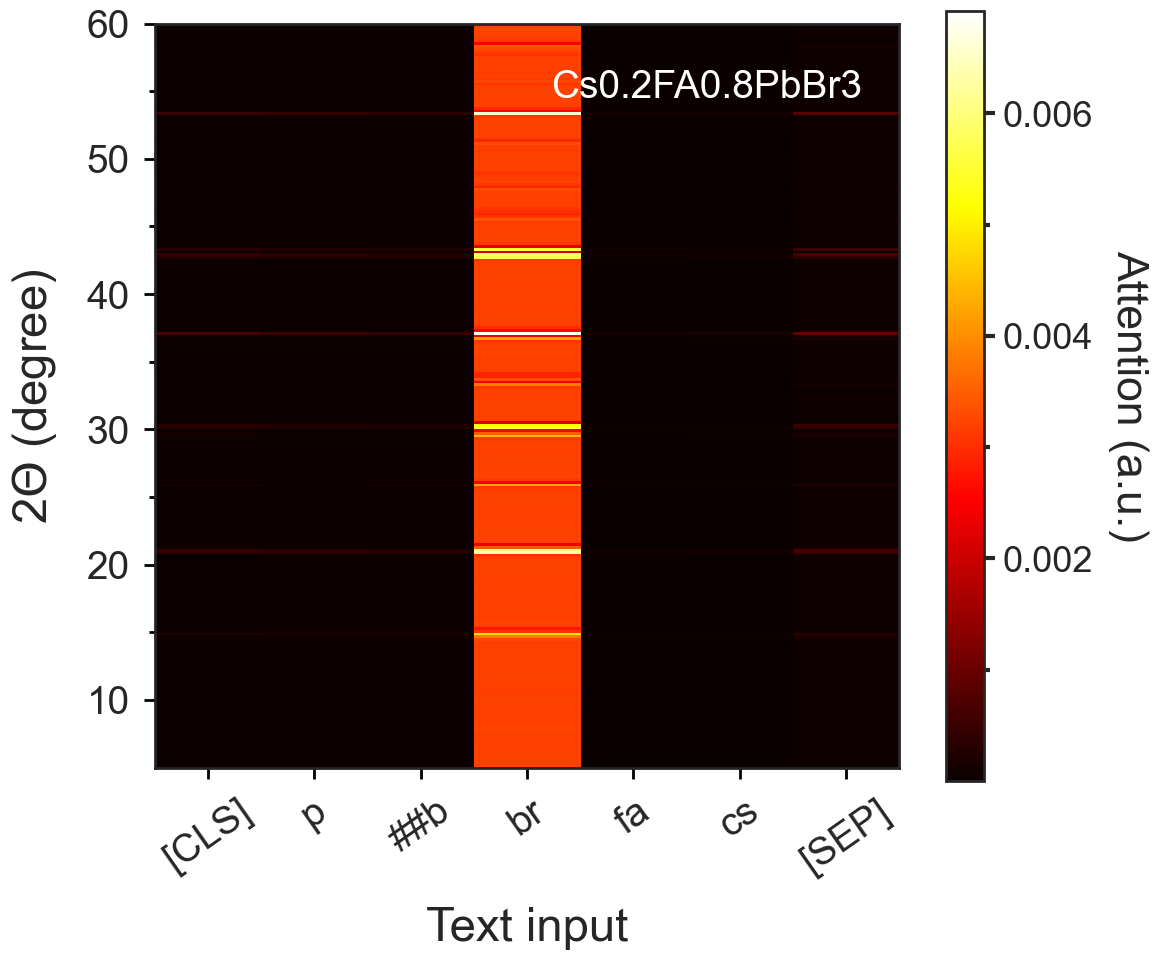

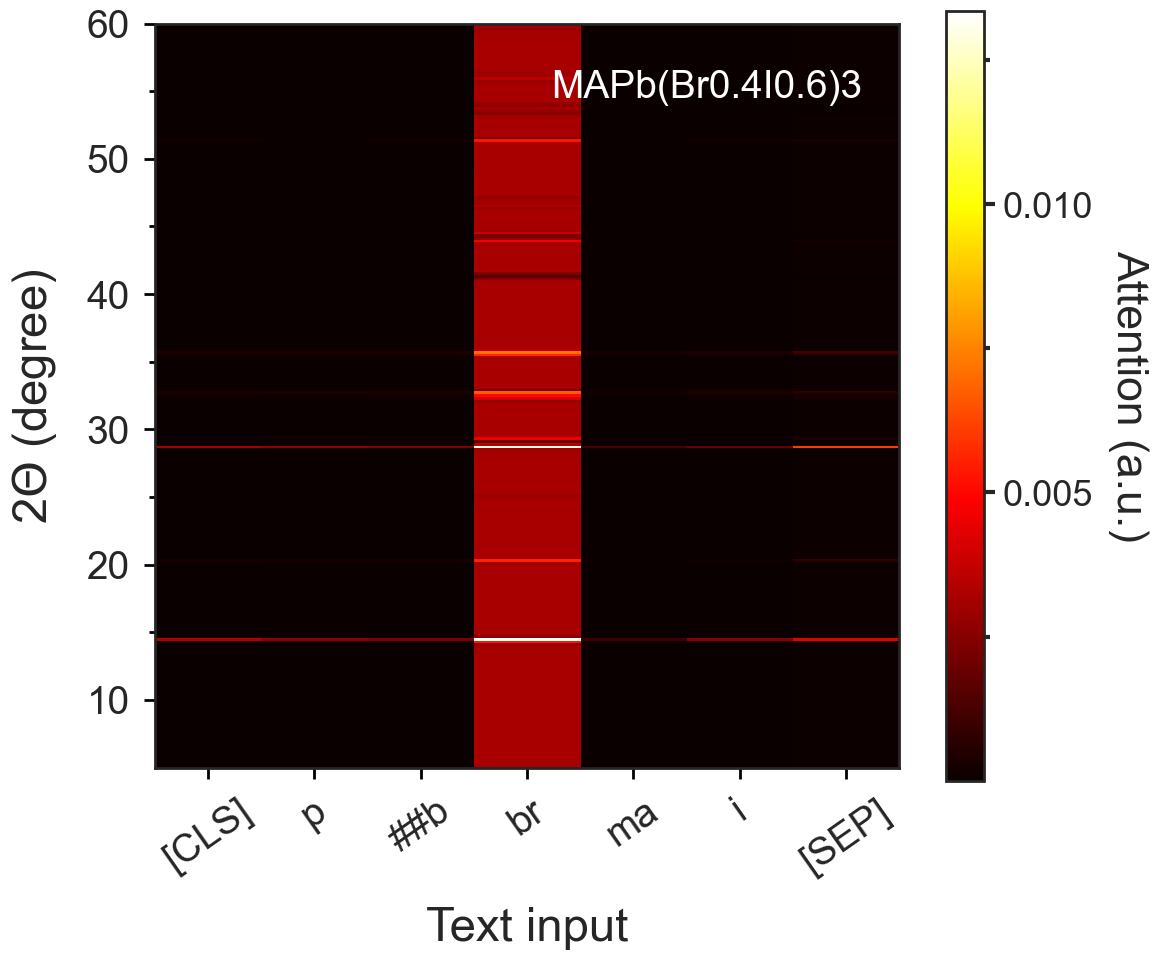

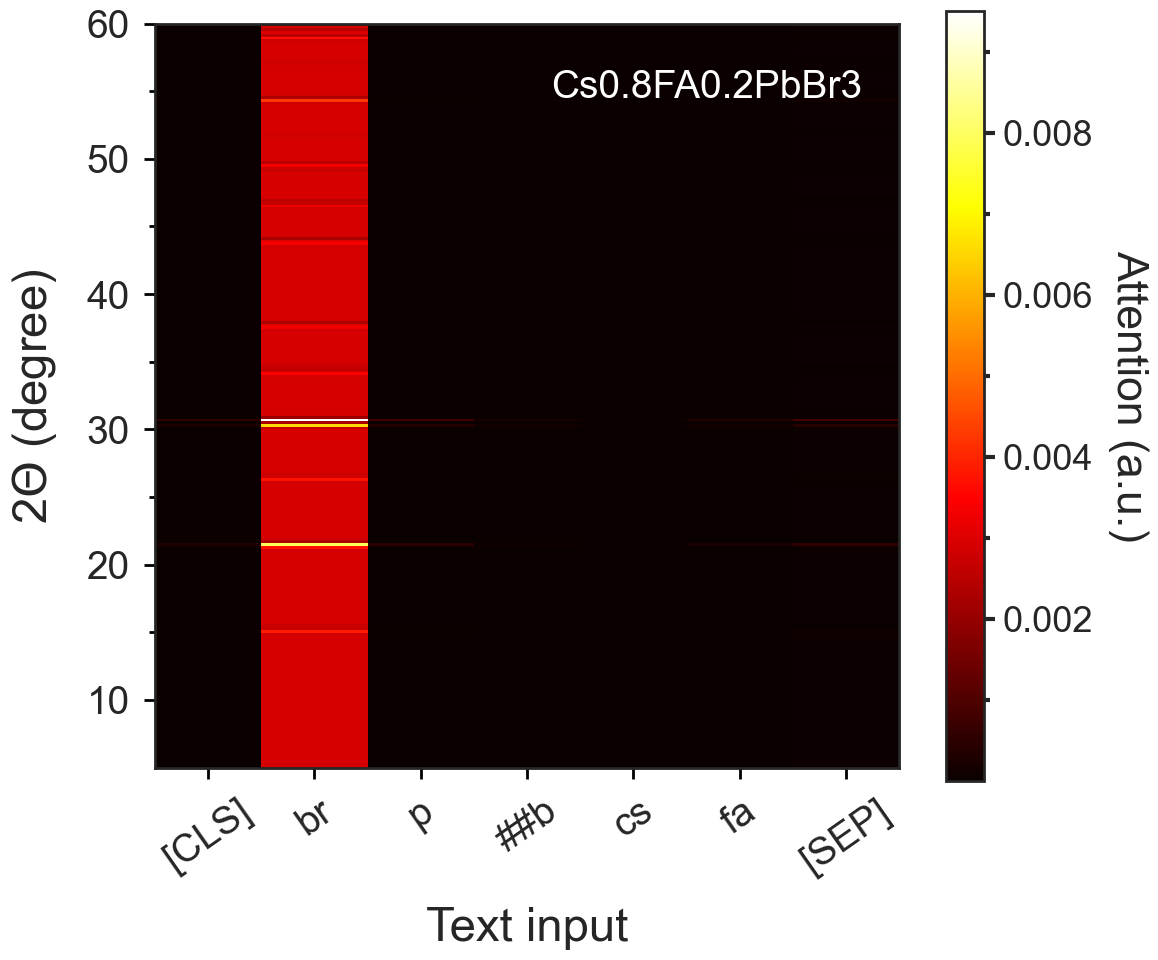

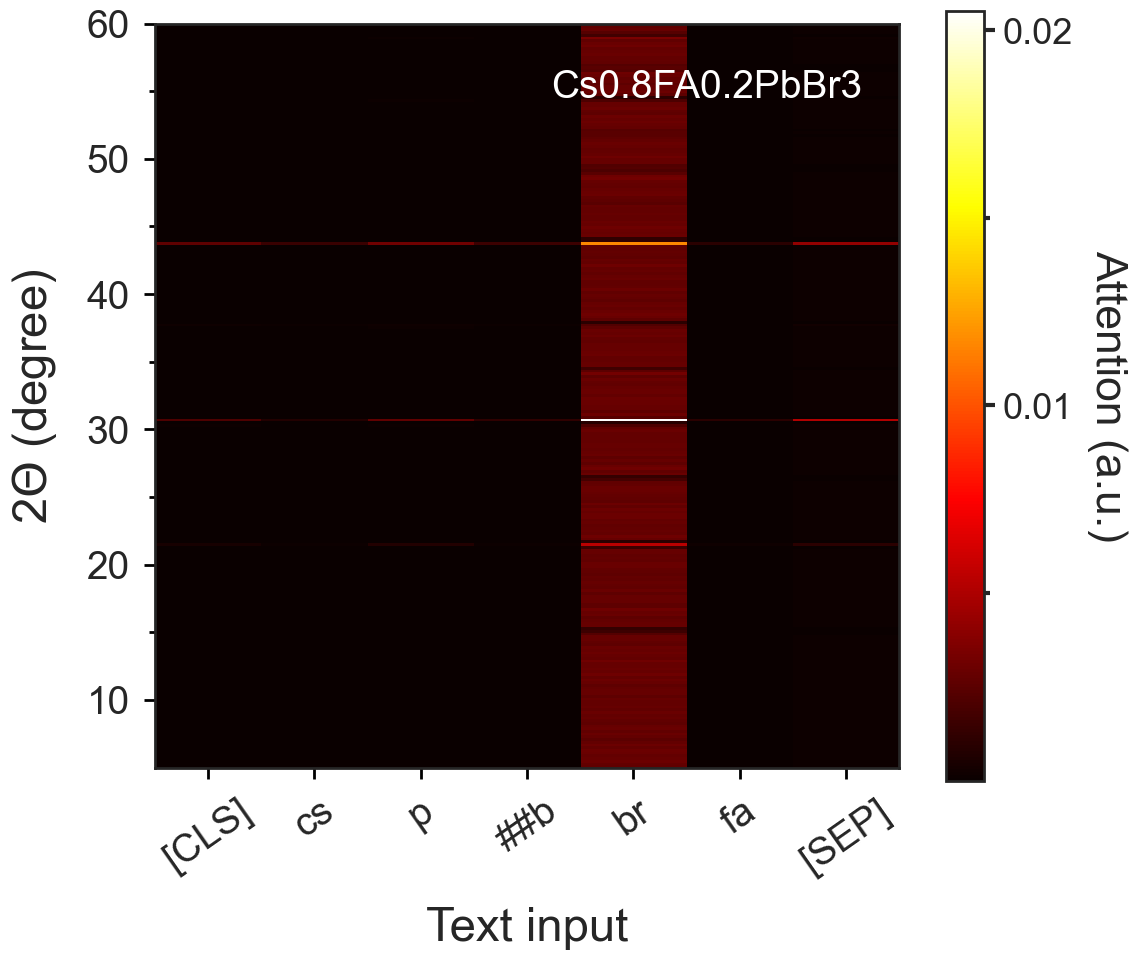

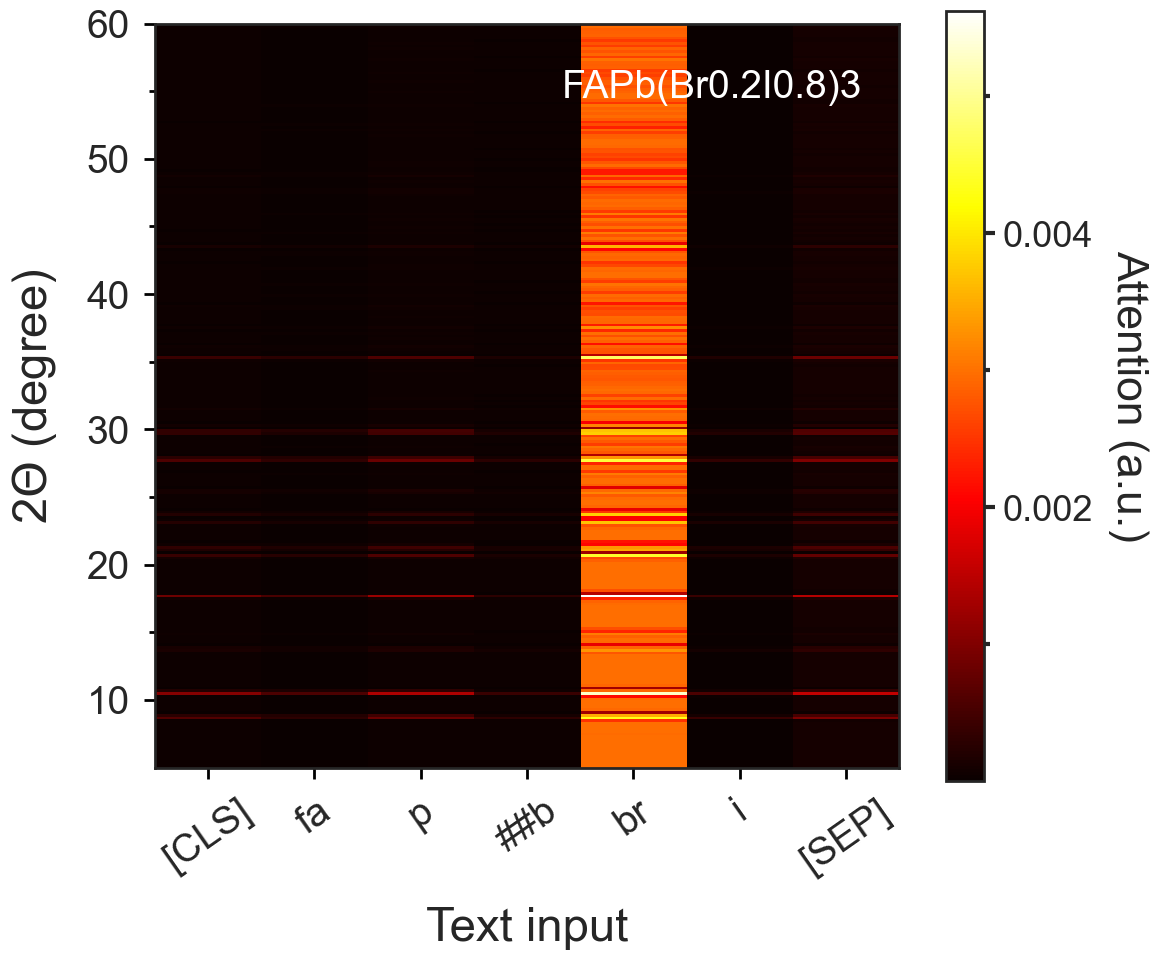

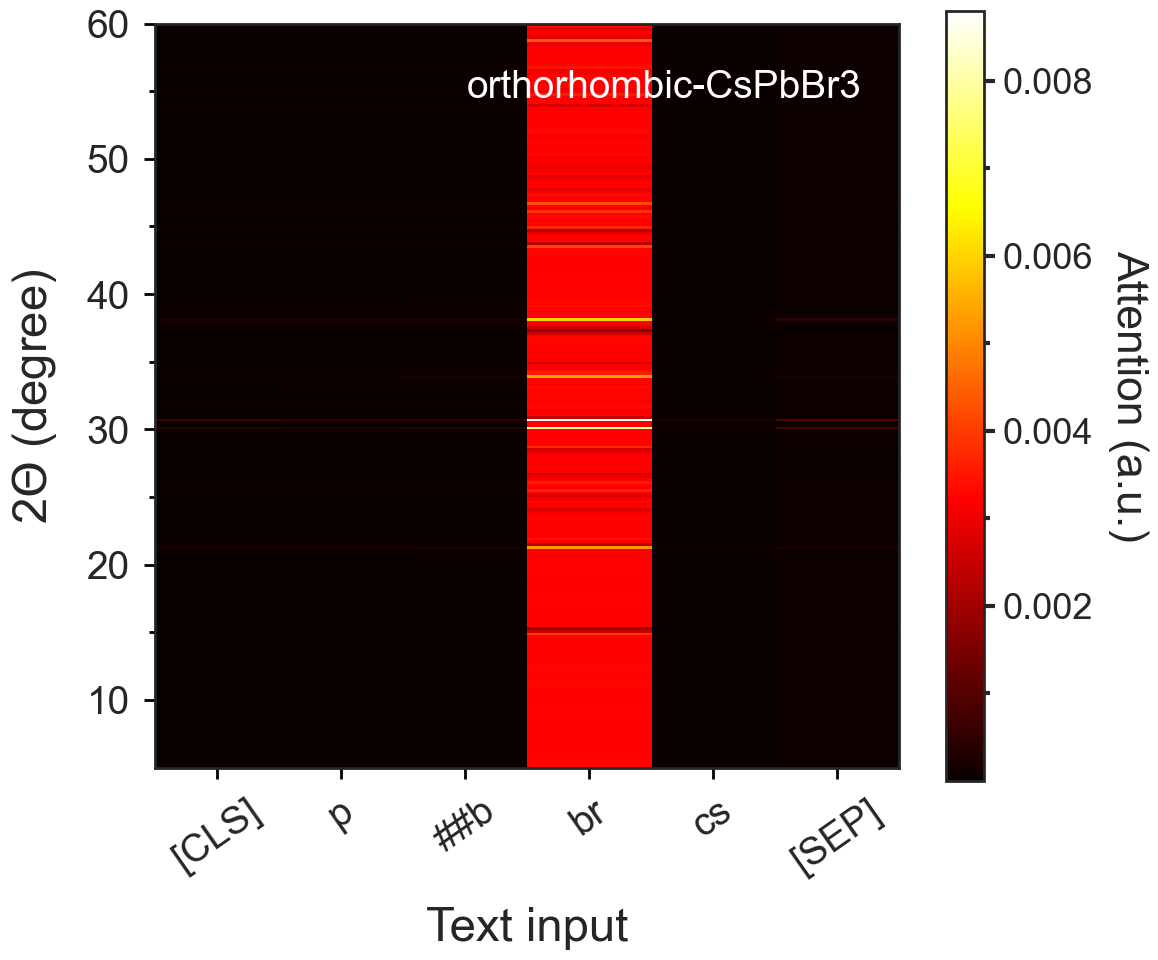

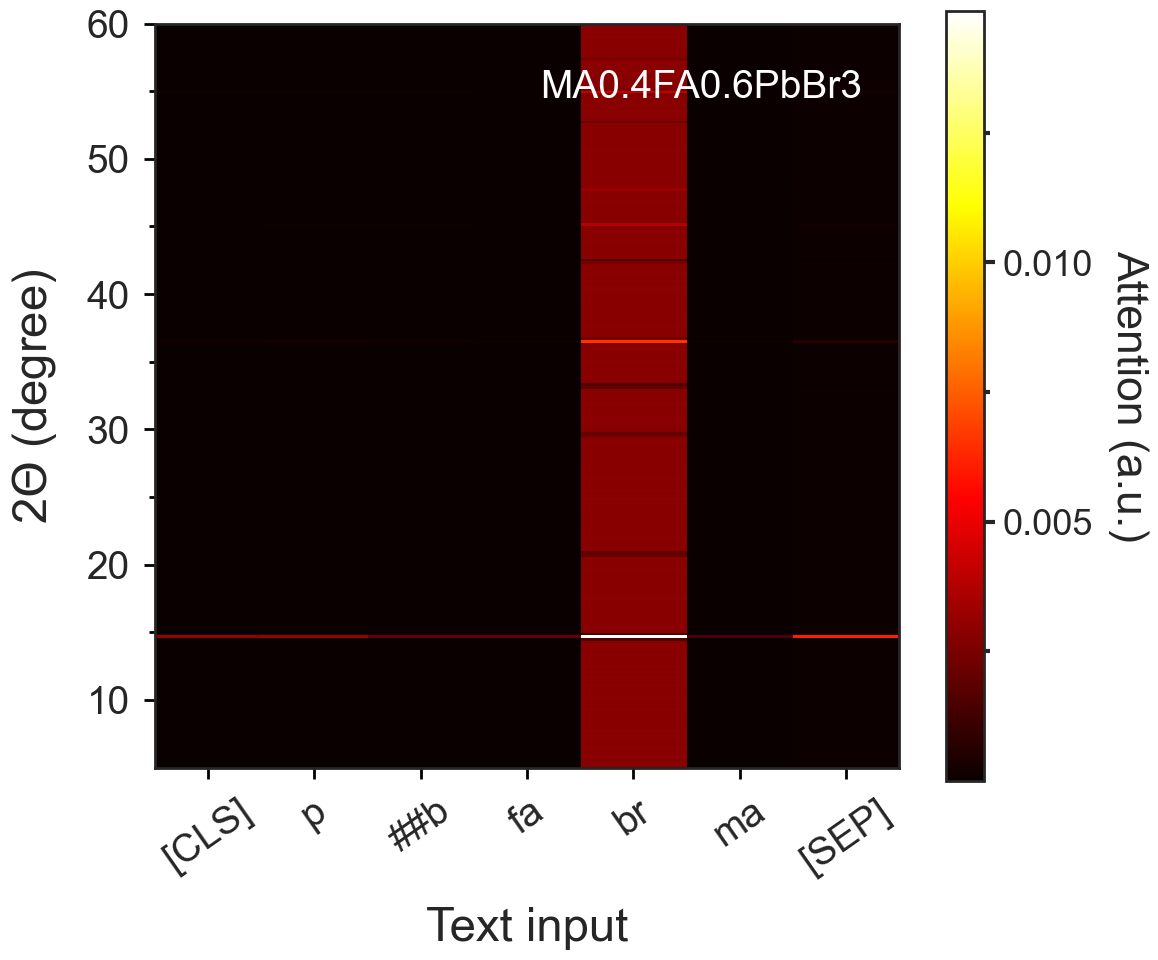

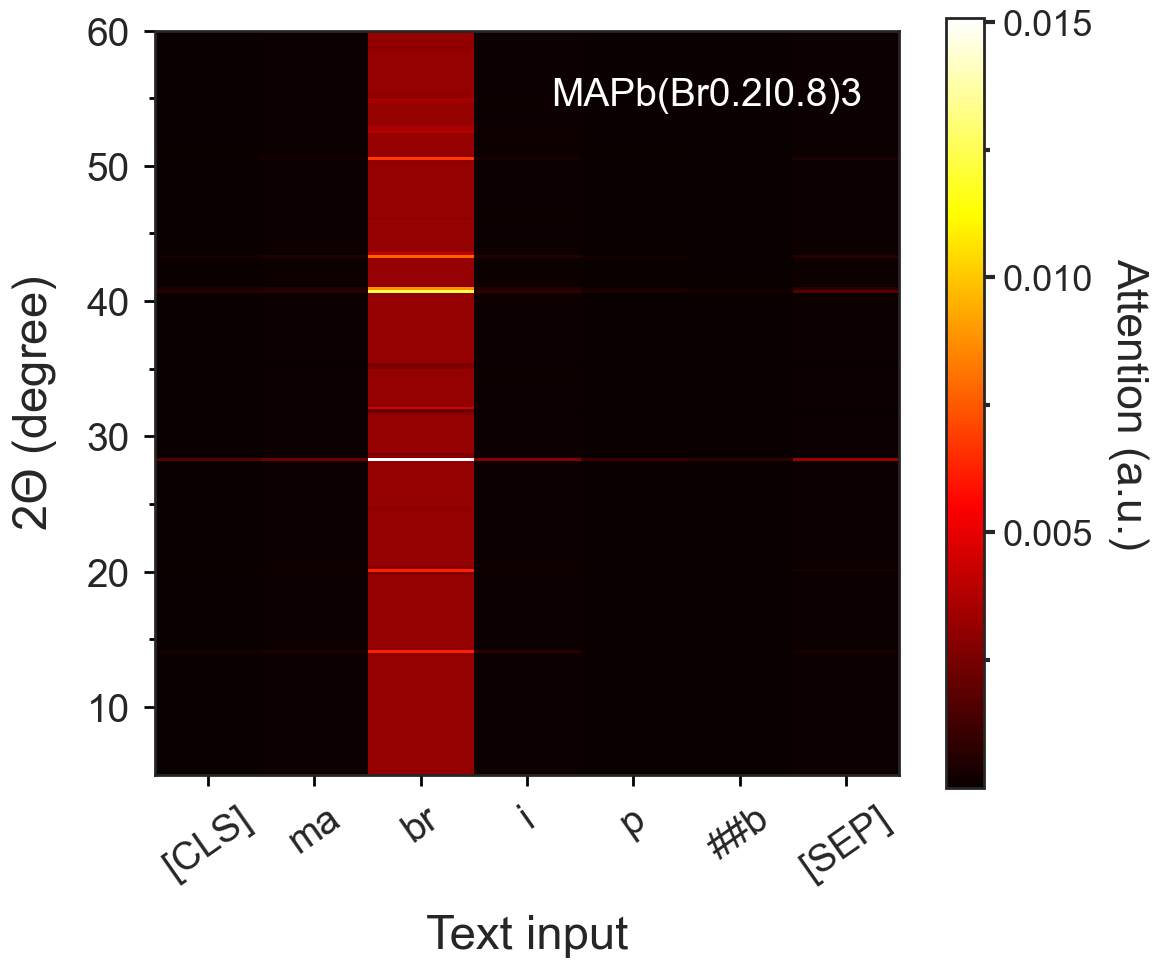

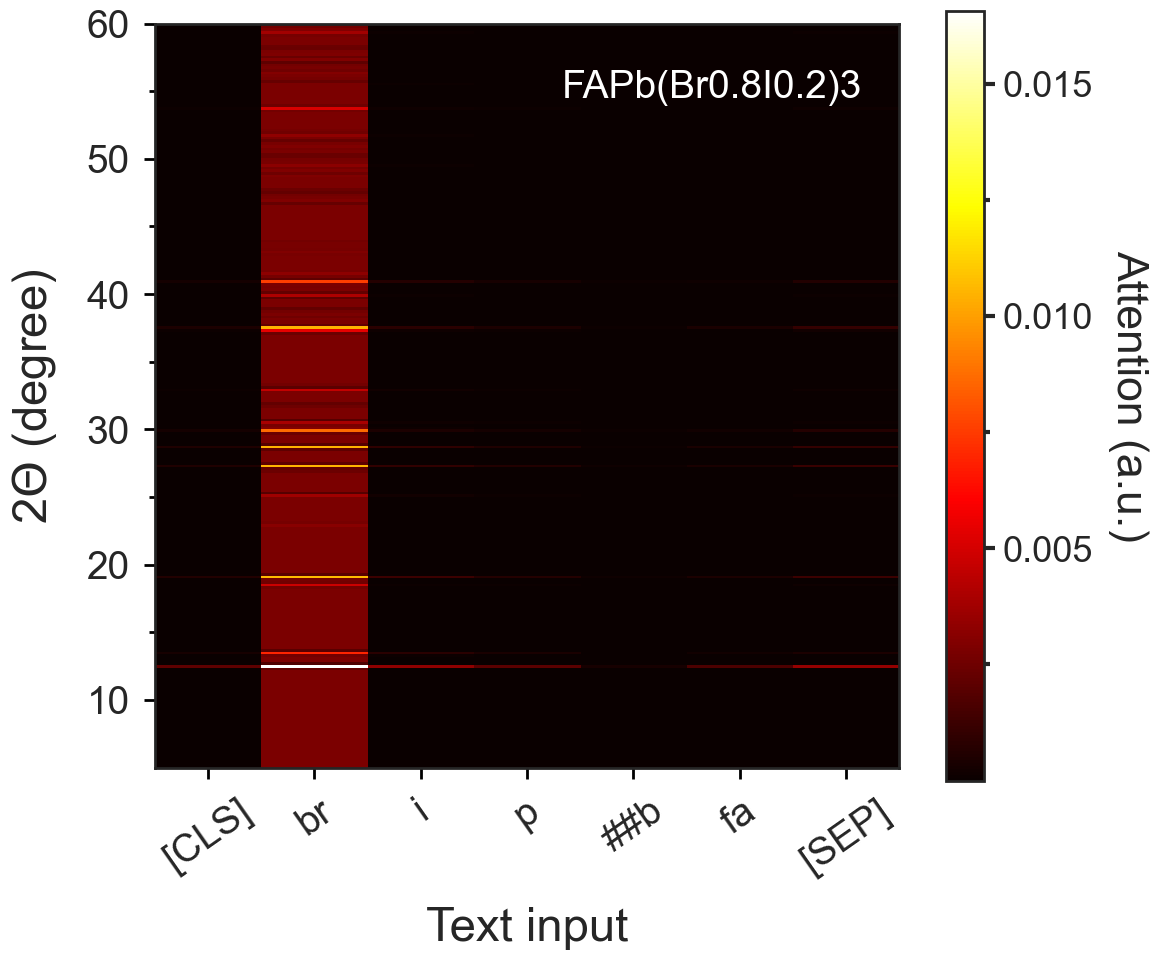

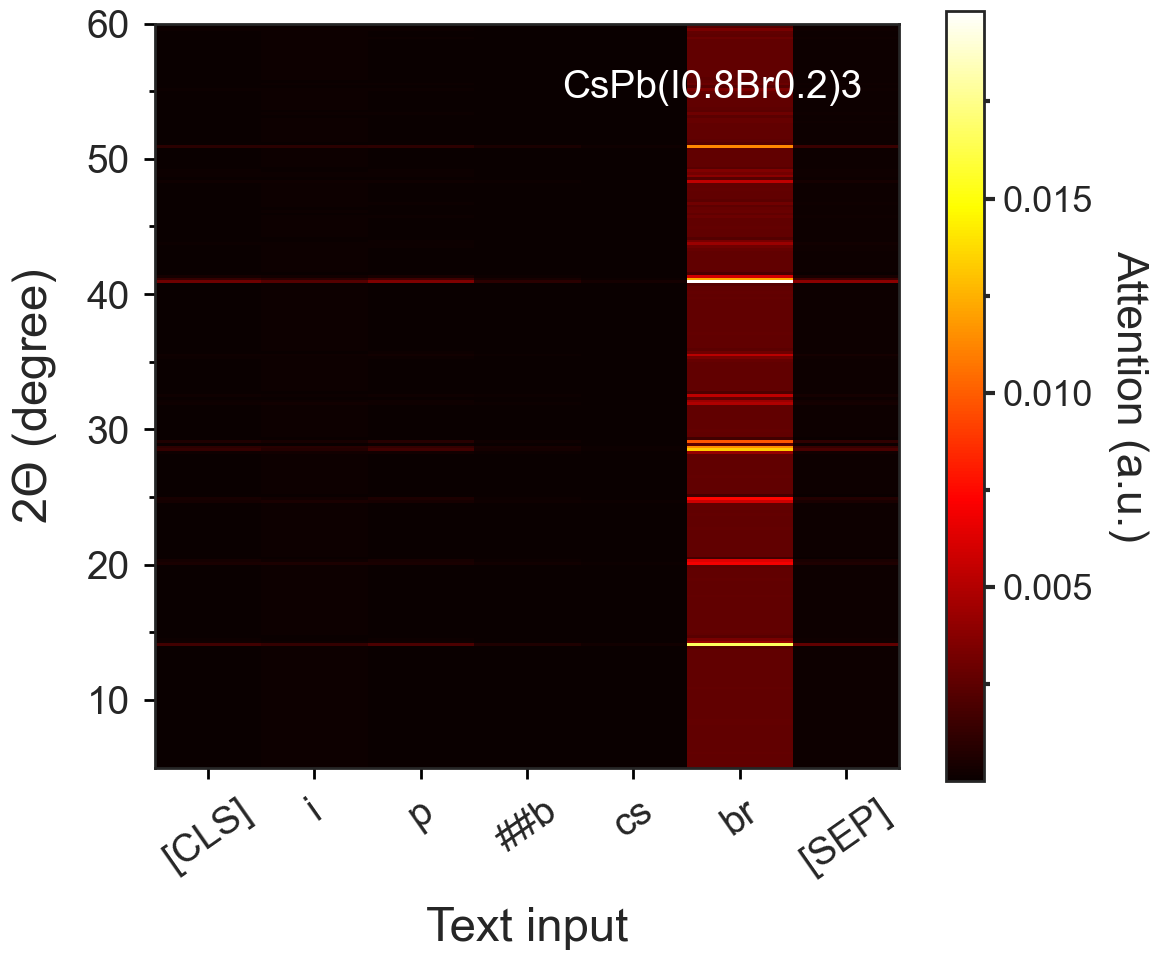

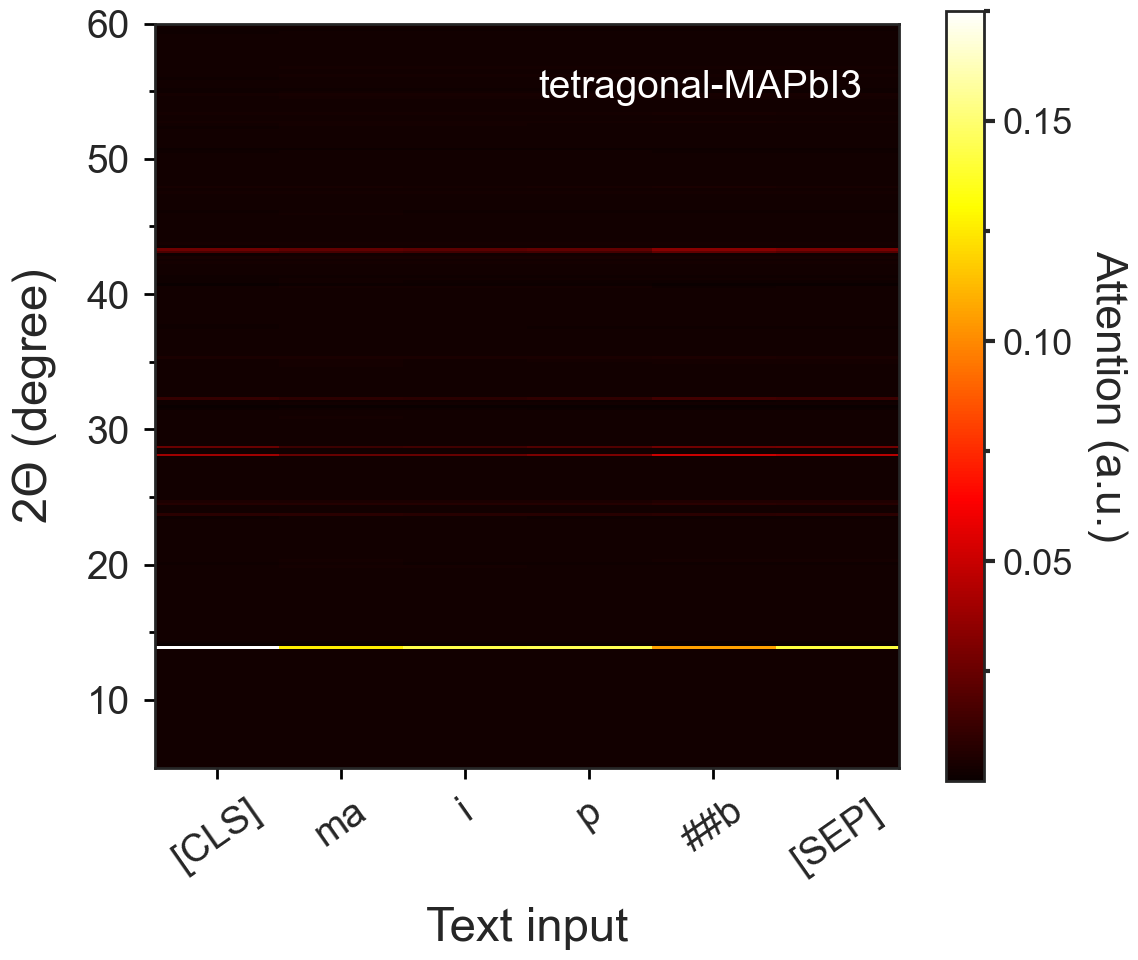

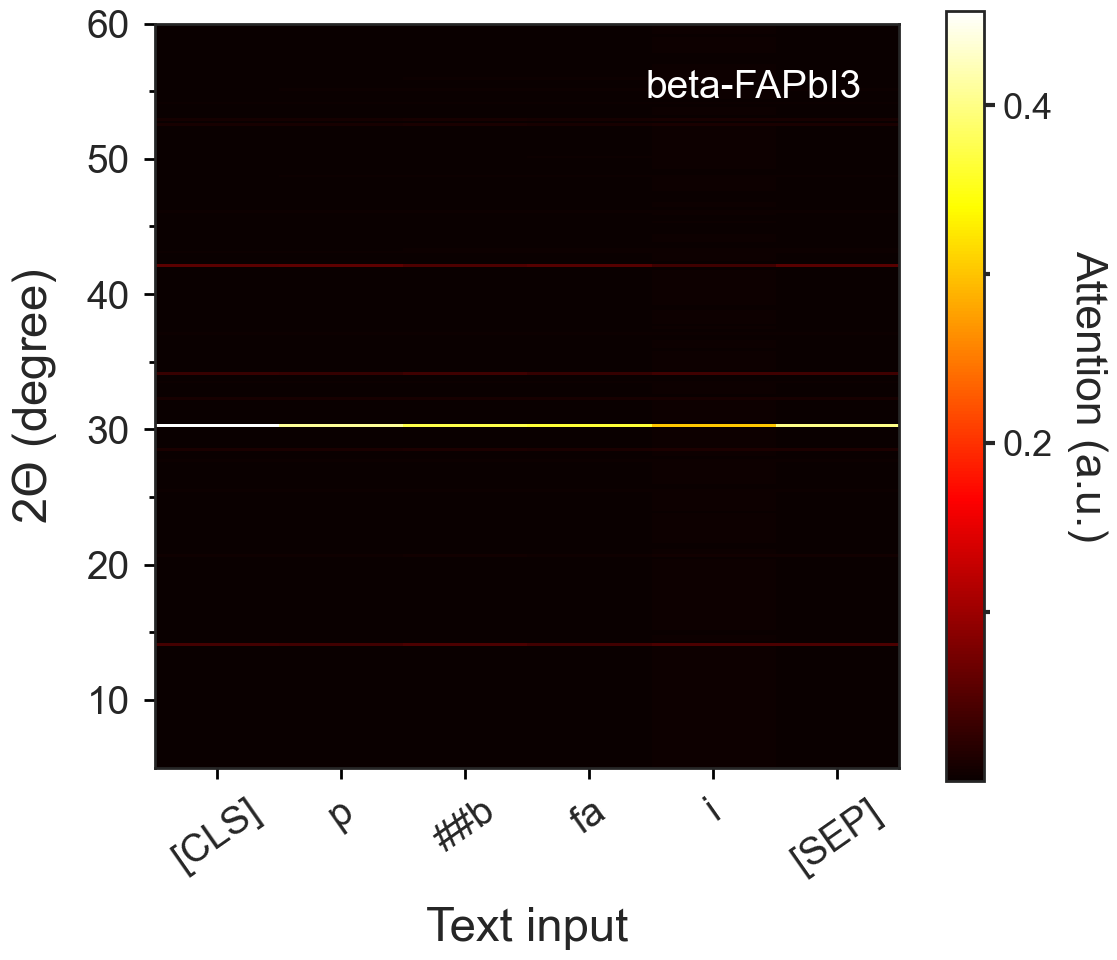

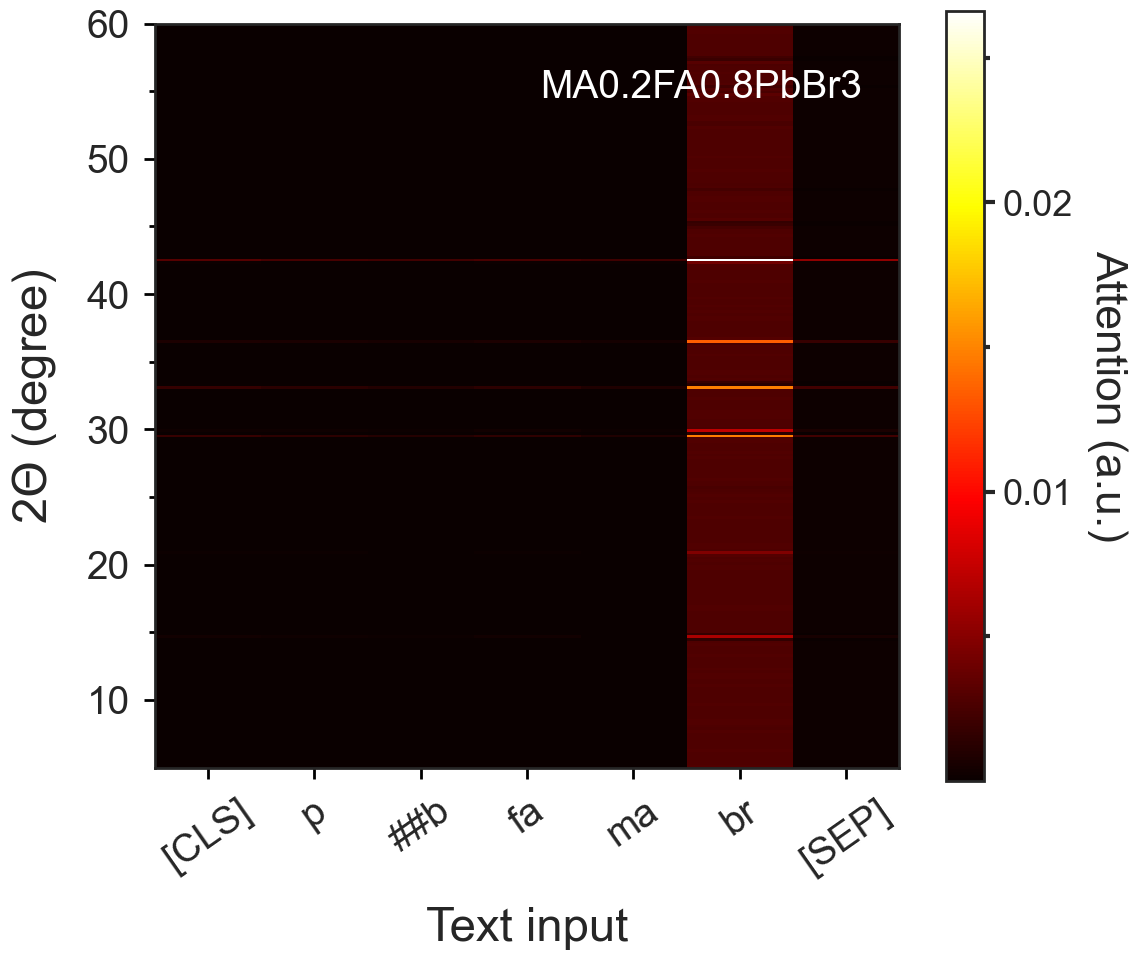

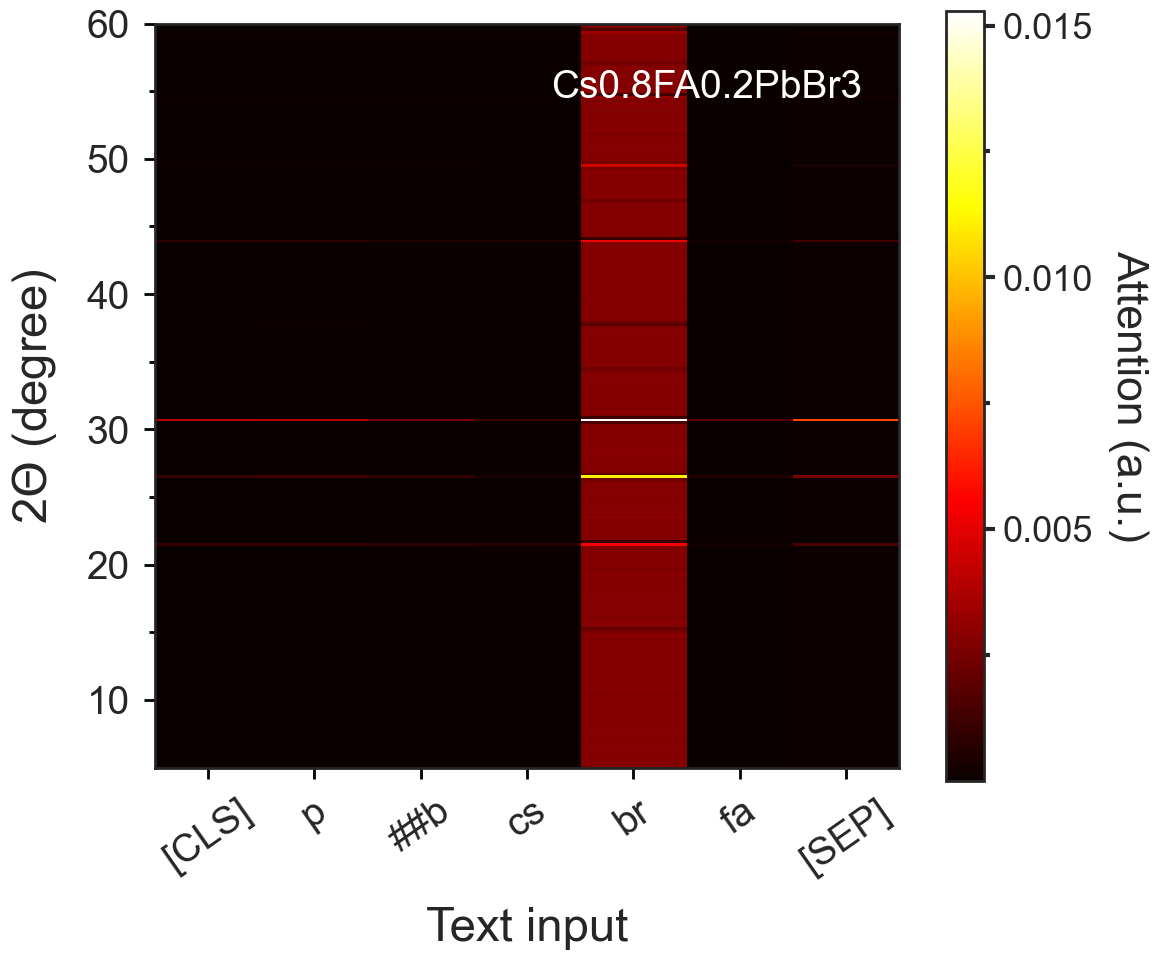

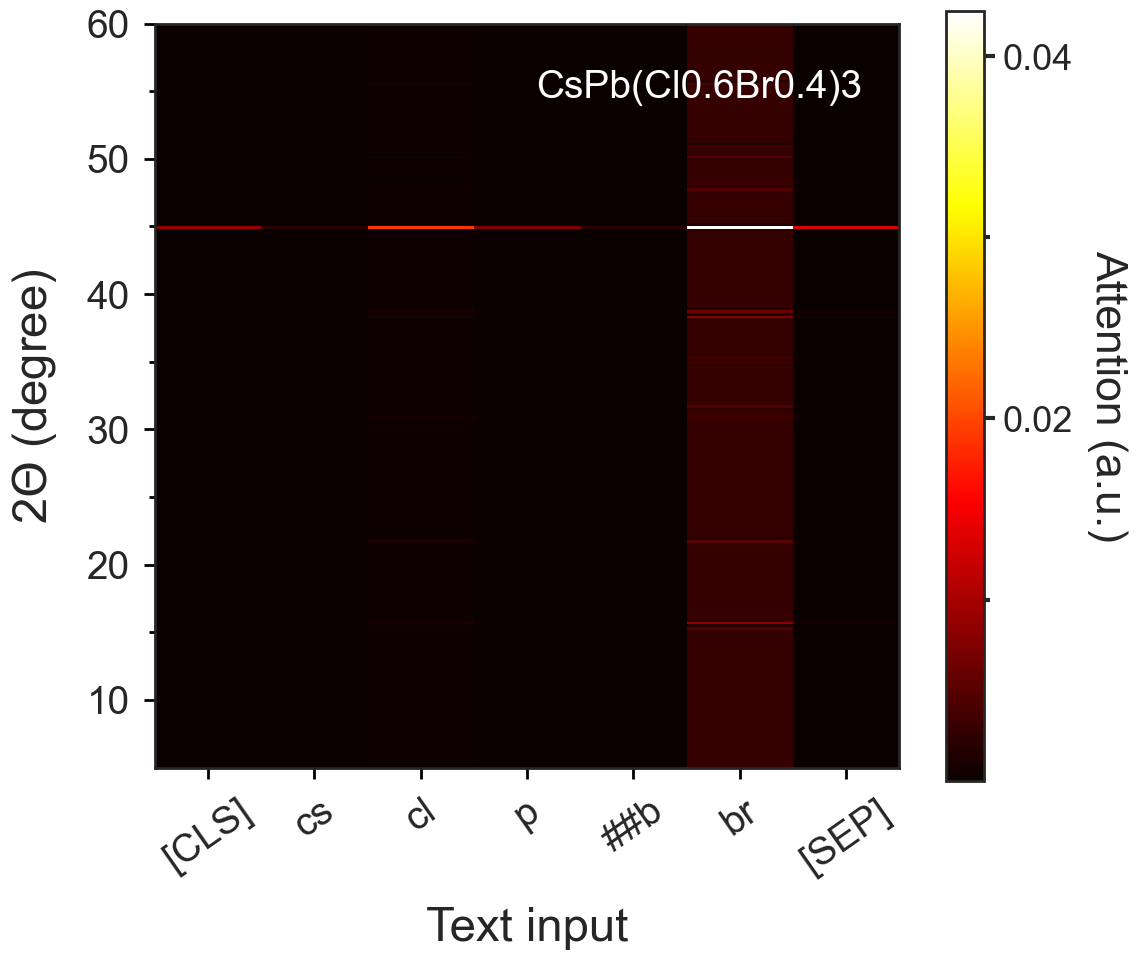

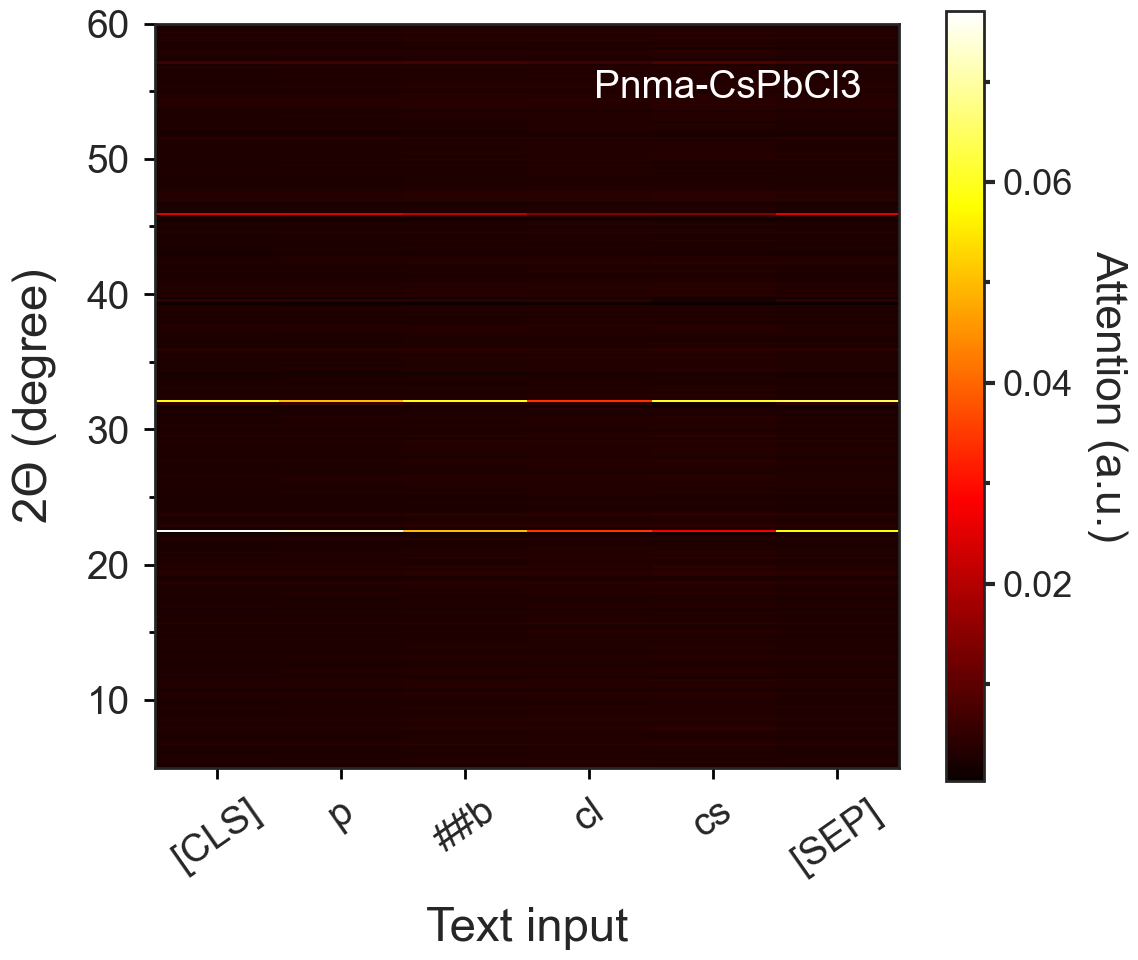

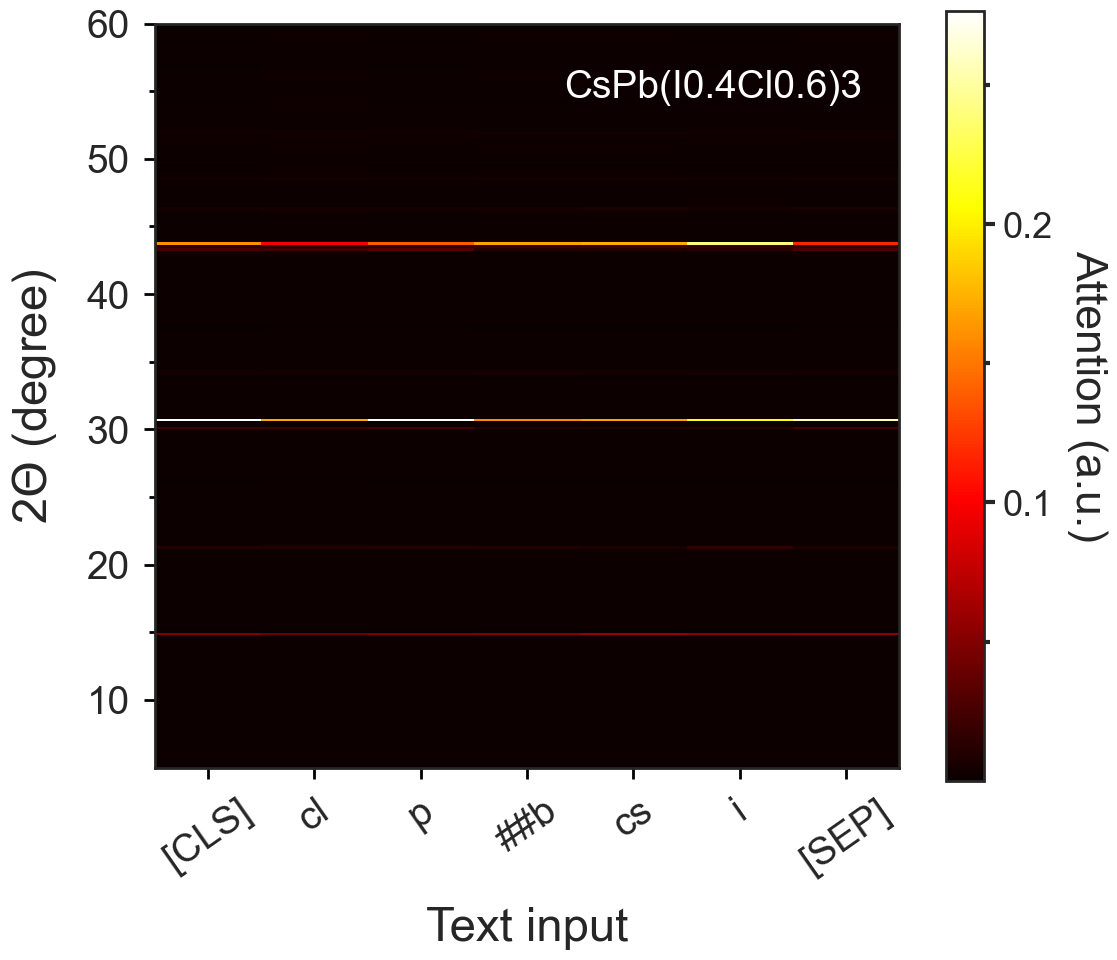

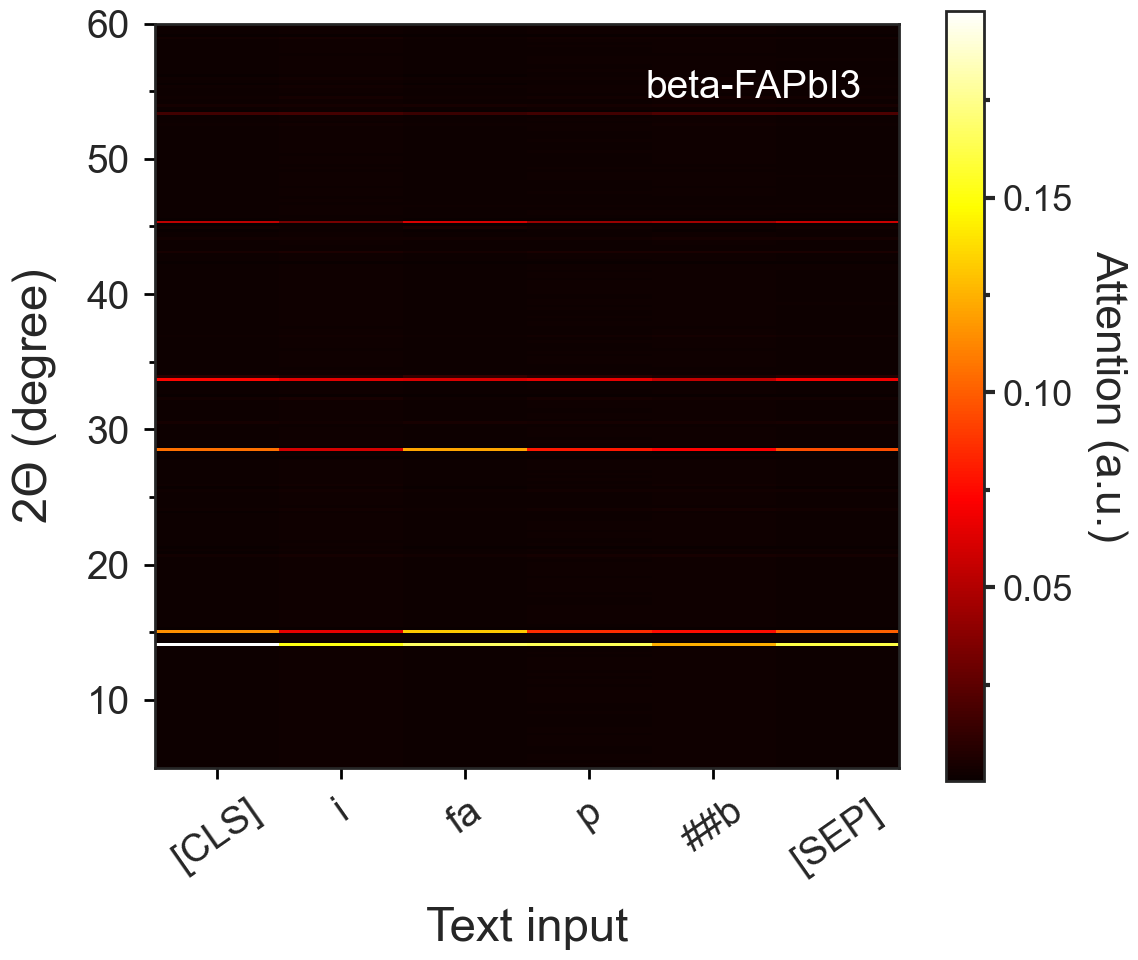

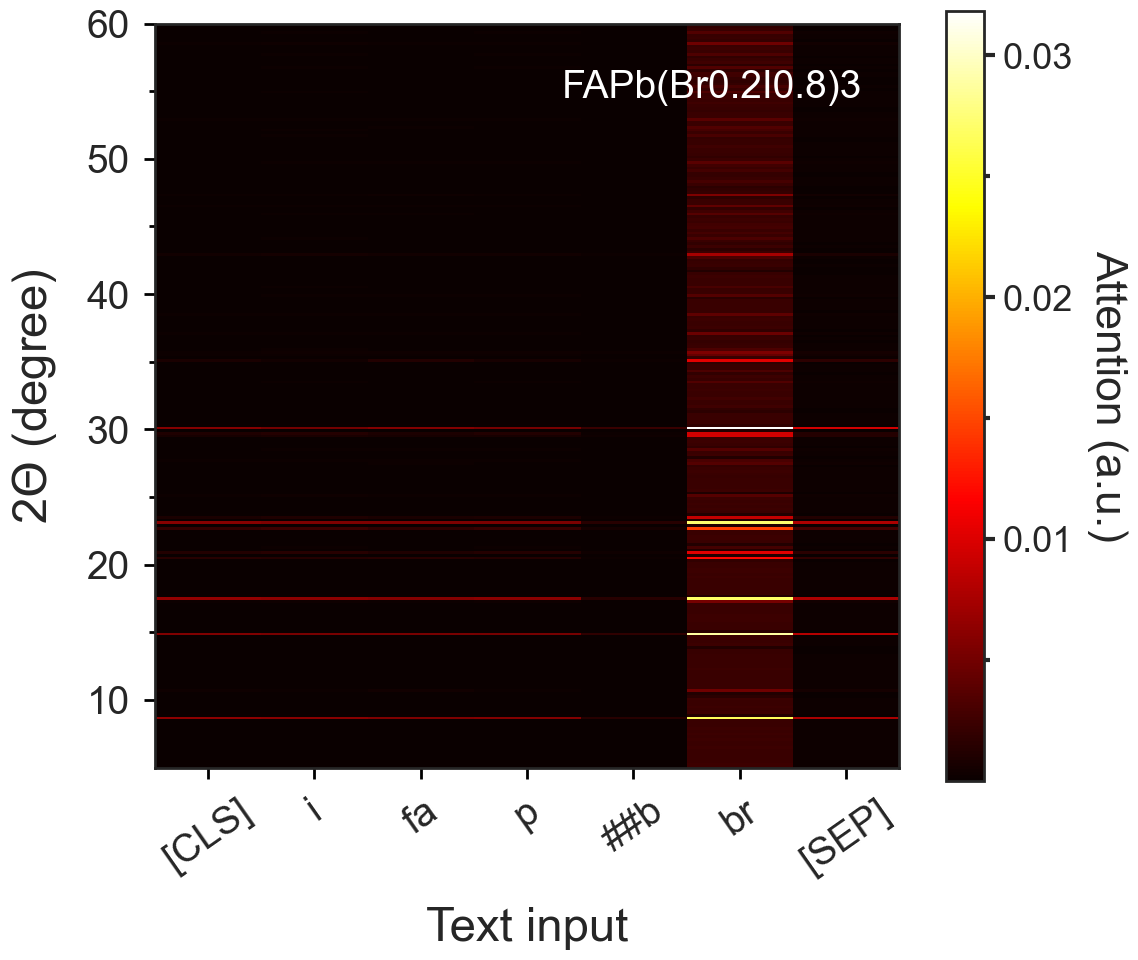

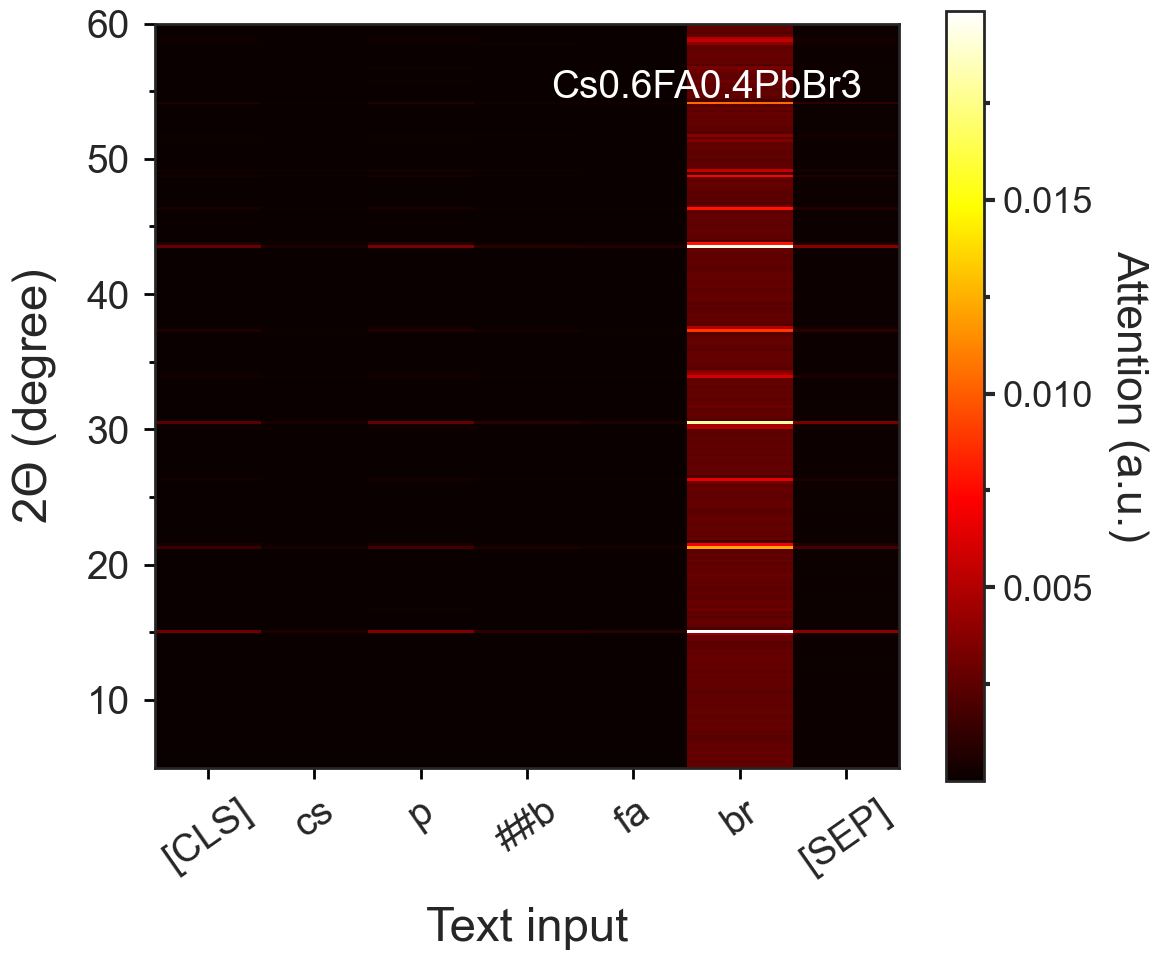

In [290]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(20):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,:len(inputs['input_ids'][0]),len(inputs['input_ids'][0]):]
    extent = [0.5,0.5+len(inputs['input_ids'][0]),twotheta[0],twotheta[-1]]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0]), rotation=35)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0]), steps=[1, 2, 5, 10]))
#     ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
    ax.axes.set_xlim([0.5,0.5+len(inputs['input_ids'][0])])
    ax.axes.set_ylim([5,60])

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Attention (a.u.)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)


    ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
    ax.set_ylabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    plt.text(0.95, 0.9, formula_list[i][0], fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')

    plt.savefig(os.path.join(folder, 'models','20240905','{}_attention.svg'.format(formula_list[i][0])), format='svg', dpi=300, transparent=True, bbox_inches='tight')


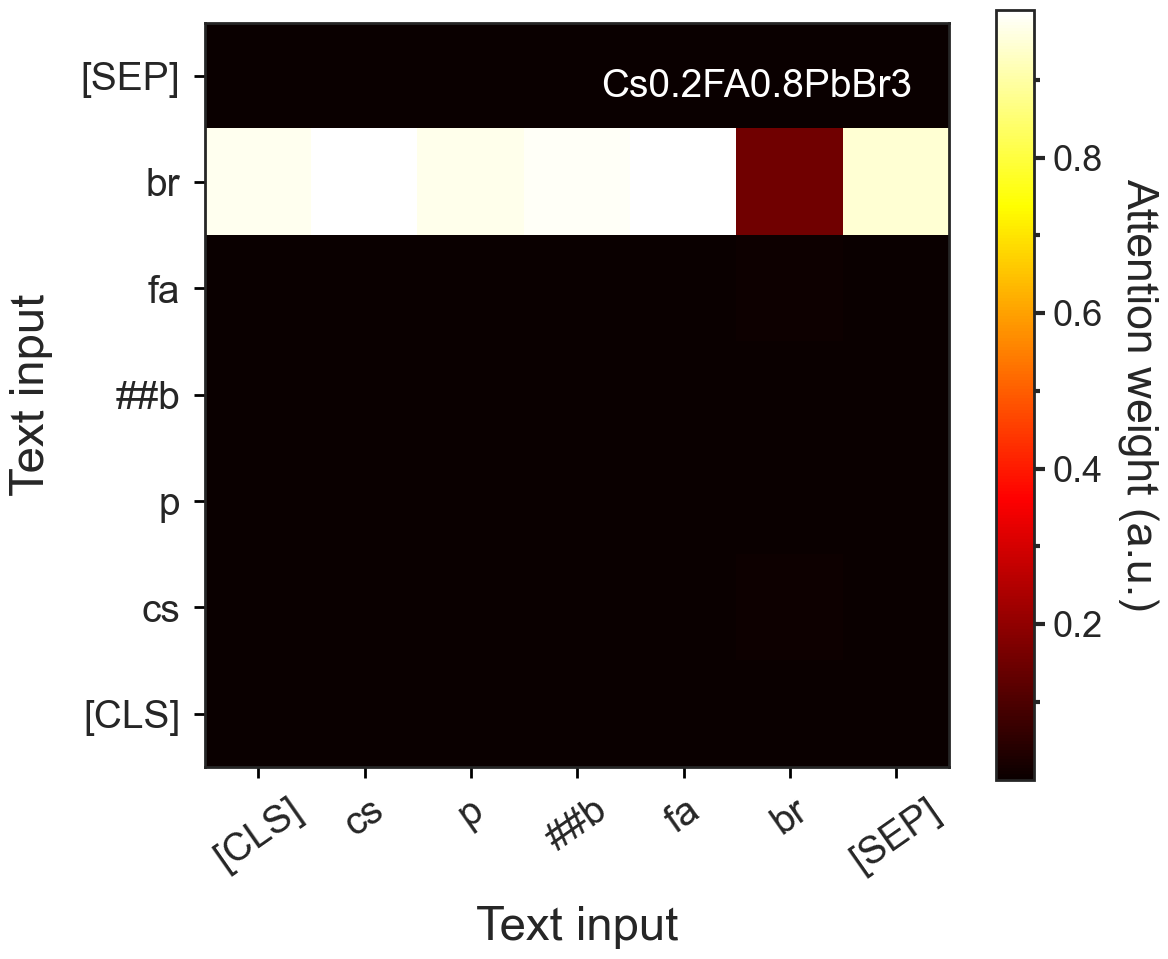

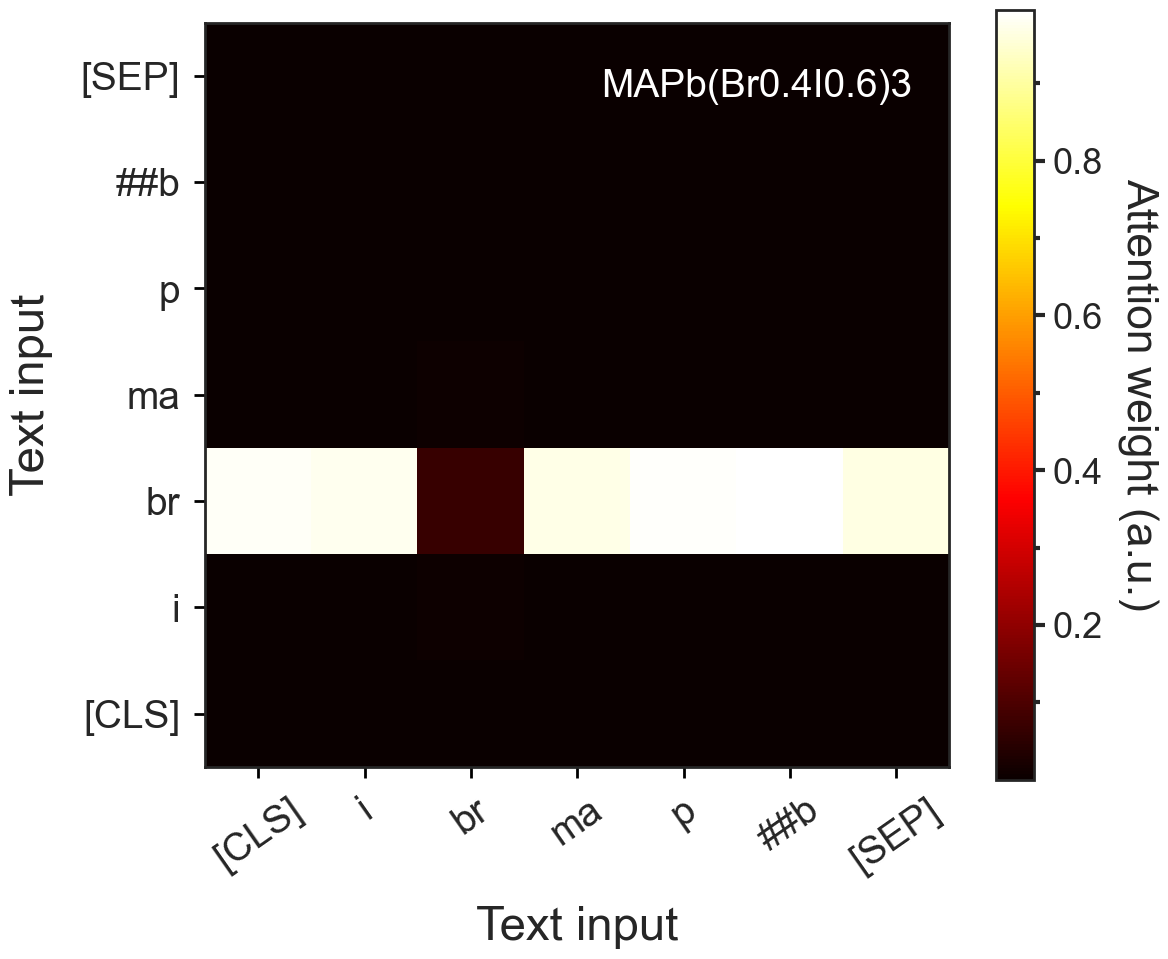

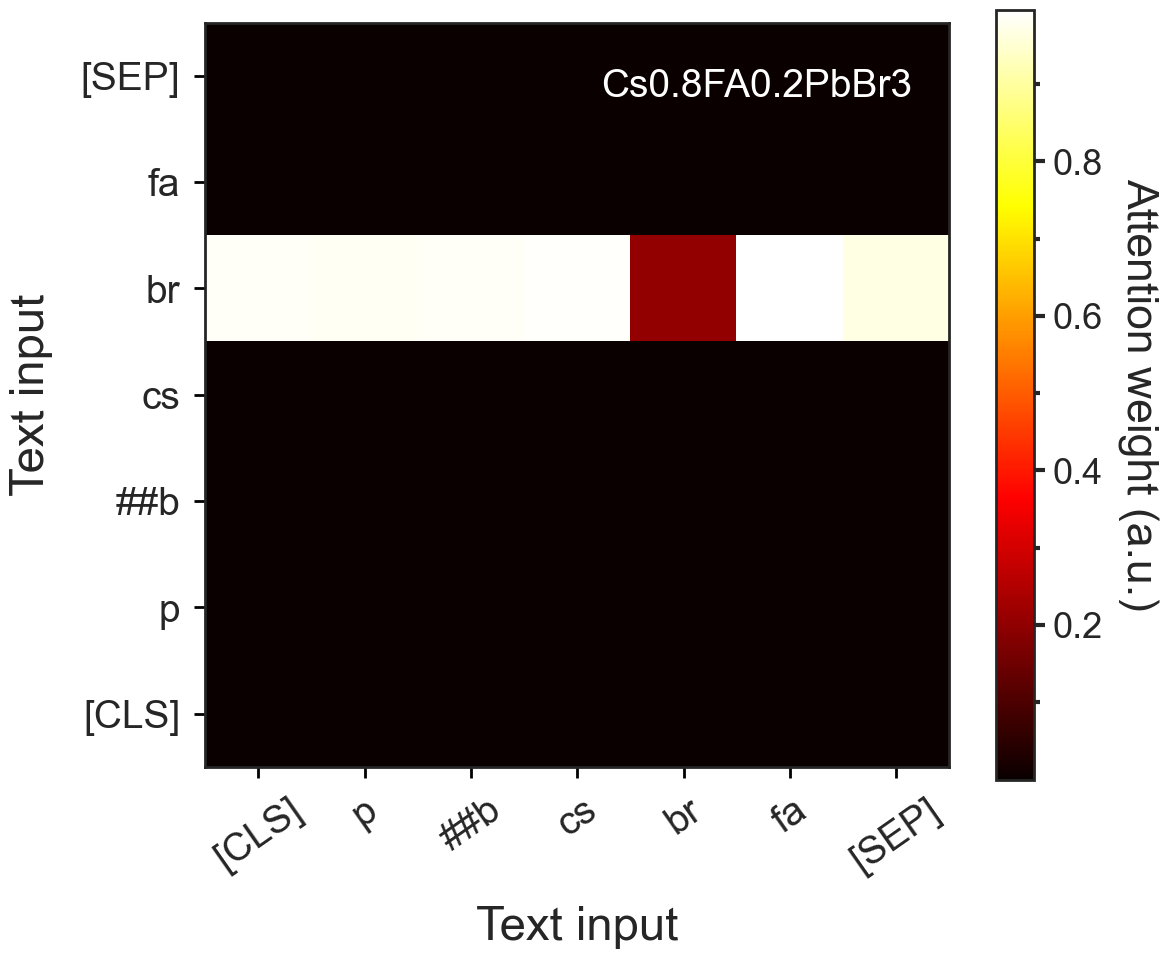

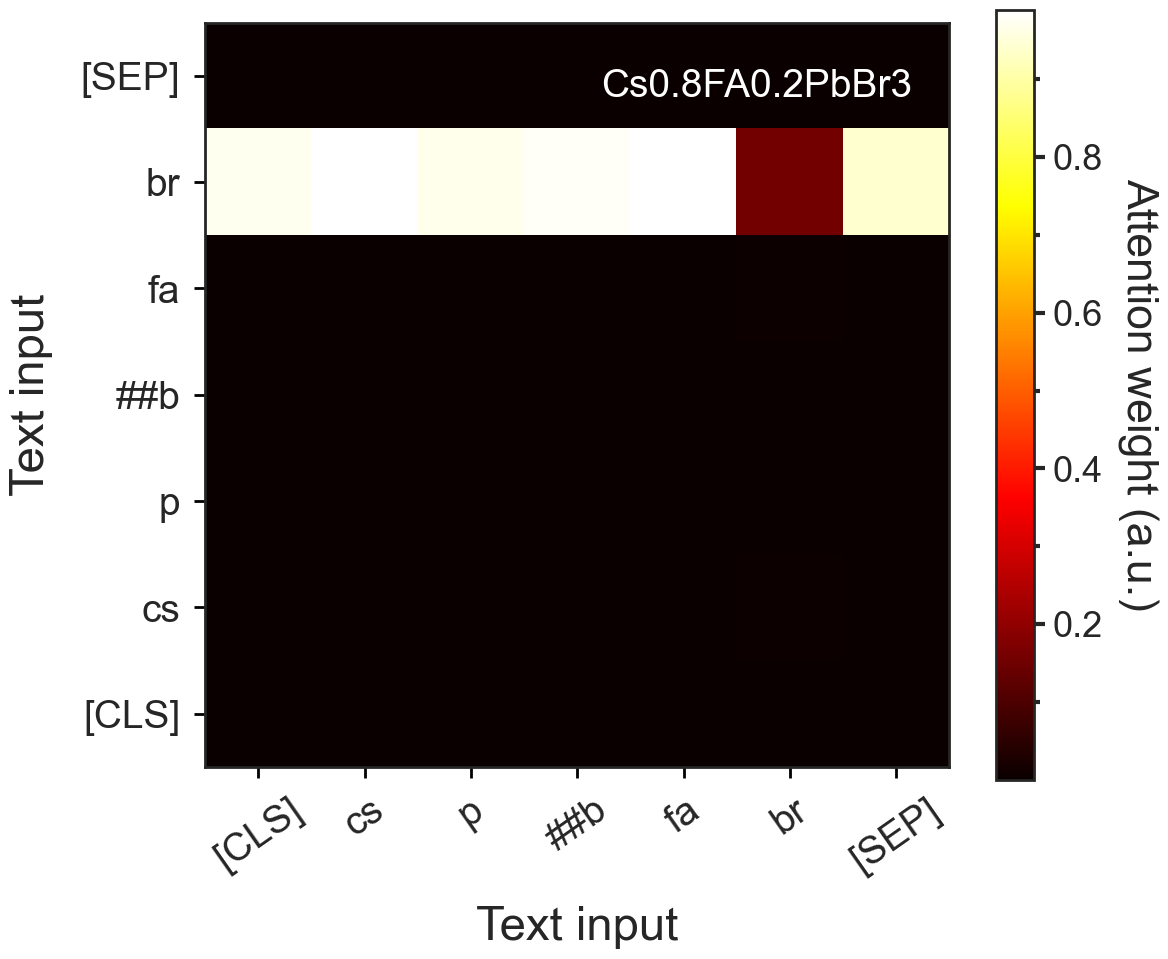

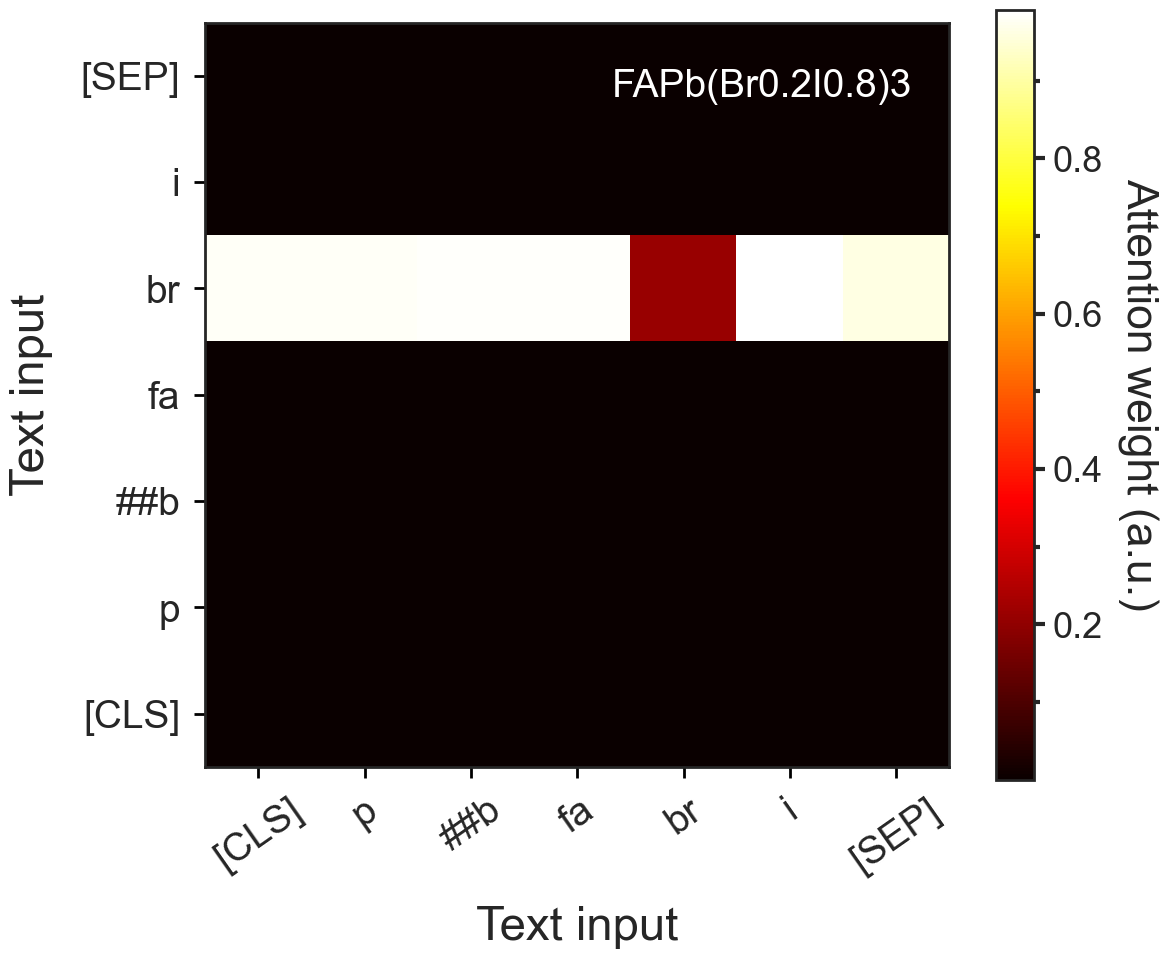

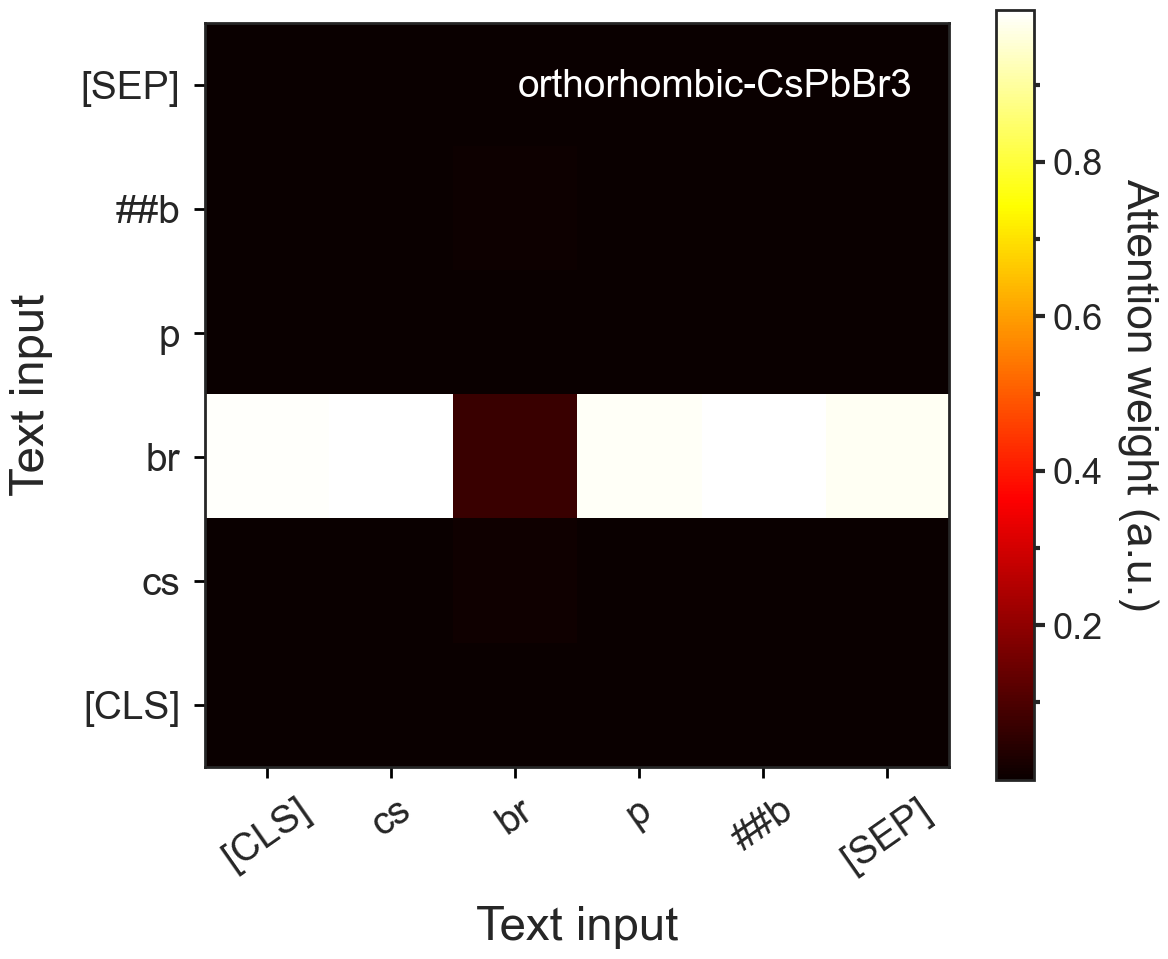

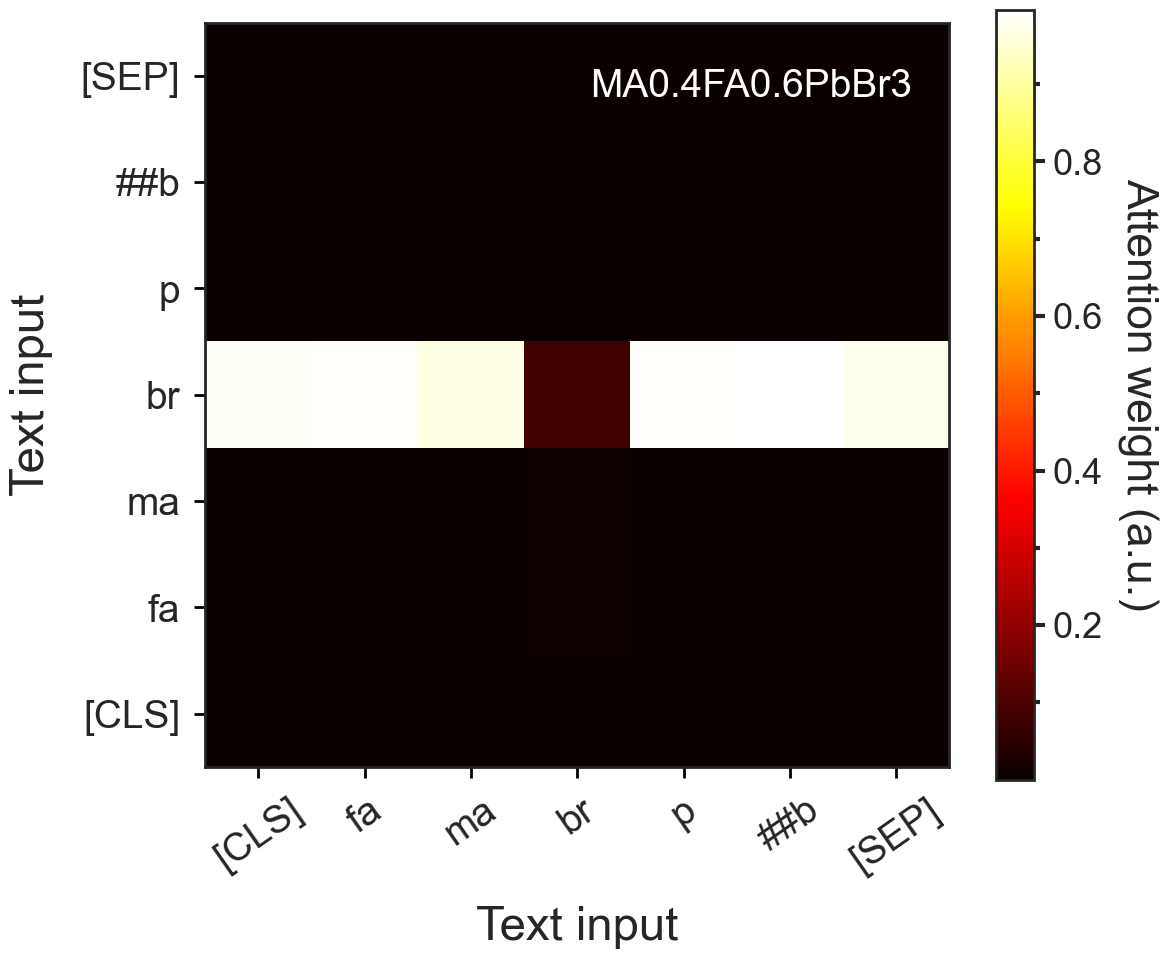

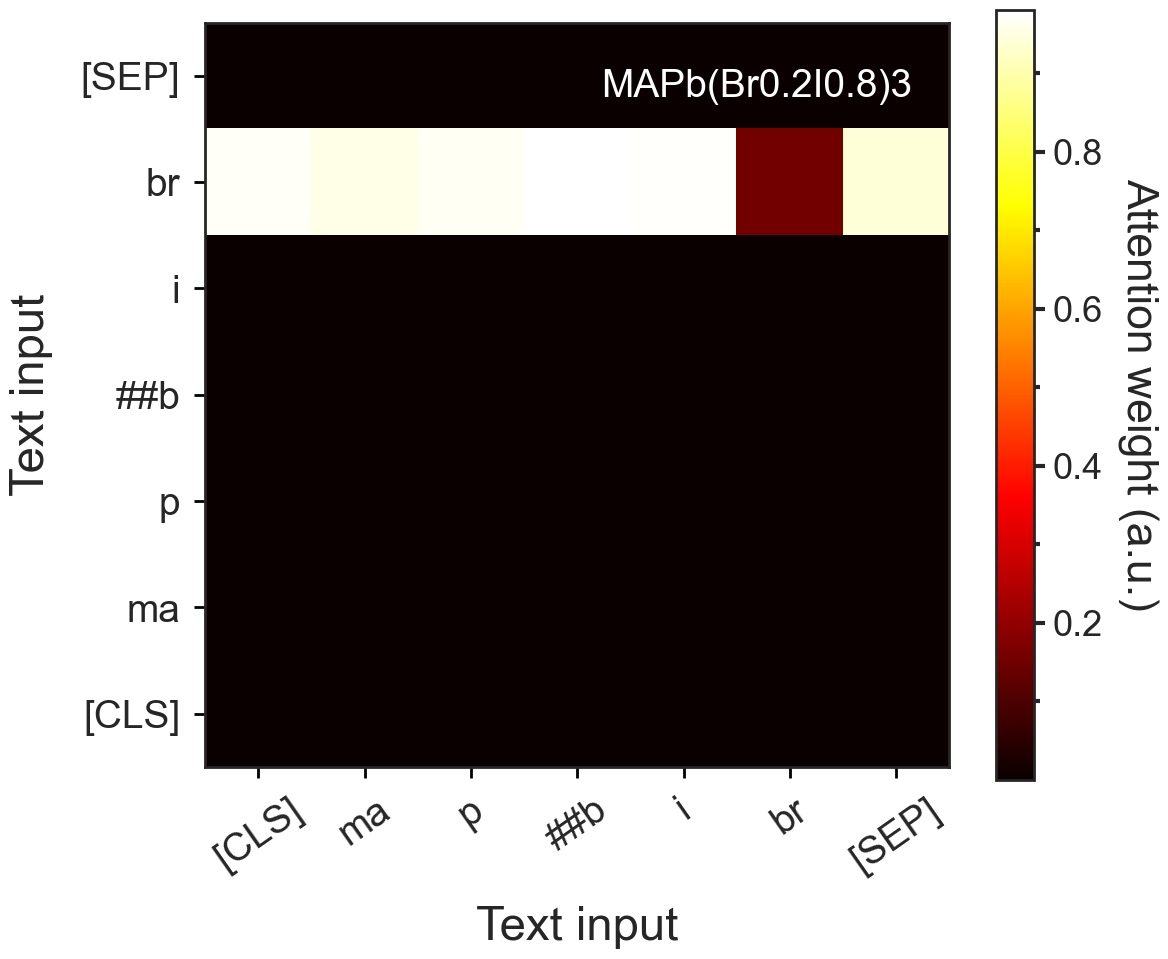

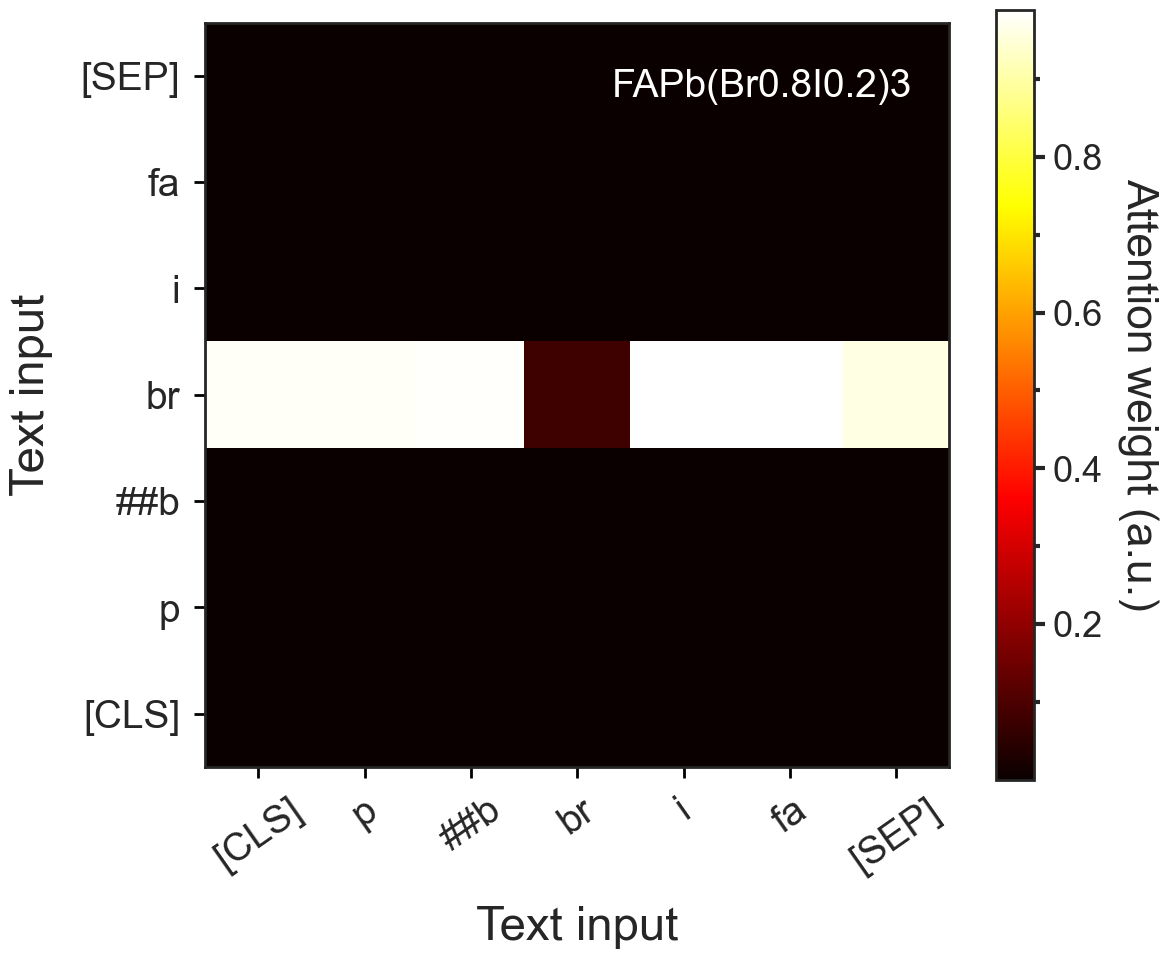

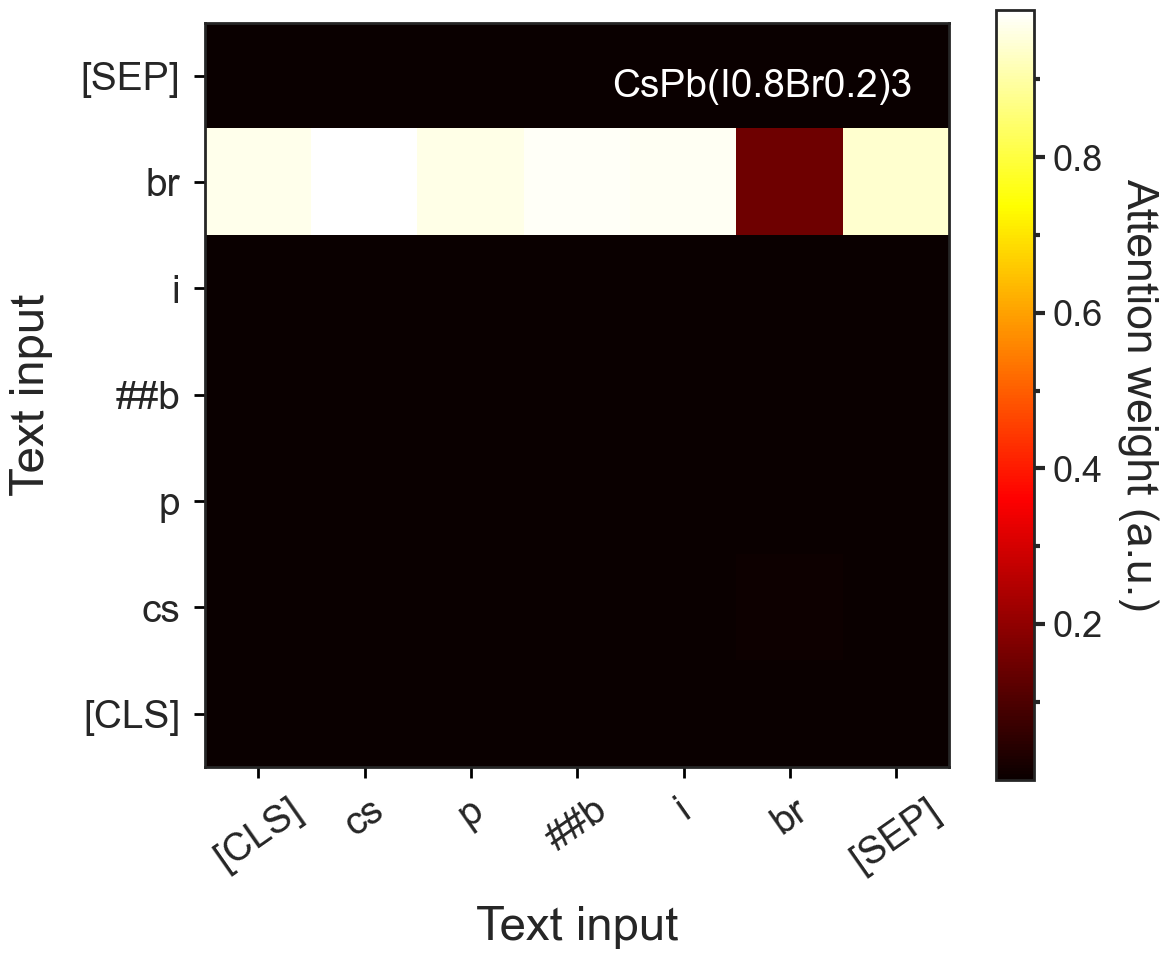

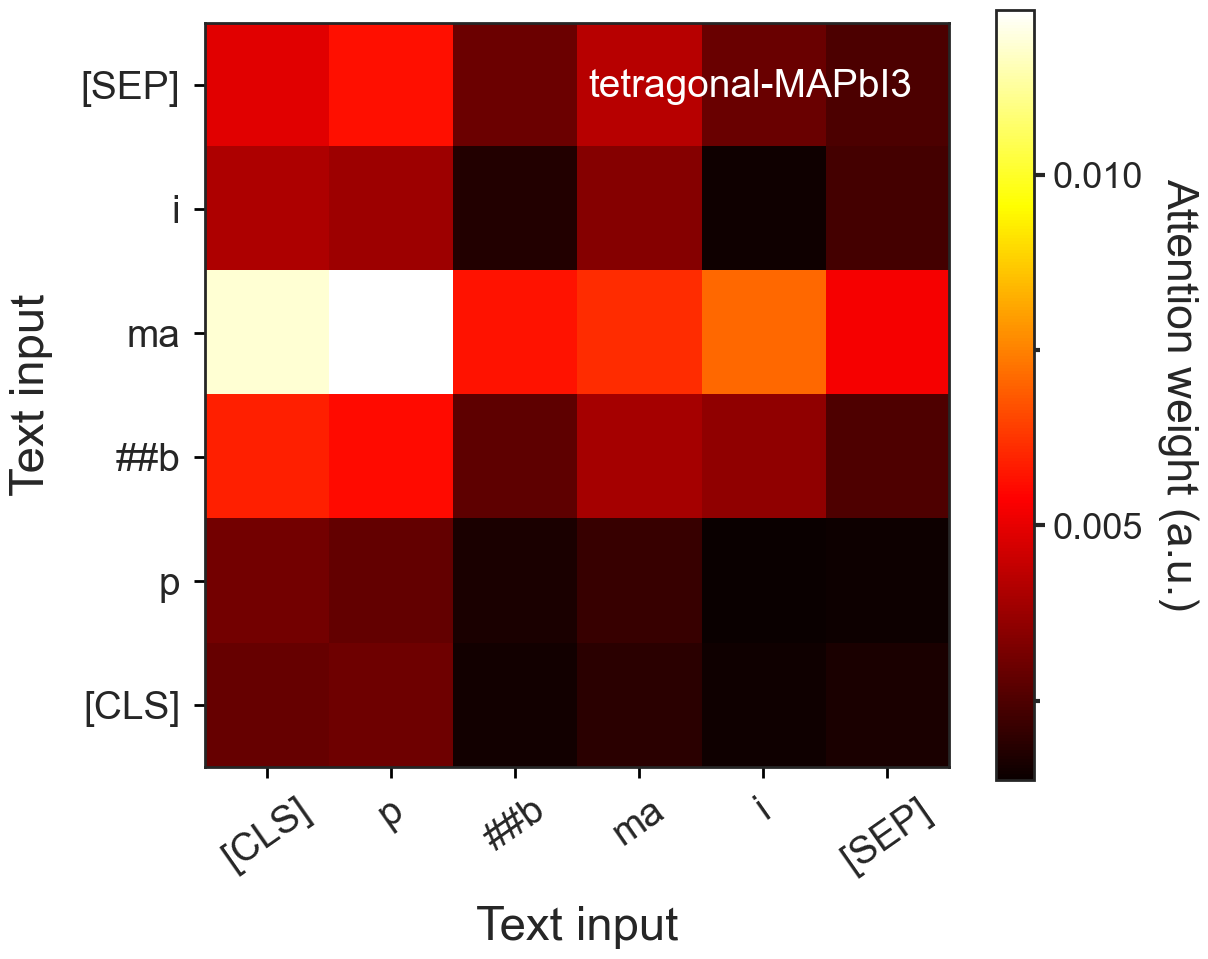

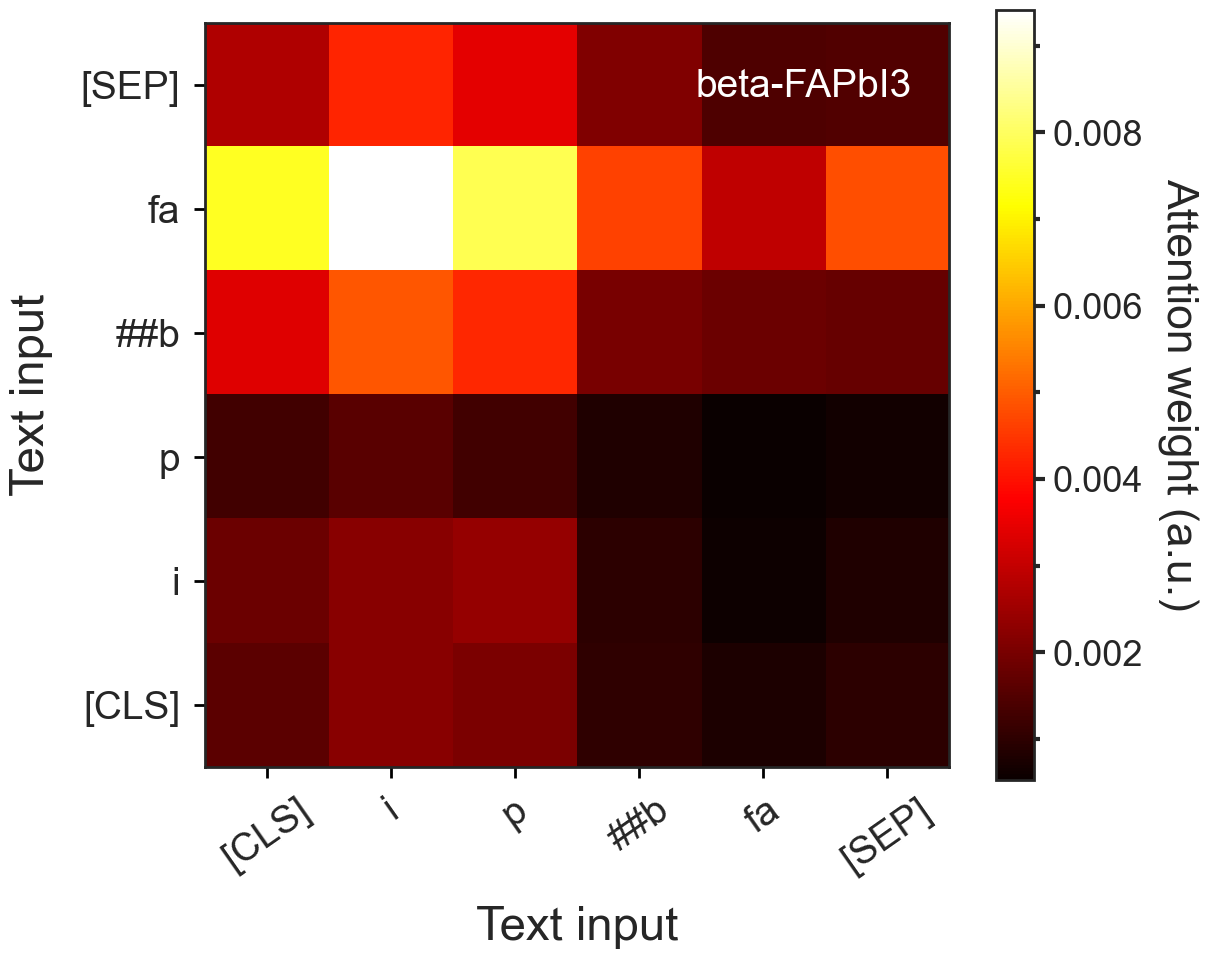

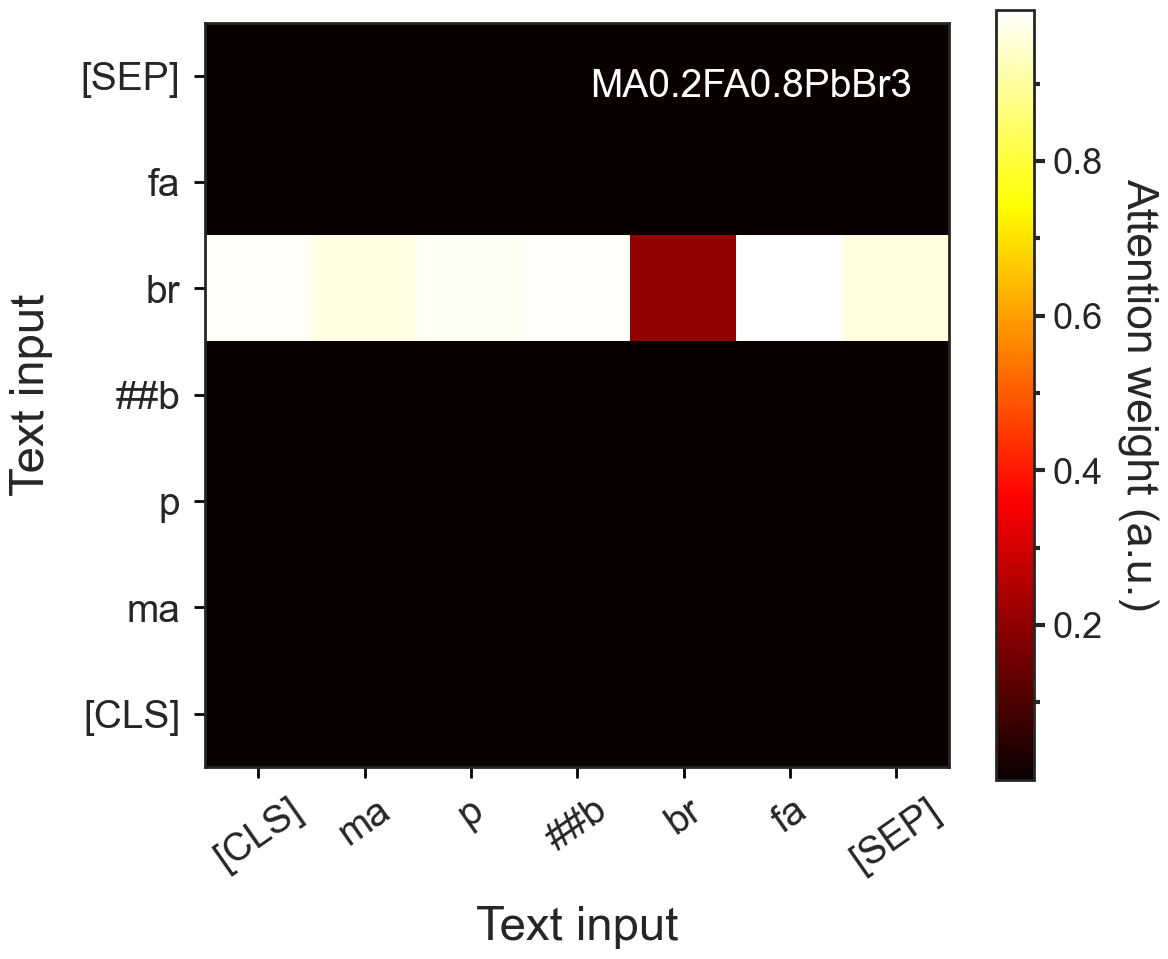

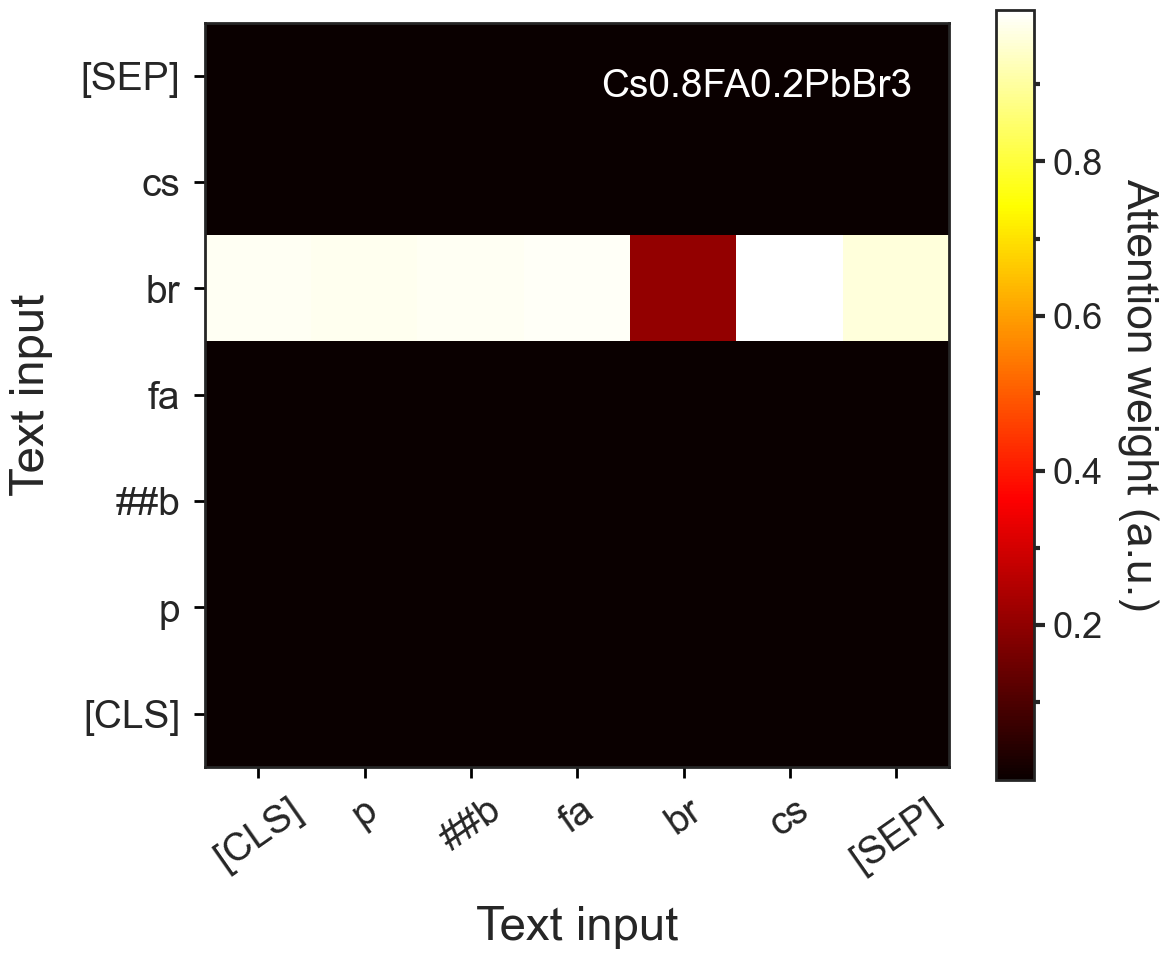

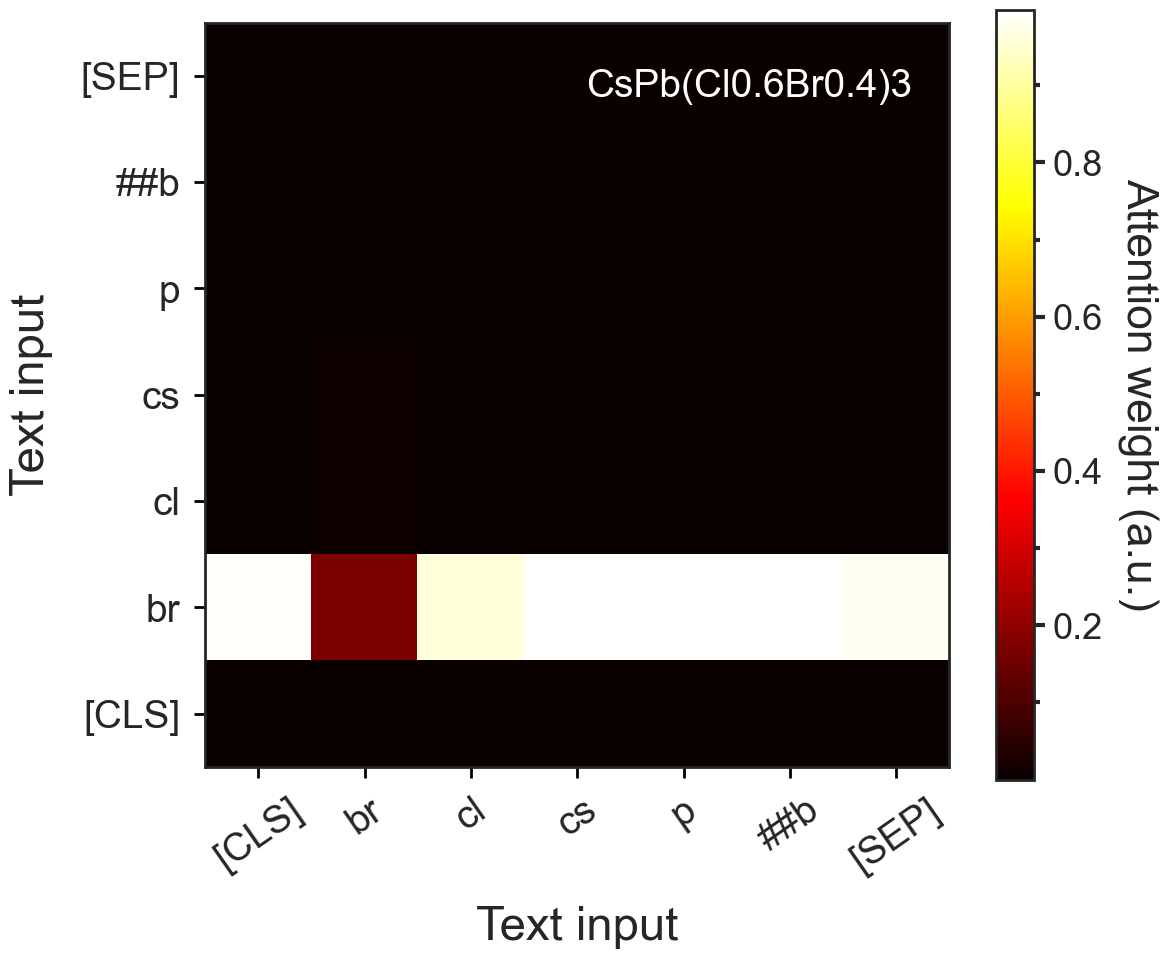

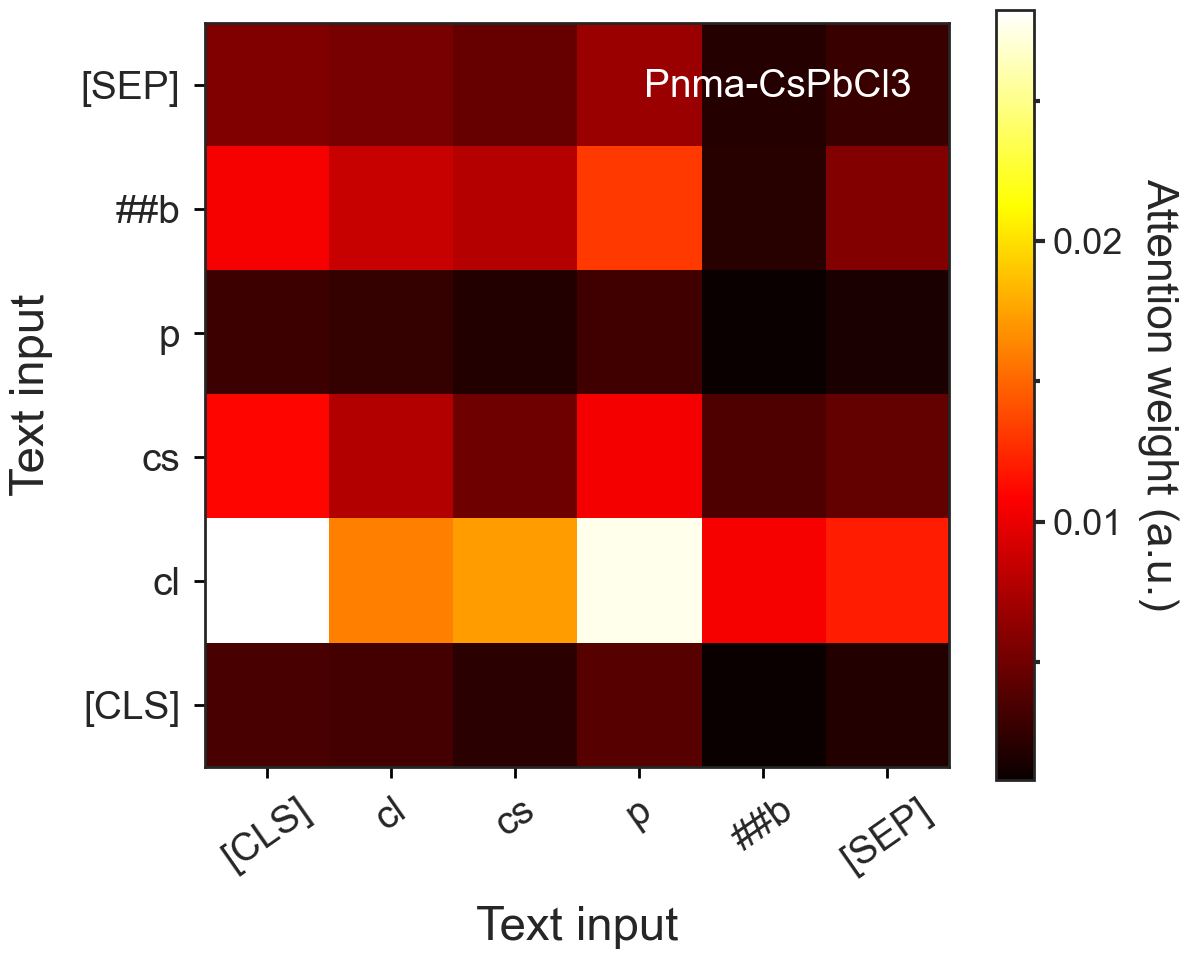

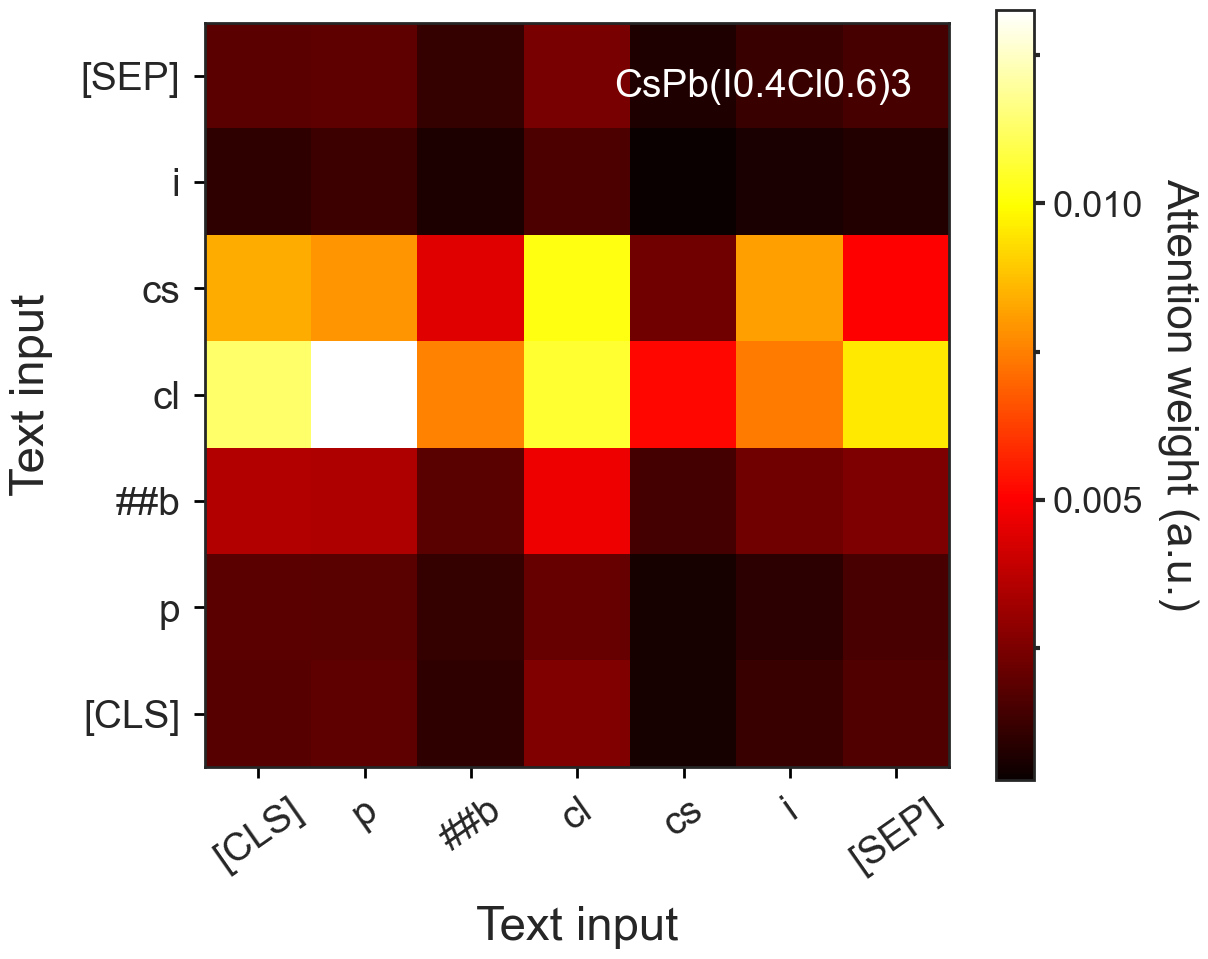

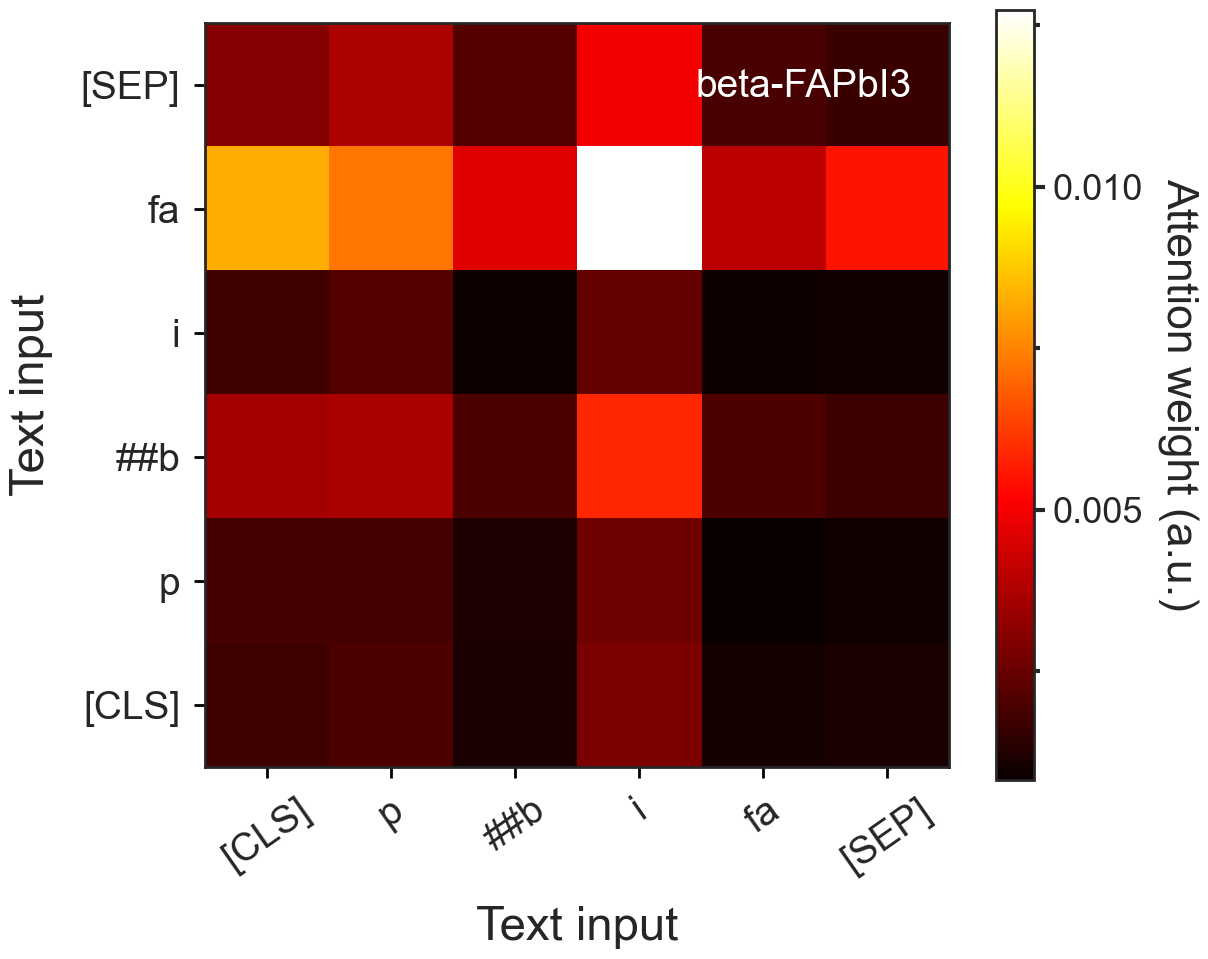

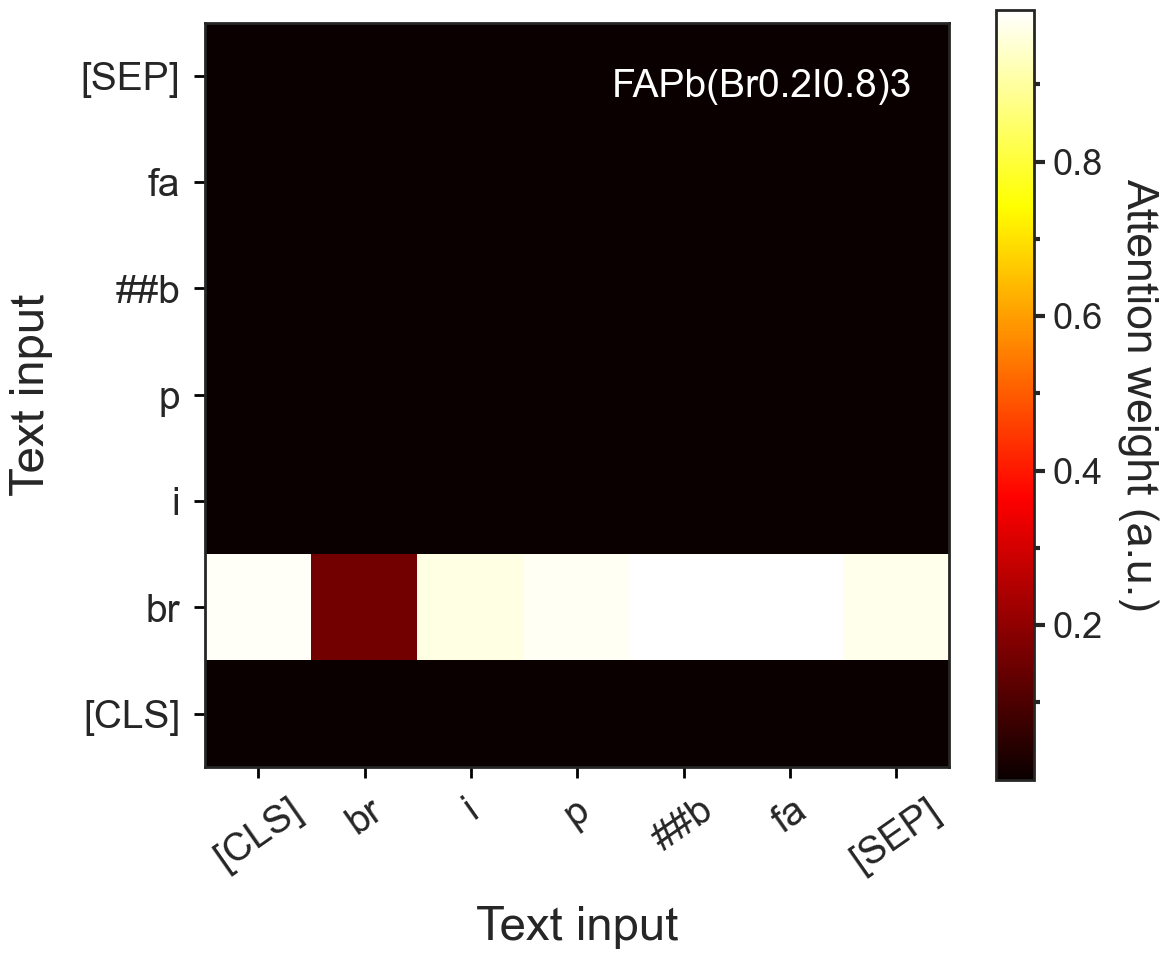

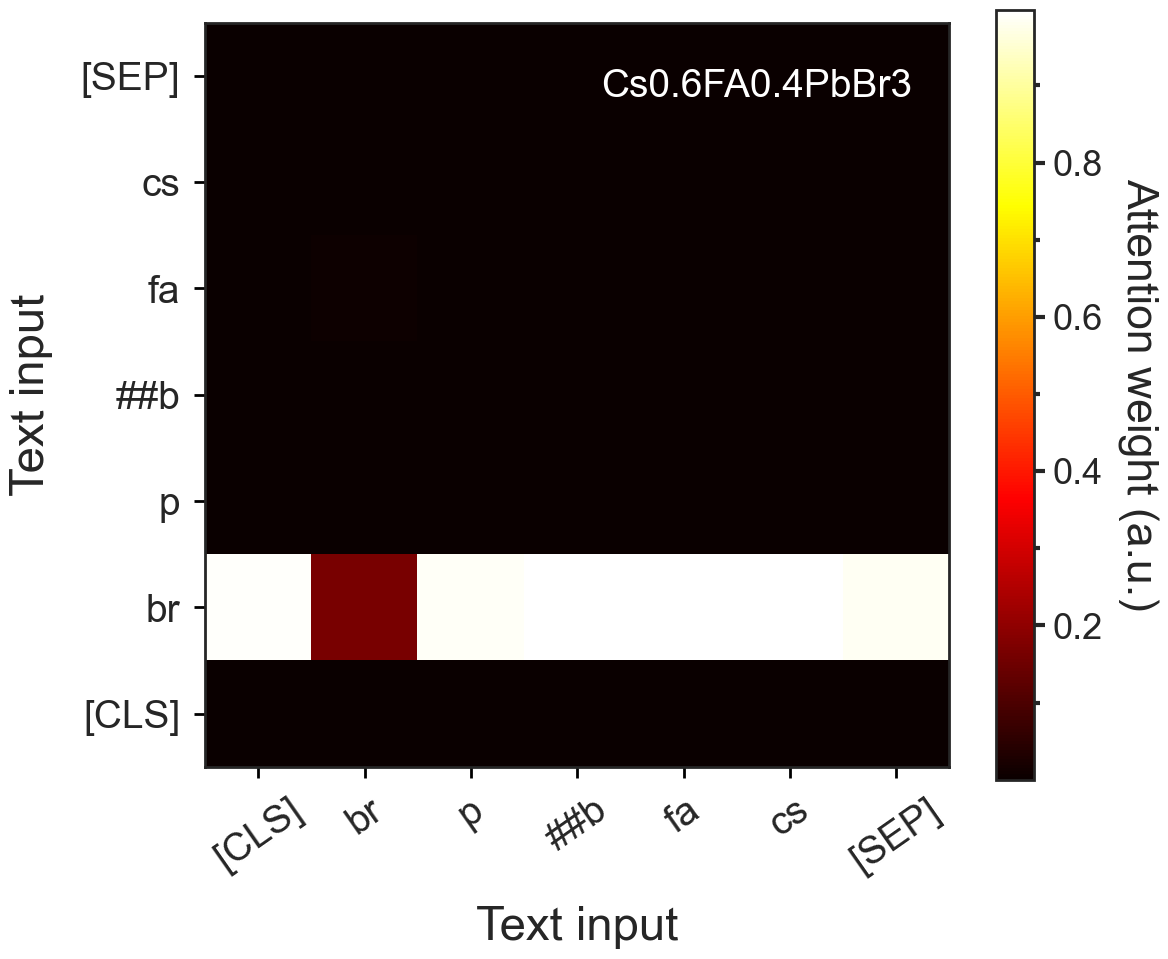

In [301]:
for i in range(20):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    Y = np.sum(np.array(outputs.attentions[0].detach().cpu())[0,:,:len(inputs['input_ids'][0]),:len(inputs['input_ids'][0])],axis=0)
    extent = [0.5,0.5+len(inputs['input_ids'][0]),0.5,0.5+len(inputs['input_ids'][0])]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0]), rotation=35)
    ax.set_yticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0]))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0]), steps=[1, 2, 5, 10]))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0]), steps=[1, 2, 5, 10]))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Attention weight (a.u.)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)


    ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
    ax.set_ylabel(r'Text input', labelpad=20, fontsize=34)

    plt.text(0.95, 0.9, formula_list[i][0], fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    
    plt.savefig(os.path.join(folder, 'models','20240905','{}_attention_text.svg'.format(formula_list[i][0])), format='svg', dpi=300, transparent=True, bbox_inches='tight')
